# Importing packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation')
from utils.utils import setup_logging, get_config_from_yaml, process_config, print_config
from dataset.cityscapes import Cityscapes
from metrics.performance import SegmentationMetric
from utils.helper import val_plot
from patch.create import Patch
#from metrics.performance import SegmentationMetric


from pretrained_models.ICNet.icnet import ICNet
from pretrained_models.BisNetV1.model import BiSeNetV1
from pretrained_models.BisNetV2.model import BiSeNetV2
from pretrained_models.PIDNet.model import PIDNet, get_pred_model


# from trainer.trainer import Trainer
# import torch
from tqdm import tqdm
config = get_config_from_yaml('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/configs/config.yaml')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
def pixAcc_miou(config,model,dataloader, device, name):
    model.eval()
    metric = SegmentationMetric(config)
    metric.reset()
    lsit_pixAcc = []
    list_mIoU = []
    mean_standard = np.array([0.485, 0.456, 0.406],dtype = np.float32)
    std_standard = np.array([0.229, 0.224, 0.225],dtype = np.float32)
    patch_size = config.patch.size
    patch = torch.rand((3, patch_size, patch_size))
    apply_patch = Patch(config).apply_patch
    with torch.no_grad():
        for i_iter, batch in tqdm(enumerate(dataloader, 0)):
            image_standard, targets, bd_gts, _, _ = batch
            image_standard, targets = apply_patch(image_standard,targets,patch)
            targets = targets.to(device)
            if 'pidnet' in name:
              image_standard = image_standard.to(device)
              outputs = model(image_standard)
              size = targets.shape
              output = F.interpolate(
                            outputs[config.test.output_index_pidnet], size[-2:],
                            mode='bilinear', align_corners=True
                        )

            if 'segformer' in name:
              image_standard = image_standard.to(device)
              outputs = model(image_standard)
              size = targets.shape
              output = F.interpolate(
                            outputs.logits, size[-2:],
                            mode='bilinear', align_corners=True
                        )

            if 'icnet' in name:
              image_standard = image_standard.to(device)
              outputs = model(image_standard)
              output = outputs[config.test.output_index_icnet]

            if 'bisenet' in name:
              ## Images needs to be unnormalized and then normalized as:
              ## mean=[0.3257, 0.3690, 0.3223], std=[0.2112, 0.2148, 0.2115]
              ## The it will give 75% miou instead of 71 and to keep things simple keeping it as it
              image_standard = image_standard.to(device)
              outputs = model(image_standard)
              output = outputs[config.test.output_index_bisenet]

            metric.update(output, targets)
            print(f'{(i_iter+1)*6}/{len(cityscape_train)}: miou: {metric.get()[1]}')
    # print(f'\nPixel Accuracy: {metric.get()[0]}')
    # print(f'miou: {metric.get()[1]}')
    return metric.get(full = True)

----
# 0. Dataset

In [ ]:
cityscape_train = Cityscapes(
          root = config.dataset.root,
          list_path = config.dataset.train,
          num_classes = config.dataset.num_classes,
          multi_scale = True,
          flip = True,
          ignore_label = config.train.ignore_label,
          base_size = config.train.base_size,
          crop_size = (config.train.height,config.train.width),
        )

train_dataloader = torch.utils.data.DataLoader(dataset=cityscape_train,
                                            batch_size=6,
                                            shuffle=True,
                                            num_workers=config.train.num_workers,
                                            pin_memory=config.train.pin_memory,
                                            drop_last=config.train.drop_last)

# 1. PIDNet-s

- Paper: https://arxiv.org/pdf/2206.02066
- Code: https://github.com/XuJiacong/PIDNet

## 1.1. Getting the model

In [ ]:
model = torch.load('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/pretrained_models/PIDNet/PIDNet_S_Cityscapes_test.pt',map_location=device)
pidnet_s = get_pred_model(name = 'pidnet_s', num_classes = 19).to(device)
if 'state_dict' in model:
    model = model['state_dict']
model_dict = pidnet_s.state_dict()
model = {k[6:]: v for k, v in model.items() # k[6:] to start after model. in key names
                    if k[6:] in model_dict.keys()}

pidnet_s.load_state_dict(model)
pidnet_s.eval()
print('PIDNet Model loaded')

<ipython-input-6-ef580d3679b6>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/pretr

PIDNet Model loaded


## 1.2. Plotting random outputs

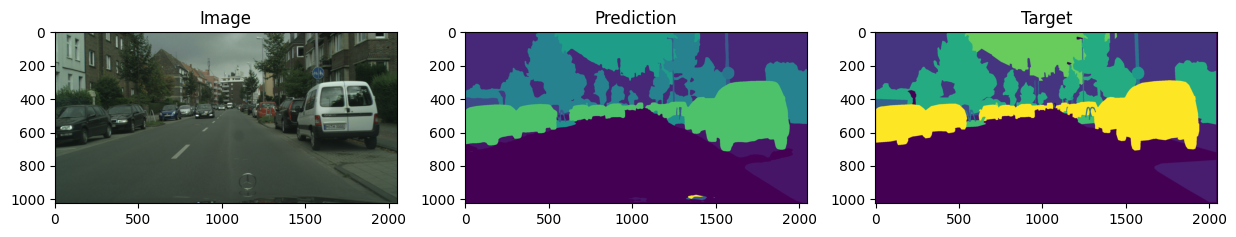

In [ ]:
val_plot(config,pidnet_s, dataset =cityscape_test, device = device, name = 'pidnet_s')

## 1.3. Computing miou

In [ ]:
pixAcc_miou(config,
            model = pidnet_s,
            dataloader = train_dataloader,
            device = device,
            name = 'pidnet_s')

1it [00:16, 16.26s/it]

6/2975: miou: 0.6436970829963684


2it [00:16,  6.89s/it]

12/2975: miou: 0.6463193893432617


3it [00:31, 10.34s/it]

18/2975: miou: 0.6993172764778137


5it [00:48, 10.42s/it]

24/2975: miou: 0.7369588017463684
30/2975: miou: 0.7793818712234497


7it [01:01,  8.79s/it]

36/2975: miou: 0.7784538865089417
42/2975: miou: 0.7806847095489502


9it [01:18,  9.16s/it]

48/2975: miou: 0.8001344203948975
54/2975: miou: 0.8108146786689758


10it [01:20,  7.03s/it]

60/2975: miou: 0.8089798092842102


11it [01:35,  9.52s/it]

66/2975: miou: 0.8072559237480164


12it [01:37,  7.18s/it]

72/2975: miou: 0.8105974793434143


13it [01:53,  9.87s/it]

78/2975: miou: 0.8525750041007996


14it [01:56,  7.71s/it]

84/2975: miou: 0.8518440127372742


15it [02:06,  8.67s/it]

90/2975: miou: 0.8503978252410889


16it [02:09,  6.97s/it]

96/2975: miou: 0.8525208830833435


17it [02:24,  9.11s/it]

102/2975: miou: 0.8524539470672607


19it [02:40,  9.34s/it]

108/2975: miou: 0.8556911945343018
114/2975: miou: 0.8577311635017395


21it [02:56,  9.21s/it]

120/2975: miou: 0.8503212928771973
126/2975: miou: 0.8491101264953613


23it [03:11,  9.18s/it]

132/2975: miou: 0.8424484133720398
138/2975: miou: 0.8430557250976562


25it [03:29,  9.67s/it]

144/2975: miou: 0.8415655493736267
150/2975: miou: 0.8425090312957764


27it [03:45,  9.60s/it]

156/2975: miou: 0.8404884338378906
162/2975: miou: 0.8370510935783386


29it [04:00,  9.06s/it]

168/2975: miou: 0.838097095489502
174/2975: miou: 0.8445773124694824


31it [04:16,  9.29s/it]

180/2975: miou: 0.8417456746101379
186/2975: miou: 0.8404656648635864


33it [04:30,  8.47s/it]

192/2975: miou: 0.840258777141571
198/2975: miou: 0.8408986926078796


34it [04:30,  6.04s/it]

204/2975: miou: 0.8408428430557251


35it [04:45,  8.79s/it]

210/2975: miou: 0.8401525020599365


37it [05:04,  9.77s/it]

216/2975: miou: 0.8395364880561829
222/2975: miou: 0.8395512700080872


39it [05:18,  9.13s/it]

228/2975: miou: 0.8394788503646851
234/2975: miou: 0.8386658430099487


40it [05:18,  6.48s/it]

240/2975: miou: 0.8385387659072876


41it [05:34,  9.16s/it]

246/2975: miou: 0.8390868902206421


43it [05:50,  9.13s/it]

252/2975: miou: 0.8473607301712036
258/2975: miou: 0.8461316823959351


44it [05:50,  6.49s/it]

264/2975: miou: 0.845711350440979


45it [06:02,  8.06s/it]

270/2975: miou: 0.8452697396278381


47it [06:17,  8.51s/it]

276/2975: miou: 0.844304621219635
282/2975: miou: 0.8443275094032288


49it [06:31,  8.41s/it]

288/2975: miou: 0.8440235257148743
294/2975: miou: 0.84444659948349


51it [06:47,  8.79s/it]

300/2975: miou: 0.8427650928497314
306/2975: miou: 0.8438411355018616


53it [07:06,  9.94s/it]

312/2975: miou: 0.8439009785652161
318/2975: miou: 0.8426153063774109


55it [07:19,  8.69s/it]

324/2975: miou: 0.844834566116333
330/2975: miou: 0.8461322784423828


57it [07:34,  8.54s/it]

336/2975: miou: 0.8456743955612183
342/2975: miou: 0.8449199795722961


59it [07:50,  9.02s/it]

348/2975: miou: 0.8451178669929504
354/2975: miou: 0.8444440960884094


61it [08:05,  8.99s/it]

360/2975: miou: 0.8443903923034668
366/2975: miou: 0.8463404774665833


63it [08:23,  9.55s/it]

372/2975: miou: 0.8458560109138489
378/2975: miou: 0.8458350300788879


65it [08:37,  9.07s/it]

384/2975: miou: 0.8458894491195679
390/2975: miou: 0.8476038575172424


67it [08:53,  9.20s/it]

396/2975: miou: 0.8473024964332581
402/2975: miou: 0.8470300436019897


69it [09:07,  8.69s/it]

408/2975: miou: 0.8450023531913757
414/2975: miou: 0.844948410987854


71it [09:22,  8.61s/it]

420/2975: miou: 0.8445305228233337
426/2975: miou: 0.8446386456489563


73it [09:32,  7.15s/it]

432/2975: miou: 0.8446493744850159
438/2975: miou: 0.844122052192688


74it [09:37,  6.56s/it]

444/2975: miou: 0.843885600566864


75it [09:47,  7.61s/it]

450/2975: miou: 0.8436700701713562


76it [09:55,  7.70s/it]

456/2975: miou: 0.8434891104698181


77it [10:05,  8.34s/it]

462/2975: miou: 0.8433127999305725


78it [10:12,  7.98s/it]

468/2975: miou: 0.8433412313461304


79it [10:21,  8.29s/it]

474/2975: miou: 0.8424592018127441


80it [10:29,  8.05s/it]

480/2975: miou: 0.8419221043586731


81it [10:35,  7.50s/it]

486/2975: miou: 0.8421613574028015


82it [10:40,  6.72s/it]

492/2975: miou: 0.8425715565681458


83it [10:53,  8.56s/it]

498/2975: miou: 0.8427073955535889


85it [11:09,  8.97s/it]

504/2975: miou: 0.8424198627471924
510/2975: miou: 0.8422967195510864


87it [11:25,  9.36s/it]

516/2975: miou: 0.8414991497993469
522/2975: miou: 0.8410670757293701


89it [11:38,  8.23s/it]

528/2975: miou: 0.8413984179496765
534/2975: miou: 0.8427906036376953


91it [11:52,  8.37s/it]

540/2975: miou: 0.843176007270813
546/2975: miou: 0.8433060646057129


92it [11:55,  6.55s/it]

552/2975: miou: 0.8441063761711121


93it [12:12,  9.76s/it]

558/2975: miou: 0.8441976308822632


94it [12:20,  9.19s/it]

564/2975: miou: 0.8437564969062805


95it [12:27,  8.41s/it]

570/2975: miou: 0.8433496356010437


96it [12:34,  8.10s/it]

576/2975: miou: 0.8427481651306152


97it [12:42,  8.08s/it]

582/2975: miou: 0.8428524136543274


98it [12:47,  7.08s/it]

588/2975: miou: 0.843097984790802


99it [12:58,  8.28s/it]

594/2975: miou: 0.8381441235542297


100it [13:02,  7.01s/it]

600/2975: miou: 0.8381754159927368


101it [13:14,  8.59s/it]

606/2975: miou: 0.8386877179145813


102it [13:18,  7.27s/it]

612/2975: miou: 0.8387033343315125


103it [13:30,  8.64s/it]

618/2975: miou: 0.8378809690475464


104it [13:34,  7.31s/it]

624/2975: miou: 0.837806224822998


105it [13:46,  8.61s/it]

630/2975: miou: 0.838291347026825


106it [13:53,  8.11s/it]

636/2975: miou: 0.8381637930870056


107it [14:04,  8.97s/it]

642/2975: miou: 0.8387916088104248


108it [14:08,  7.67s/it]

648/2975: miou: 0.8391782641410828


109it [14:20,  8.74s/it]

654/2975: miou: 0.8389911651611328


110it [14:25,  7.78s/it]

660/2975: miou: 0.8387442231178284


111it [14:34,  8.06s/it]

666/2975: miou: 0.8385624289512634


112it [14:41,  7.78s/it]

672/2975: miou: 0.8389066457748413


113it [14:49,  7.84s/it]

678/2975: miou: 0.839468777179718


114it [14:56,  7.53s/it]

684/2975: miou: 0.8400238156318665


115it [15:02,  7.19s/it]

690/2975: miou: 0.8397806286811829


116it [15:12,  7.94s/it]

696/2975: miou: 0.8405910134315491


117it [15:19,  7.54s/it]

702/2975: miou: 0.84076327085495


118it [15:29,  8.49s/it]

708/2975: miou: 0.8413621783256531


119it [15:36,  7.88s/it]

714/2975: miou: 0.8410664200782776


120it [15:44,  8.08s/it]

720/2975: miou: 0.841163158416748


121it [15:52,  7.98s/it]

726/2975: miou: 0.8413110971450806


122it [16:01,  8.27s/it]

732/2975: miou: 0.8411908149719238


123it [16:09,  8.25s/it]

738/2975: miou: 0.8411008715629578


124it [16:18,  8.27s/it]

744/2975: miou: 0.8414340019226074


125it [16:26,  8.28s/it]

750/2975: miou: 0.8414718508720398


126it [16:33,  8.08s/it]

756/2975: miou: 0.8424214720726013


127it [16:43,  8.41s/it]

762/2975: miou: 0.8422957062721252


128it [16:51,  8.31s/it]

768/2975: miou: 0.8425371050834656


129it [17:03,  9.57s/it]

774/2975: miou: 0.8433079123497009


130it [17:06,  7.45s/it]

780/2975: miou: 0.8435079455375671


131it [17:19,  9.06s/it]

786/2975: miou: 0.8436223268508911


132it [17:22,  7.34s/it]

792/2975: miou: 0.8436878323554993


133it [17:36,  9.29s/it]

798/2975: miou: 0.843135416507721


134it [17:38,  7.29s/it]

804/2975: miou: 0.8429172039031982


135it [17:51,  8.94s/it]

810/2975: miou: 0.8426868915557861


136it [17:53,  6.83s/it]

816/2975: miou: 0.8427146077156067


137it [18:03,  7.80s/it]

822/2975: miou: 0.8430014252662659


138it [18:08,  7.01s/it]

828/2975: miou: 0.843723475933075


139it [18:18,  7.99s/it]

834/2975: miou: 0.8435931205749512


140it [18:25,  7.42s/it]

840/2975: miou: 0.8432636260986328


141it [18:32,  7.39s/it]

846/2975: miou: 0.8435244560241699


142it [18:39,  7.35s/it]

852/2975: miou: 0.8437740206718445


143it [18:46,  7.17s/it]

858/2975: miou: 0.843390703201294


144it [18:55,  7.85s/it]

864/2975: miou: 0.8436927795410156


145it [19:04,  8.13s/it]

870/2975: miou: 0.8438044190406799


146it [19:12,  8.12s/it]

876/2975: miou: 0.8440034985542297


147it [19:19,  7.86s/it]

882/2975: miou: 0.8436596393585205


148it [19:25,  7.08s/it]

888/2975: miou: 0.8435907959938049


149it [19:34,  7.64s/it]

894/2975: miou: 0.8435330390930176


150it [19:41,  7.56s/it]

900/2975: miou: 0.8441728353500366


151it [19:50,  8.02s/it]

906/2975: miou: 0.8438562154769897


152it [19:57,  7.67s/it]

912/2975: miou: 0.8440136313438416


153it [20:09,  8.93s/it]

918/2975: miou: 0.843947172164917


154it [20:13,  7.57s/it]

924/2975: miou: 0.8446781635284424


155it [20:23,  8.27s/it]

930/2975: miou: 0.8453841805458069


156it [20:28,  7.35s/it]

936/2975: miou: 0.845382809638977


157it [20:40,  8.54s/it]

942/2975: miou: 0.8452833294868469


158it [20:44,  7.20s/it]

948/2975: miou: 0.8456920981407166


159it [20:57,  8.91s/it]

954/2975: miou: 0.845567524433136


160it [21:00,  7.14s/it]

960/2975: miou: 0.8454799652099609


161it [21:14,  9.26s/it]

966/2975: miou: 0.8451675772666931


163it [21:33, 10.17s/it]

972/2975: miou: 0.8451202511787415
978/2975: miou: 0.8450394868850708


165it [21:49,  9.87s/it]

984/2975: miou: 0.8452208638191223
990/2975: miou: 0.8453338742256165


167it [22:07, 10.12s/it]

996/2975: miou: 0.8459032773971558
1002/2975: miou: 0.8457373380661011


169it [22:21,  9.09s/it]

1008/2975: miou: 0.8456906676292419
1014/2975: miou: 0.8456680774688721


171it [22:38,  9.37s/it]

1020/2975: miou: 0.8453822731971741
1026/2975: miou: 0.8451942801475525


172it [22:38,  6.67s/it]

1032/2975: miou: 0.845147967338562


173it [22:53,  9.03s/it]

1038/2975: miou: 0.8449291586875916


175it [23:07,  8.51s/it]

1044/2975: miou: 0.8451166749000549
1050/2975: miou: 0.8456003069877625


177it [23:24,  9.47s/it]

1056/2975: miou: 0.8456225991249084
1062/2975: miou: 0.8458689451217651


179it [23:42, 10.01s/it]

1068/2975: miou: 0.8457297086715698
1074/2975: miou: 0.8457993865013123


181it [23:57,  9.28s/it]

1080/2975: miou: 0.8456809520721436
1086/2975: miou: 0.8457453846931458


182it [23:57,  6.59s/it]

1092/2975: miou: 0.8453155159950256


183it [24:13,  9.25s/it]

1098/2975: miou: 0.8457623720169067


185it [24:29,  9.41s/it]

1104/2975: miou: 0.846624493598938
1110/2975: miou: 0.8467458486557007


187it [24:42,  8.46s/it]

1116/2975: miou: 0.8466827869415283
1122/2975: miou: 0.8468472361564636


189it [24:57,  8.67s/it]

1128/2975: miou: 0.8467011451721191
1134/2975: miou: 0.8470127582550049


191it [25:11,  8.41s/it]

1140/2975: miou: 0.8470642566680908
1146/2975: miou: 0.8477705121040344


193it [25:27,  8.73s/it]

1152/2975: miou: 0.8479816913604736
1158/2975: miou: 0.8478482961654663


195it [25:43,  9.04s/it]

1164/2975: miou: 0.847835123538971
1170/2975: miou: 0.8478541970252991


196it [25:44,  6.58s/it]

1176/2975: miou: 0.8482821583747864


197it [25:58,  8.83s/it]

1182/2975: miou: 0.8479768633842468


199it [26:14,  9.04s/it]

1188/2975: miou: 0.8479335904121399
1194/2975: miou: 0.84793621301651


201it [26:30,  9.10s/it]

1200/2975: miou: 0.8478233218193054
1206/2975: miou: 0.8477523326873779


203it [26:43,  8.46s/it]

1212/2975: miou: 0.8479957580566406
1218/2975: miou: 0.8483231067657471


205it [27:00,  9.19s/it]

1224/2975: miou: 0.8483957052230835
1230/2975: miou: 0.8484508991241455


207it [27:17,  9.62s/it]

1236/2975: miou: 0.8484224081039429
1242/2975: miou: 0.8486164212226868


209it [27:32,  9.01s/it]

1248/2975: miou: 0.848240315914154
1254/2975: miou: 0.8483977913856506


211it [27:48,  9.15s/it]

1260/2975: miou: 0.8483373522758484
1266/2975: miou: 0.8482475280761719


213it [28:04,  9.25s/it]

1272/2975: miou: 0.848395586013794
1278/2975: miou: 0.8482579588890076


215it [28:20,  9.22s/it]

1284/2975: miou: 0.8484466671943665
1290/2975: miou: 0.8488051891326904


217it [28:34,  8.80s/it]

1296/2975: miou: 0.8488672971725464
1302/2975: miou: 0.8491670489311218


219it [28:49,  8.80s/it]

1308/2975: miou: 0.8492549061775208
1314/2975: miou: 0.8494507670402527


221it [29:08,  9.76s/it]

1320/2975: miou: 0.8495068550109863
1326/2975: miou: 0.8495284914970398


223it [29:23,  9.22s/it]

1332/2975: miou: 0.8494390249252319
1338/2975: miou: 0.8490719199180603


225it [29:36,  8.29s/it]

1344/2975: miou: 0.8490464091300964
1350/2975: miou: 0.8488929271697998


226it [29:36,  5.89s/it]

1356/2975: miou: 0.8488968014717102


227it [29:50,  8.41s/it]

1362/2975: miou: 0.8481130003929138


228it [29:51,  5.98s/it]

1368/2975: miou: 0.8482937812805176


229it [30:06,  8.86s/it]

1374/2975: miou: 0.8478704690933228


231it [30:23,  9.36s/it]

1380/2975: miou: 0.8481358885765076
1386/2975: miou: 0.8481315970420837


232it [30:23,  6.65s/it]

1392/2975: miou: 0.8481565713882446


233it [30:39,  9.46s/it]

1398/2975: miou: 0.848133385181427


235it [30:57,  9.84s/it]

1404/2975: miou: 0.8481214642524719
1410/2975: miou: 0.8482560515403748


237it [31:15, 10.13s/it]

1416/2975: miou: 0.8481248617172241
1422/2975: miou: 0.8481683135032654


239it [31:31,  9.71s/it]

1428/2975: miou: 0.8479762673377991
1434/2975: miou: 0.8479599952697754


241it [31:47,  9.66s/it]

1440/2975: miou: 0.848332941532135
1446/2975: miou: 0.8482882976531982


243it [32:03,  9.29s/it]

1452/2975: miou: 0.8484756350517273
1458/2975: miou: 0.8485186696052551


245it [32:19,  9.26s/it]

1464/2975: miou: 0.8484365344047546
1470/2975: miou: 0.8483492136001587


247it [32:35,  9.18s/it]

1476/2975: miou: 0.8484808206558228
1482/2975: miou: 0.8480757474899292


249it [32:49,  8.85s/it]

1488/2975: miou: 0.8479909300804138
1494/2975: miou: 0.8479162454605103


251it [33:05,  9.08s/it]

1500/2975: miou: 0.8479599952697754
1506/2975: miou: 0.8481104969978333


253it [33:24, 10.01s/it]

1512/2975: miou: 0.8480401039123535
1518/2975: miou: 0.8483064770698547


255it [33:41, 10.05s/it]

1524/2975: miou: 0.8480467796325684
1530/2975: miou: 0.8479599952697754


257it [33:56,  9.33s/it]

1536/2975: miou: 0.8477343320846558
1542/2975: miou: 0.8476653099060059


259it [34:12,  9.32s/it]

1548/2975: miou: 0.8476325869560242
1554/2975: miou: 0.8476306796073914


261it [34:28,  9.15s/it]

1560/2975: miou: 0.8478317260742188
1566/2975: miou: 0.8476983308792114


263it [34:43,  9.22s/it]

1572/2975: miou: 0.8477218151092529
1578/2975: miou: 0.847801685333252


264it [34:44,  6.54s/it]

1584/2975: miou: 0.8474364280700684


265it [34:54,  7.80s/it]

1590/2975: miou: 0.8475454449653625


267it [35:11,  8.73s/it]

1596/2975: miou: 0.8477433919906616
1602/2975: miou: 0.847740888595581


269it [35:27,  9.11s/it]

1608/2975: miou: 0.8478069305419922
1614/2975: miou: 0.847836971282959


271it [35:43,  9.05s/it]

1620/2975: miou: 0.84796142578125
1626/2975: miou: 0.8479365110397339


273it [35:59,  9.28s/it]

1632/2975: miou: 0.8476066589355469
1638/2975: miou: 0.8476678729057312


275it [36:16,  9.46s/it]

1644/2975: miou: 0.8474687337875366
1650/2975: miou: 0.8473137021064758


277it [36:32,  9.30s/it]

1656/2975: miou: 0.8474934101104736
1662/2975: miou: 0.8474945425987244


279it [36:46,  8.71s/it]

1668/2975: miou: 0.8475146889686584
1674/2975: miou: 0.8476157188415527


281it [37:01,  8.68s/it]

1680/2975: miou: 0.8474534749984741
1686/2975: miou: 0.8473403453826904


283it [37:19,  9.75s/it]

1692/2975: miou: 0.847335696220398
1698/2975: miou: 0.8474175333976746


285it [37:34,  9.11s/it]

1704/2975: miou: 0.8475885987281799
1710/2975: miou: 0.8477509021759033


287it [37:50,  9.23s/it]

1716/2975: miou: 0.8477775454521179
1722/2975: miou: 0.8477571606636047


289it [38:05,  8.91s/it]

1728/2975: miou: 0.8475906252861023
1734/2975: miou: 0.8474339842796326


291it [38:21,  9.10s/it]

1740/2975: miou: 0.8470284342765808
1746/2975: miou: 0.847237765789032


292it [38:21,  6.49s/it]

1752/2975: miou: 0.8476637601852417


293it [38:36,  8.86s/it]

1758/2975: miou: 0.8476718068122864


295it [38:51,  8.95s/it]

1764/2975: miou: 0.8475819826126099
1770/2975: miou: 0.8476345539093018


297it [39:08,  9.46s/it]

1776/2975: miou: 0.847481369972229
1782/2975: miou: 0.8473888039588928


299it [39:24,  9.23s/it]

1788/2975: miou: 0.8473655581474304
1794/2975: miou: 0.8472705483436584


301it [39:40,  9.19s/it]

1800/2975: miou: 0.8474020957946777
1806/2975: miou: 0.8472810983657837


302it [39:40,  6.52s/it]

1812/2975: miou: 0.8471929430961609


303it [39:58,  9.91s/it]

1818/2975: miou: 0.8473049998283386


305it [40:13,  9.21s/it]

1824/2975: miou: 0.847261905670166
1830/2975: miou: 0.8473808765411377


307it [40:29,  9.33s/it]

1836/2975: miou: 0.8471770286560059
1842/2975: miou: 0.8477283120155334


309it [40:43,  8.79s/it]

1848/2975: miou: 0.8477309346199036
1854/2975: miou: 0.8477171063423157


310it [40:43,  6.24s/it]

1860/2975: miou: 0.847381591796875


311it [41:00,  9.47s/it]

1866/2975: miou: 0.8470453023910522


313it [41:18,  9.93s/it]

1872/2975: miou: 0.847104549407959
1878/2975: miou: 0.8472324013710022


315it [41:33,  9.38s/it]

1884/2975: miou: 0.8471738696098328
1890/2975: miou: 0.8472046852111816


317it [41:46,  8.47s/it]

1896/2975: miou: 0.8471121788024902
1902/2975: miou: 0.8448232412338257


319it [42:03,  9.14s/it]

1908/2975: miou: 0.844851553440094
1914/2975: miou: 0.8449777364730835


321it [42:19,  9.31s/it]

1920/2975: miou: 0.8448838591575623
1926/2975: miou: 0.8447192311286926


323it [42:36,  9.60s/it]

1932/2975: miou: 0.8446058034896851
1938/2975: miou: 0.8446404337882996


324it [42:37,  6.82s/it]

1944/2975: miou: 0.8448293805122375


325it [42:53,  9.56s/it]

1950/2975: miou: 0.8448405265808105


327it [43:10,  9.67s/it]

1956/2975: miou: 0.8450176119804382
1962/2975: miou: 0.8451313376426697


328it [43:10,  6.87s/it]

1968/2975: miou: 0.845288097858429


329it [43:23,  8.59s/it]

1974/2975: miou: 0.8453497886657715


331it [43:39,  9.06s/it]

1980/2975: miou: 0.8453283905982971
1986/2975: miou: 0.8456661701202393


333it [43:53,  8.67s/it]

1992/2975: miou: 0.8456123471260071
1998/2975: miou: 0.8457255959510803


335it [44:08,  8.51s/it]

2004/2975: miou: 0.8457003235816956
2010/2975: miou: 0.8456438183784485


337it [44:23,  8.90s/it]

2016/2975: miou: 0.8456137776374817
2022/2975: miou: 0.8451555371284485


339it [44:42,  9.78s/it]

2028/2975: miou: 0.8452343344688416
2034/2975: miou: 0.8450892567634583


340it [44:42,  6.96s/it]

2040/2975: miou: 0.8450608253479004


341it [44:54,  8.59s/it]

2046/2975: miou: 0.8449450135231018


343it [45:10,  8.89s/it]

2052/2975: miou: 0.8450813293457031
2058/2975: miou: 0.845206618309021


345it [45:27,  9.28s/it]

2064/2975: miou: 0.8452101349830627
2070/2975: miou: 0.8452616333961487


347it [45:46, 10.34s/it]

2076/2975: miou: 0.8453178405761719
2082/2975: miou: 0.8452744483947754


349it [46:02,  9.75s/it]

2088/2975: miou: 0.8450946807861328
2094/2975: miou: 0.8451542258262634


351it [46:16,  8.87s/it]

2100/2975: miou: 0.8451429605484009
2106/2975: miou: 0.8451435565948486


353it [46:33,  9.30s/it]

2112/2975: miou: 0.8450055122375488
2118/2975: miou: 0.8450527191162109


354it [46:33,  6.65s/it]

2124/2975: miou: 0.8450893759727478


355it [46:49,  9.38s/it]

2130/2975: miou: 0.8450250029563904


357it [47:05,  9.26s/it]

2136/2975: miou: 0.8451026082038879
2142/2975: miou: 0.845069169998169


359it [47:22,  9.78s/it]

2148/2975: miou: 0.8451648354530334
2154/2975: miou: 0.8451489806175232


361it [47:38,  9.26s/it]

2160/2975: miou: 0.8455307483673096
2166/2975: miou: 0.845573902130127


363it [47:51,  8.58s/it]

2172/2975: miou: 0.8455440402030945
2178/2975: miou: 0.8455880880355835


365it [48:11, 10.08s/it]

2184/2975: miou: 0.8457431793212891
2190/2975: miou: 0.8457097411155701


367it [48:28, 10.03s/it]

2196/2975: miou: 0.845741868019104
2202/2975: miou: 0.8456224203109741


369it [48:44,  9.64s/it]

2208/2975: miou: 0.8456538319587708
2214/2975: miou: 0.845575213432312


370it [48:44,  6.85s/it]

2220/2975: miou: 0.8455748558044434


371it [49:02, 10.14s/it]

2226/2975: miou: 0.8455473184585571


372it [49:03,  7.19s/it]

2232/2975: miou: 0.8455219268798828


373it [49:20, 10.40s/it]

2238/2975: miou: 0.8454718589782715


375it [49:36,  9.65s/it]

2244/2975: miou: 0.8455086946487427
2250/2975: miou: 0.8455066680908203


377it [49:52,  9.46s/it]

2256/2975: miou: 0.8454739451408386
2262/2975: miou: 0.8455474376678467


379it [50:07,  9.23s/it]

2268/2975: miou: 0.8455299735069275
2274/2975: miou: 0.8454585075378418


381it [50:23,  9.31s/it]

2280/2975: miou: 0.8454670310020447
2286/2975: miou: 0.84576416015625


383it [50:37,  8.58s/it]

2292/2975: miou: 0.8457822203636169
2298/2975: miou: 0.8456977009773254


385it [50:51,  8.42s/it]

2304/2975: miou: 0.8456097841262817
2310/2975: miou: 0.8455647826194763


387it [51:07,  8.95s/it]

2316/2975: miou: 0.8454256653785706
2322/2975: miou: 0.8455135226249695


389it [51:23,  8.95s/it]

2328/2975: miou: 0.8454431295394897
2334/2975: miou: 0.8454639911651611


391it [51:38,  8.89s/it]

2340/2975: miou: 0.8456454277038574
2346/2975: miou: 0.845649003982544


393it [51:54,  8.97s/it]

2352/2975: miou: 0.8456965088844299
2358/2975: miou: 0.8460538983345032


394it [51:54,  6.37s/it]

2364/2975: miou: 0.8458620309829712


395it [52:10,  9.24s/it]

2370/2975: miou: 0.8459980487823486


397it [52:25,  9.08s/it]

2376/2975: miou: 0.845939040184021
2382/2975: miou: 0.8458992838859558


399it [52:41,  8.97s/it]

2388/2975: miou: 0.8459151387214661
2394/2975: miou: 0.8458313941955566


401it [52:55,  8.61s/it]

2400/2975: miou: 0.8459095358848572
2406/2975: miou: 0.8457813262939453


402it [52:55,  6.11s/it]

2412/2975: miou: 0.8458516001701355


403it [53:11,  8.95s/it]

2418/2975: miou: 0.8458433747291565


405it [53:23,  8.03s/it]

2424/2975: miou: 0.8458304405212402
2430/2975: miou: 0.8460639119148254


406it [53:23,  5.71s/it]

2436/2975: miou: 0.8461254239082336


407it [53:38,  8.28s/it]

2442/2975: miou: 0.8461322784423828


409it [53:51,  8.04s/it]

2448/2975: miou: 0.8460513949394226
2454/2975: miou: 0.8460210561752319


411it [54:10,  9.63s/it]

2460/2975: miou: 0.8460580110549927
2466/2975: miou: 0.8461330533027649


413it [54:28,  9.87s/it]

2472/2975: miou: 0.8462119102478027
2478/2975: miou: 0.8462591767311096


415it [54:42,  9.19s/it]

2484/2975: miou: 0.8462446331977844
2490/2975: miou: 0.8462016582489014


417it [54:59,  9.32s/it]

2496/2975: miou: 0.8461931943893433
2502/2975: miou: 0.8460831642150879


419it [55:14,  9.06s/it]

2508/2975: miou: 0.846030056476593
2514/2975: miou: 0.8460215330123901


421it [55:28,  8.63s/it]

2520/2975: miou: 0.8460228443145752
2526/2975: miou: 0.8460860848426819


423it [55:41,  8.15s/it]

2532/2975: miou: 0.8461058735847473
2538/2975: miou: 0.8461015820503235


425it [55:57,  8.73s/it]

2544/2975: miou: 0.8464184999465942
2550/2975: miou: 0.8464125394821167


427it [56:10,  8.09s/it]

2556/2975: miou: 0.8464462757110596
2562/2975: miou: 0.8464285135269165


428it [56:11,  5.92s/it]

2568/2975: miou: 0.8463692665100098


429it [56:27,  8.98s/it]

2574/2975: miou: 0.8463765382766724


431it [56:43,  9.20s/it]

2580/2975: miou: 0.846370279788971
2586/2975: miou: 0.846429705619812


433it [56:57,  8.66s/it]

2592/2975: miou: 0.8465095162391663
2598/2975: miou: 0.8464910387992859


435it [57:12,  8.59s/it]

2604/2975: miou: 0.8462733030319214
2610/2975: miou: 0.8462433218955994


437it [57:28,  8.98s/it]

2616/2975: miou: 0.846234142780304
2622/2975: miou: 0.8461063504219055


439it [57:41,  8.32s/it]

2628/2975: miou: 0.8461759686470032
2634/2975: miou: 0.8461115956306458


440it [57:42,  5.91s/it]

2640/2975: miou: 0.8461981415748596


441it [57:59,  9.42s/it]

2646/2975: miou: 0.8462226390838623


443it [58:11,  8.05s/it]

2652/2975: miou: 0.8461850881576538
2658/2975: miou: 0.8461512327194214


444it [58:13,  6.39s/it]

2664/2975: miou: 0.8461992144584656


445it [58:25,  7.96s/it]

2670/2975: miou: 0.8462116122245789


446it [58:30,  6.94s/it]

2676/2975: miou: 0.8456031680107117


447it [58:41,  8.40s/it]

2682/2975: miou: 0.845653235912323


448it [58:45,  7.05s/it]

2688/2975: miou: 0.8459072113037109


449it [58:56,  8.23s/it]

2694/2975: miou: 0.8458520770072937


450it [58:58,  6.33s/it]

2700/2975: miou: 0.8458926677703857


451it [59:14,  9.15s/it]

2706/2975: miou: 0.8458216786384583


453it [59:30,  9.13s/it]

2712/2975: miou: 0.8459057807922363
2718/2975: miou: 0.8458471894264221


455it [59:48,  9.89s/it]

2724/2975: miou: 0.8457229137420654
2730/2975: miou: 0.8456554412841797


457it [1:00:06, 10.06s/it]

2736/2975: miou: 0.8455740213394165
2742/2975: miou: 0.8455364108085632


458it [1:00:06,  7.14s/it]

2748/2975: miou: 0.8454989194869995


459it [1:00:20,  9.20s/it]

2754/2975: miou: 0.8454985618591309


461it [1:00:36,  9.27s/it]

2760/2975: miou: 0.8455216288566589
2766/2975: miou: 0.8457489013671875


463it [1:00:52,  9.12s/it]

2772/2975: miou: 0.8457106351852417
2778/2975: miou: 0.8456319570541382


465it [1:01:11, 10.06s/it]

2784/2975: miou: 0.8454239368438721
2790/2975: miou: 0.8453904390335083


466it [1:01:11,  7.15s/it]

2796/2975: miou: 0.8454176187515259


467it [1:01:28, 10.01s/it]

2802/2975: miou: 0.8452596068382263


468it [1:01:28,  7.11s/it]

2808/2975: miou: 0.8451903462409973


469it [1:01:43,  9.35s/it]

2814/2975: miou: 0.8451549410820007


471it [1:01:58,  8.99s/it]

2820/2975: miou: 0.8450950980186462
2826/2975: miou: 0.8453402519226074


473it [1:02:13,  9.03s/it]

2832/2975: miou: 0.8453555703163147
2838/2975: miou: 0.8454190492630005


474it [1:02:14,  6.57s/it]

2844/2975: miou: 0.8454666137695312


475it [1:02:30,  9.47s/it]

2850/2975: miou: 0.8455110788345337


477it [1:02:43,  8.57s/it]

2856/2975: miou: 0.8455551266670227
2862/2975: miou: 0.8455477356910706


479it [1:02:55,  7.70s/it]

2868/2975: miou: 0.8455740213394165
2874/2975: miou: 0.8455833792686462


481it [1:03:10,  8.13s/it]

2880/2975: miou: 0.8456569314002991
2886/2975: miou: 0.8456297516822815


483it [1:03:25,  8.53s/it]

2892/2975: miou: 0.8460191488265991
2898/2975: miou: 0.8460734486579895


485it [1:03:40,  8.68s/it]

2904/2975: miou: 0.8460813760757446
2910/2975: miou: 0.8461912870407104


487it [1:03:59,  9.77s/it]

2916/2975: miou: 0.8461400866508484
2922/2975: miou: 0.8460819125175476


489it [1:04:16,  9.94s/it]

2928/2975: miou: 0.8461230397224426
2934/2975: miou: 0.8460914492607117


490it [1:04:17,  7.05s/it]

2940/2975: miou: 0.8461184501647949


491it [1:04:33,  9.96s/it]

2946/2975: miou: 0.8461727499961853


493it [1:04:49,  9.49s/it]

2952/2975: miou: 0.8461661338806152
2958/2975: miou: 0.8461645245552063


495it [1:05:08, 10.17s/it]

2964/2975: miou: 0.8462841510772705
2970/2975: miou: 0.8462525606155396


496it [1:05:09,  7.88s/it]

2976/2975: miou: 0.8461868166923523


tensor([0.9874, 0.9018, 0.9419, 0.8344, 0.8042, 0.6470, 0.7189, 0.7665, 0.9326,
        0.8158, 0.9520, 0.8657, 0.7209, 0.9560, 0.8729, 0.9134, 0.9198, 0.7416,
        0.7847])

#2. PIDNet m


- Paper: https://arxiv.org/pdf/2206.02066
- Code: https://github.com/XuJiacong/PIDNet

## 2.1. Getting the model

In [ ]:
model = torch.load('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/pretrained_models/PIDNet/PIDNet_M_Cityscapes_test.pt',map_location=device)
pidnet_m = get_pred_model(name = 'pidnet_m', num_classes = 19).to(device)
if 'state_dict' in model:
    model = model['state_dict']
model_dict = pidnet_m.state_dict()
model = {k[6:]: v for k, v in model.items() # k[6:] to start after model. in key names
                    if k[6:] in model_dict.keys()}

pidnet_m.load_state_dict(model)
pidnet_m.eval()
print('PIDNet Model loaded')

<ipython-input-10-ef18f6081e6c>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/pret

PIDNet Model loaded


## 2.2. Plotting random outputs

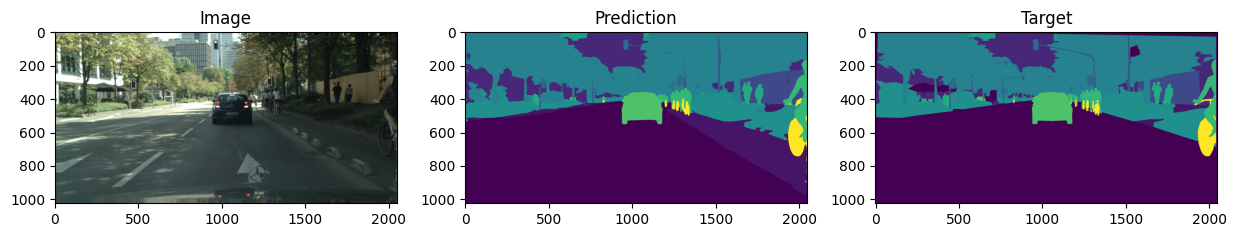

In [ ]:
val_plot(config,pidnet_m, dataset =cityscape_test, device = device, name = 'pidnet_m')

## 2.3. COmputing miou

In [ ]:
pixAcc_miou(config,
            model = pidnet_m,
            dataloader = train_dataloader,
            device = device,
            name = 'pidnet_m')

1it [00:02,  2.10s/it]

6/2975: miou: 0.6715413928031921


2it [00:03,  1.57s/it]

12/2975: miou: 0.7466800808906555


4it [00:04,  1.14it/s]

18/2975: miou: 0.756040096282959
24/2975: miou: 0.7595024704933167


5it [00:04,  1.33it/s]

30/2975: miou: 0.8032808899879456


7it [00:07,  1.08it/s]

36/2975: miou: 0.8388685584068298
42/2975: miou: 0.8357324004173279


9it [00:09,  1.05it/s]

48/2975: miou: 0.8316242098808289
54/2975: miou: 0.8346250653266907


11it [00:11,  1.02it/s]

60/2975: miou: 0.8325605988502502
66/2975: miou: 0.8308315873146057


13it [00:13,  1.01it/s]

72/2975: miou: 0.8327752947807312
78/2975: miou: 0.8345640301704407


14it [00:13,  1.18it/s]

84/2975: miou: 0.8314809799194336


16it [00:15,  1.22it/s]

90/2975: miou: 0.8317135572433472
96/2975: miou: 0.8314971923828125


18it [00:16,  1.31it/s]

102/2975: miou: 0.8311606645584106
108/2975: miou: 0.8311191201210022


20it [00:18,  1.25it/s]

114/2975: miou: 0.8362938761711121
120/2975: miou: 0.8397873044013977


22it [00:20,  1.12it/s]

126/2975: miou: 0.8412365317344666
132/2975: miou: 0.8414490818977356


24it [00:22,  1.07it/s]

138/2975: miou: 0.8399451375007629
144/2975: miou: 0.838524341583252


26it [00:23,  1.06it/s]

150/2975: miou: 0.8440597057342529
156/2975: miou: 0.8463807106018066


28it [00:26,  1.01it/s]

162/2975: miou: 0.8455860614776611
168/2975: miou: 0.8412766456604004


30it [00:28,  1.02it/s]

174/2975: miou: 0.8407477736473083
180/2975: miou: 0.8412942290306091


32it [00:30,  1.00it/s]

186/2975: miou: 0.8409103155136108
192/2975: miou: 0.8403043746948242


34it [00:32,  1.02it/s]

198/2975: miou: 0.84073406457901
204/2975: miou: 0.8401966691017151


36it [00:34,  1.01it/s]

210/2975: miou: 0.8417497873306274
216/2975: miou: 0.8401469588279724


38it [00:36,  1.00s/it]

222/2975: miou: 0.8381485342979431
228/2975: miou: 0.838716447353363


40it [00:38,  1.00s/it]

234/2975: miou: 0.8382578492164612
240/2975: miou: 0.8377895355224609


42it [00:40,  1.01it/s]

246/2975: miou: 0.8398780822753906
252/2975: miou: 0.8431342244148254


44it [00:42,  1.01it/s]

258/2975: miou: 0.8430024981498718
264/2975: miou: 0.8437232971191406


46it [00:44,  1.00s/it]

270/2975: miou: 0.8438623547554016
276/2975: miou: 0.8429548144340515


48it [00:45,  1.02it/s]

282/2975: miou: 0.8425776958465576
288/2975: miou: 0.8416975140571594


49it [00:46,  1.16it/s]

294/2975: miou: 0.842197597026825


51it [00:48,  1.19it/s]

300/2975: miou: 0.8429394960403442
306/2975: miou: 0.8429130911827087


53it [00:49,  1.32it/s]

312/2975: miou: 0.8414360284805298
318/2975: miou: 0.8419966697692871


54it [00:50,  1.47it/s]

324/2975: miou: 0.8423473834991455


56it [00:52,  1.19it/s]

330/2975: miou: 0.8433104157447815
336/2975: miou: 0.8438317179679871


58it [00:54,  1.08it/s]

342/2975: miou: 0.8441858887672424
348/2975: miou: 0.8441583514213562


60it [00:55,  1.06it/s]

354/2975: miou: 0.8440045714378357
360/2975: miou: 0.8435664772987366


61it [00:56,  1.22it/s]

366/2975: miou: 0.8443167805671692


63it [00:58,  1.20it/s]

372/2975: miou: 0.8473886251449585
378/2975: miou: 0.8472828269004822


65it [01:00,  1.08it/s]

384/2975: miou: 0.8469942808151245
390/2975: miou: 0.8469542264938354


67it [01:02,  1.04it/s]

396/2975: miou: 0.8462889790534973
402/2975: miou: 0.8457549214363098


69it [01:04,  1.04it/s]

408/2975: miou: 0.8452377319335938
414/2975: miou: 0.8450374603271484


70it [01:04,  1.21it/s]

420/2975: miou: 0.8456261157989502


71it [01:05,  1.37it/s]

426/2975: miou: 0.8453245759010315


73it [01:07,  1.15it/s]

432/2975: miou: 0.8458056449890137
438/2975: miou: 0.8472259640693665


75it [01:08,  1.26it/s]

444/2975: miou: 0.84673672914505
450/2975: miou: 0.84661865234375


76it [01:09,  1.42it/s]

456/2975: miou: 0.8461981415748596


77it [01:10,  1.13it/s]

462/2975: miou: 0.84701007604599


78it [01:10,  1.30it/s]

468/2975: miou: 0.8444747924804688


80it [01:13,  1.09it/s]

474/2975: miou: 0.8442559242248535
480/2975: miou: 0.8448085784912109


82it [01:15,  1.04it/s]

486/2975: miou: 0.8453578948974609
492/2975: miou: 0.8451973795890808


84it [01:17,  1.01it/s]

498/2975: miou: 0.8449152708053589
504/2975: miou: 0.8457756042480469


86it [01:19,  1.03it/s]

510/2975: miou: 0.8428067564964294
516/2975: miou: 0.8423600196838379


87it [01:19,  1.18it/s]

522/2975: miou: 0.8432741761207581


88it [01:20,  1.37it/s]

528/2975: miou: 0.8429164886474609


90it [01:22,  1.17it/s]

534/2975: miou: 0.8438712954521179
540/2975: miou: 0.8440628051757812


91it [01:22,  1.30it/s]

546/2975: miou: 0.8441669344902039


92it [01:23,  1.45it/s]

552/2975: miou: 0.8442884683609009


94it [01:25,  1.17it/s]

558/2975: miou: 0.8440378308296204
564/2975: miou: 0.8453376293182373


96it [01:27,  1.10it/s]

570/2975: miou: 0.8453586101531982
576/2975: miou: 0.84439617395401


98it [01:29,  1.05it/s]

582/2975: miou: 0.8440262675285339
588/2975: miou: 0.8435072898864746


100it [01:31,  1.04it/s]

594/2975: miou: 0.8429012298583984
600/2975: miou: 0.8432099223136902


101it [01:31,  1.20it/s]

606/2975: miou: 0.8435042500495911


102it [01:32,  1.34it/s]

612/2975: miou: 0.8445578217506409


104it [01:34,  1.16it/s]

618/2975: miou: 0.84511798620224
624/2975: miou: 0.8431506752967834


106it [01:36,  1.08it/s]

630/2975: miou: 0.8443483114242554
636/2975: miou: 0.8450108766555786


108it [01:38,  1.06it/s]

642/2975: miou: 0.8449442982673645
648/2975: miou: 0.8459232449531555


110it [01:40,  1.05it/s]

654/2975: miou: 0.8462806344032288
660/2975: miou: 0.8465373516082764


111it [01:40,  1.18it/s]

666/2975: miou: 0.8469945788383484


112it [01:41,  1.34it/s]

672/2975: miou: 0.8468073010444641


114it [01:43,  1.17it/s]

678/2975: miou: 0.8467649221420288
684/2975: miou: 0.8478026390075684


116it [01:45,  1.09it/s]

690/2975: miou: 0.8473394513130188
696/2975: miou: 0.847245454788208


117it [01:45,  1.23it/s]

702/2975: miou: 0.847186267375946


118it [01:46,  1.37it/s]

708/2975: miou: 0.846991777420044


120it [01:48,  1.16it/s]

714/2975: miou: 0.8472787737846375
720/2975: miou: 0.847221851348877


122it [01:50,  1.10it/s]

726/2975: miou: 0.8467357754707336
732/2975: miou: 0.8474857807159424


124it [01:51,  1.24it/s]

738/2975: miou: 0.8476360440254211
744/2975: miou: 0.8475083708763123


125it [01:52,  1.40it/s]

750/2975: miou: 0.8476801514625549


127it [01:54,  1.16it/s]

756/2975: miou: 0.8477994203567505
762/2975: miou: 0.8479000926017761


129it [01:55,  1.11it/s]

768/2975: miou: 0.8476415872573853
774/2975: miou: 0.8476198315620422


131it [01:58,  1.02it/s]

780/2975: miou: 0.8469509482383728
786/2975: miou: 0.8468011617660522


133it [01:59,  1.19it/s]

792/2975: miou: 0.8470143675804138
798/2975: miou: 0.8473719358444214


135it [02:01,  1.22it/s]

804/2975: miou: 0.8470809459686279
810/2975: miou: 0.8469553589820862


137it [02:02,  1.31it/s]

816/2975: miou: 0.846826434135437
822/2975: miou: 0.847653865814209


139it [02:04,  1.29it/s]

828/2975: miou: 0.8482807278633118
834/2975: miou: 0.8482540249824524


141it [02:06,  1.12it/s]

840/2975: miou: 0.8479924201965332
846/2975: miou: 0.8481853008270264


143it [02:08,  1.04it/s]

852/2975: miou: 0.8479591012001038
858/2975: miou: 0.8481037616729736


145it [02:10,  1.01it/s]

864/2975: miou: 0.8480968475341797
870/2975: miou: 0.8490773439407349


147it [02:12,  1.01it/s]

876/2975: miou: 0.849284827709198
882/2975: miou: 0.8494890928268433


149it [02:14,  1.01it/s]

888/2975: miou: 0.8511054515838623
894/2975: miou: 0.8509612083435059


151it [02:16,  1.00it/s]

900/2975: miou: 0.8512511849403381
906/2975: miou: 0.8511083722114563


153it [02:17,  1.18it/s]

912/2975: miou: 0.8511124849319458
918/2975: miou: 0.8501940369606018


154it [02:18,  1.35it/s]

924/2975: miou: 0.8504256010055542


156it [02:20,  1.13it/s]

930/2975: miou: 0.8508353233337402
936/2975: miou: 0.8507975339889526


158it [02:21,  1.26it/s]

942/2975: miou: 0.8505778312683105
948/2975: miou: 0.8500902056694031


159it [02:22,  1.39it/s]

954/2975: miou: 0.8462207913398743


160it [02:23,  1.17it/s]

960/2975: miou: 0.8462020754814148


161it [02:23,  1.30it/s]

966/2975: miou: 0.8461419939994812


163it [02:26,  1.06it/s]

972/2975: miou: 0.8459992408752441
978/2975: miou: 0.8460289835929871


165it [02:27,  1.21it/s]

984/2975: miou: 0.8469166159629822
990/2975: miou: 0.8467785716056824


166it [02:28,  1.37it/s]

996/2975: miou: 0.8467717170715332


167it [02:29,  1.15it/s]

1002/2975: miou: 0.846479594707489


168it [02:29,  1.31it/s]

1008/2975: miou: 0.8465133309364319


170it [02:32,  1.06it/s]

1014/2975: miou: 0.8461746573448181
1020/2975: miou: 0.84600430727005


172it [02:34,  1.02it/s]

1026/2975: miou: 0.8459224700927734
1032/2975: miou: 0.8458876609802246


174it [02:36,  1.02it/s]

1038/2975: miou: 0.8451762199401855
1044/2975: miou: 0.8449172973632812


175it [02:36,  1.20it/s]

1050/2975: miou: 0.8446632027626038


176it [02:37,  1.35it/s]

1056/2975: miou: 0.844973623752594


177it [02:38,  1.10it/s]

1062/2975: miou: 0.8450210094451904


178it [02:38,  1.27it/s]

1068/2975: miou: 0.8456462025642395


180it [02:41,  1.07it/s]

1074/2975: miou: 0.8457856178283691
1080/2975: miou: 0.8456777334213257


182it [02:43,  1.04it/s]

1086/2975: miou: 0.8457042574882507
1092/2975: miou: 0.8459186553955078


184it [02:44,  1.18it/s]

1098/2975: miou: 0.8460885882377625
1104/2975: miou: 0.8458802103996277


185it [02:45,  1.34it/s]

1110/2975: miou: 0.8461934328079224


187it [02:47,  1.18it/s]

1116/2975: miou: 0.8462584614753723
1122/2975: miou: 0.846461832523346


188it [02:47,  1.34it/s]

1128/2975: miou: 0.846321702003479


189it [02:48,  1.47it/s]

1134/2975: miou: 0.8463245034217834


191it [02:50,  1.21it/s]

1140/2975: miou: 0.8461717367172241
1146/2975: miou: 0.8461283445358276


193it [02:52,  1.12it/s]

1152/2975: miou: 0.8461507558822632
1158/2975: miou: 0.8461768627166748


195it [02:54,  1.04it/s]

1164/2975: miou: 0.8465240597724915
1170/2975: miou: 0.8464577198028564


197it [02:56,  1.03it/s]

1176/2975: miou: 0.8464264869689941
1182/2975: miou: 0.846940815448761


198it [02:56,  1.20it/s]

1188/2975: miou: 0.8468143343925476


199it [02:57,  1.39it/s]

1194/2975: miou: 0.8470367789268494


201it [02:59,  1.15it/s]

1200/2975: miou: 0.8473283052444458
1206/2975: miou: 0.8477489352226257


203it [03:01,  1.07it/s]

1212/2975: miou: 0.8482205271720886
1218/2975: miou: 0.8482017517089844


205it [03:02,  1.22it/s]

1224/2975: miou: 0.8481273651123047
1230/2975: miou: 0.8481732606887817


206it [03:03,  1.41it/s]

1236/2975: miou: 0.8482290506362915


208it [03:05,  1.15it/s]

1242/2975: miou: 0.8482585549354553
1248/2975: miou: 0.8487725257873535


210it [03:06,  1.10it/s]

1254/2975: miou: 0.8488011360168457
1260/2975: miou: 0.8488087058067322


211it [03:07,  1.24it/s]

1266/2975: miou: 0.8486015200614929


212it [03:08,  1.39it/s]

1272/2975: miou: 0.8486072421073914


214it [03:10,  1.18it/s]

1278/2975: miou: 0.8484677672386169
1284/2975: miou: 0.8491098284721375


216it [03:12,  1.08it/s]

1290/2975: miou: 0.8490901589393616
1296/2975: miou: 0.8489305377006531


217it [03:12,  1.24it/s]

1302/2975: miou: 0.8487528562545776


219it [03:14,  1.21it/s]

1308/2975: miou: 0.8487582206726074
1314/2975: miou: 0.8490659594535828


221it [03:16,  1.10it/s]

1320/2975: miou: 0.8490128517150879
1326/2975: miou: 0.8487780690193176


223it [03:18,  1.06it/s]

1332/2975: miou: 0.8488103151321411
1338/2975: miou: 0.8486350178718567


225it [03:19,  1.22it/s]

1344/2975: miou: 0.8485481142997742
1350/2975: miou: 0.8486610054969788


226it [03:20,  1.38it/s]

1356/2975: miou: 0.8484407663345337


227it [03:21,  1.17it/s]

1362/2975: miou: 0.8475887775421143


229it [03:22,  1.47it/s]

1368/2975: miou: 0.8475785255432129
1374/2975: miou: 0.8477261066436768


230it [03:23,  1.39it/s]

1380/2975: miou: 0.8475871682167053


232it [03:25,  1.14it/s]

1386/2975: miou: 0.8475152254104614
1392/2975: miou: 0.8473677635192871


234it [03:27,  1.06it/s]

1398/2975: miou: 0.8474590182304382
1404/2975: miou: 0.8474819660186768


236it [03:28,  1.21it/s]

1410/2975: miou: 0.847590982913971
1416/2975: miou: 0.8480714559555054


237it [03:29,  1.37it/s]

1422/2975: miou: 0.8489473462104797


238it [03:30,  1.16it/s]

1428/2975: miou: 0.8495242595672607


239it [03:30,  1.31it/s]

1434/2975: miou: 0.8495631217956543


241it [03:33,  1.05it/s]

1440/2975: miou: 0.8496292233467102
1446/2975: miou: 0.8499613404273987


243it [03:35,  1.04it/s]

1452/2975: miou: 0.8501065969467163
1458/2975: miou: 0.8500166535377502


245it [03:37,  1.01it/s]

1464/2975: miou: 0.8500322103500366
1470/2975: miou: 0.85003662109375


247it [03:39,  1.02it/s]

1476/2975: miou: 0.8499710559844971
1482/2975: miou: 0.8501152396202087


248it [03:39,  1.17it/s]

1488/2975: miou: 0.8501529693603516


250it [03:41,  1.18it/s]

1494/2975: miou: 0.8501014709472656
1500/2975: miou: 0.8501246571540833


252it [03:43,  1.08it/s]

1506/2975: miou: 0.850080668926239
1512/2975: miou: 0.8500626087188721


254it [03:45,  1.06it/s]

1518/2975: miou: 0.8498752117156982
1524/2975: miou: 0.8497876524925232


256it [03:47,  1.03it/s]

1530/2975: miou: 0.8496158123016357
1536/2975: miou: 0.8495213389396667


258it [03:49,  1.01it/s]

1542/2975: miou: 0.8494541645050049
1548/2975: miou: 0.8496814370155334


259it [03:49,  1.14it/s]

1554/2975: miou: 0.8495216369628906


260it [03:50,  1.31it/s]

1560/2975: miou: 0.8494713306427002


261it [03:51,  1.13it/s]

1566/2975: miou: 0.849301815032959


263it [03:52,  1.40it/s]

1572/2975: miou: 0.8498850464820862
1578/2975: miou: 0.8497259020805359


264it [03:52,  1.53it/s]

1584/2975: miou: 0.8496322631835938


266it [03:55,  1.17it/s]

1590/2975: miou: 0.8495113849639893
1596/2975: miou: 0.8497139811515808


268it [03:56,  1.30it/s]

1602/2975: miou: 0.8497083783149719
1608/2975: miou: 0.8498140573501587


269it [03:57,  1.45it/s]

1614/2975: miou: 0.8506345152854919


271it [03:59,  1.18it/s]

1620/2975: miou: 0.8505039215087891
1626/2975: miou: 0.8504786491394043


273it [04:01,  1.07it/s]

1632/2975: miou: 0.8503564596176147
1638/2975: miou: 0.850510835647583


275it [04:02,  1.24it/s]

1644/2975: miou: 0.8506025075912476
1650/2975: miou: 0.8506451845169067


276it [04:03,  1.42it/s]

1656/2975: miou: 0.8506280183792114


278it [04:05,  1.15it/s]

1662/2975: miou: 0.850509524345398
1668/2975: miou: 0.850551187992096


280it [04:07,  1.07it/s]

1674/2975: miou: 0.8505599498748779
1680/2975: miou: 0.8505297303199768


282it [04:09,  1.05it/s]

1686/2975: miou: 0.8505806922912598
1692/2975: miou: 0.8502346873283386


284it [04:11,  1.02it/s]

1698/2975: miou: 0.8503058552742004
1704/2975: miou: 0.8503017425537109


286it [04:12,  1.04it/s]

1710/2975: miou: 0.8504079580307007
1716/2975: miou: 0.8503385782241821


288it [04:15,  1.00it/s]

1722/2975: miou: 0.850169837474823
1728/2975: miou: 0.8502292633056641


290it [04:17,  1.00s/it]

1734/2975: miou: 0.8498489260673523
1740/2975: miou: 0.849997341632843


292it [04:18,  1.19it/s]

1746/2975: miou: 0.8499054908752441
1752/2975: miou: 0.8499494791030884


293it [04:19,  1.33it/s]

1758/2975: miou: 0.8497422933578491


295it [04:21,  1.16it/s]

1764/2975: miou: 0.8498193025588989
1770/2975: miou: 0.8497890830039978


297it [04:23,  1.07it/s]

1776/2975: miou: 0.8496027588844299
1782/2975: miou: 0.8493900299072266


299it [04:25,  1.03it/s]

1788/2975: miou: 0.8492498993873596
1794/2975: miou: 0.8488211631774902


300it [04:25,  1.21it/s]

1800/2975: miou: 0.8489220142364502


302it [04:27,  1.19it/s]

1806/2975: miou: 0.8486049771308899
1812/2975: miou: 0.8482387065887451


304it [04:29,  1.13it/s]

1818/2975: miou: 0.8481006622314453
1824/2975: miou: 0.8482196927070618


306it [04:31,  1.05it/s]

1830/2975: miou: 0.8482382893562317
1836/2975: miou: 0.8482332825660706


308it [04:33,  1.03it/s]

1842/2975: miou: 0.8481830954551697
1848/2975: miou: 0.8488268852233887


310it [04:35,  1.00s/it]

1854/2975: miou: 0.8487623333930969
1860/2975: miou: 0.8486108183860779


312it [04:37,  1.00s/it]

1866/2975: miou: 0.8487076759338379
1872/2975: miou: 0.8487231731414795


314it [04:39,  1.00s/it]

1878/2975: miou: 0.8487030863761902
1884/2975: miou: 0.8487812876701355


316it [04:41,  1.00it/s]

1890/2975: miou: 0.8488015532493591
1896/2975: miou: 0.8486844897270203


318it [04:42,  1.18it/s]

1902/2975: miou: 0.848686695098877
1908/2975: miou: 0.8489612936973572


319it [04:43,  1.36it/s]

1914/2975: miou: 0.8486615419387817


321it [04:45,  1.14it/s]

1920/2975: miou: 0.8487852215766907
1926/2975: miou: 0.8488809466362


323it [04:47,  1.08it/s]

1932/2975: miou: 0.8488068580627441
1938/2975: miou: 0.8488131165504456


325it [04:49,  1.03it/s]

1944/2975: miou: 0.8488538861274719
1950/2975: miou: 0.8490729928016663


327it [04:50,  1.21it/s]

1956/2975: miou: 0.848975419998169
1962/2975: miou: 0.8490989208221436


328it [04:51,  1.38it/s]

1968/2975: miou: 0.8491020202636719


329it [04:52,  1.15it/s]

1974/2975: miou: 0.8490778207778931


330it [04:52,  1.35it/s]

1980/2975: miou: 0.8491312265396118


332it [04:54,  1.34it/s]

1986/2975: miou: 0.8491039276123047
1992/2975: miou: 0.8490740060806274


334it [04:56,  1.14it/s]

1998/2975: miou: 0.8491583466529846
2004/2975: miou: 0.8488508462905884


336it [04:57,  1.27it/s]

2010/2975: miou: 0.8488942980766296
2016/2975: miou: 0.8489581942558289


337it [04:58,  1.43it/s]

2022/2975: miou: 0.8492158651351929


339it [05:00,  1.19it/s]

2028/2975: miou: 0.8492259979248047
2034/2975: miou: 0.8491957783699036


341it [05:02,  1.07it/s]

2040/2975: miou: 0.8493448495864868
2046/2975: miou: 0.8492229580879211


342it [05:02,  1.25it/s]

2052/2975: miou: 0.8495144844055176


343it [05:03,  1.38it/s]

2058/2975: miou: 0.8493762016296387


344it [05:04,  1.19it/s]

2064/2975: miou: 0.8491678833961487


345it [05:04,  1.36it/s]

2070/2975: miou: 0.8494107127189636


347it [05:07,  1.08it/s]

2076/2975: miou: 0.8493586182594299
2082/2975: miou: 0.8492706418037415


349it [05:09,  1.04it/s]

2088/2975: miou: 0.8492453694343567
2094/2975: miou: 0.849247395992279


351it [05:11,  1.00s/it]

2100/2975: miou: 0.8492422699928284
2106/2975: miou: 0.8499367237091064


353it [05:13,  1.02it/s]

2112/2975: miou: 0.8499458432197571
2118/2975: miou: 0.8502399325370789


354it [05:13,  1.18it/s]

2124/2975: miou: 0.8499921560287476


355it [05:14,  1.33it/s]

2130/2975: miou: 0.8498878479003906


357it [05:16,  1.15it/s]

2136/2975: miou: 0.8498972058296204
2142/2975: miou: 0.8498419523239136


359it [05:18,  1.09it/s]

2148/2975: miou: 0.8501302003860474
2154/2975: miou: 0.8500874042510986


361it [05:20,  1.06it/s]

2160/2975: miou: 0.8506824970245361
2166/2975: miou: 0.850782573223114


363it [05:22,  1.04it/s]

2172/2975: miou: 0.8507059216499329
2178/2975: miou: 0.8508988618850708


365it [05:24,  1.00s/it]

2184/2975: miou: 0.8508328795433044
2190/2975: miou: 0.8501483798027039


367it [05:26,  1.02it/s]

2196/2975: miou: 0.8500555753707886
2202/2975: miou: 0.8501392006874084


368it [05:26,  1.16it/s]

2208/2975: miou: 0.8501447439193726


369it [05:27,  1.32it/s]

2214/2975: miou: 0.8501906991004944


370it [05:28,  1.11it/s]

2220/2975: miou: 0.8502827882766724


372it [05:29,  1.39it/s]

2226/2975: miou: 0.8503524661064148
2232/2975: miou: 0.8503840565681458


373it [05:29,  1.52it/s]

2238/2975: miou: 0.8500552177429199


375it [05:32,  1.17it/s]

2244/2975: miou: 0.850017249584198
2250/2975: miou: 0.8500919342041016


377it [05:34,  1.10it/s]

2256/2975: miou: 0.8500545024871826
2262/2975: miou: 0.8501165509223938


379it [05:36,  1.02it/s]

2268/2975: miou: 0.8500916361808777
2274/2975: miou: 0.850130558013916


381it [05:38,  1.00it/s]

2280/2975: miou: 0.8499252796173096
2286/2975: miou: 0.8498396873474121


383it [05:40,  1.02it/s]

2292/2975: miou: 0.8499298095703125
2298/2975: miou: 0.8499246835708618


385it [05:42,  1.01it/s]

2304/2975: miou: 0.8498737215995789
2310/2975: miou: 0.8499060273170471


386it [05:42,  1.19it/s]

2316/2975: miou: 0.8498579263687134


387it [05:43,  1.38it/s]

2322/2975: miou: 0.8498708009719849


389it [05:45,  1.14it/s]

2328/2975: miou: 0.8498938679695129
2334/2975: miou: 0.8498672842979431


391it [05:47,  1.08it/s]

2340/2975: miou: 0.849844753742218
2346/2975: miou: 0.8498626351356506


393it [05:49,  1.03it/s]

2352/2975: miou: 0.8496890664100647
2358/2975: miou: 0.849645733833313


395it [05:51,  1.03it/s]

2364/2975: miou: 0.8496271371841431
2370/2975: miou: 0.8496631979942322


397it [05:53,  1.02it/s]

2376/2975: miou: 0.8505713939666748
2382/2975: miou: 0.8505752086639404


398it [05:53,  1.19it/s]

2388/2975: miou: 0.8505231738090515


400it [05:55,  1.20it/s]

2394/2975: miou: 0.8504263162612915
2400/2975: miou: 0.850334644317627


402it [05:57,  1.12it/s]

2406/2975: miou: 0.8503426909446716
2412/2975: miou: 0.8503921627998352


403it [05:57,  1.25it/s]

2418/2975: miou: 0.8503937721252441


404it [05:58,  1.39it/s]

2424/2975: miou: 0.8503451347351074


406it [06:00,  1.17it/s]

2430/2975: miou: 0.8505018353462219
2436/2975: miou: 0.8505369424819946


408it [06:02,  1.11it/s]

2442/2975: miou: 0.8505337238311768
2448/2975: miou: 0.8506761789321899


410it [06:04,  1.06it/s]

2454/2975: miou: 0.850659191608429
2460/2975: miou: 0.8506484627723694


411it [06:04,  1.20it/s]

2466/2975: miou: 0.8506304025650024


412it [06:05,  1.35it/s]

2472/2975: miou: 0.8507935404777527


414it [06:07,  1.18it/s]

2478/2975: miou: 0.850756824016571
2484/2975: miou: 0.8508120179176331


416it [06:09,  1.09it/s]

2490/2975: miou: 0.851050615310669
2496/2975: miou: 0.8510228395462036


418it [06:10,  1.07it/s]

2502/2975: miou: 0.851386547088623
2508/2975: miou: 0.8514797687530518


419it [06:11,  1.23it/s]

2514/2975: miou: 0.8513761758804321


420it [06:12,  1.39it/s]

2520/2975: miou: 0.8512486815452576


422it [06:14,  1.13it/s]

2526/2975: miou: 0.8512492179870605
2532/2975: miou: 0.851159930229187


424it [06:15,  1.10it/s]

2538/2975: miou: 0.8515761494636536
2544/2975: miou: 0.8515746593475342


425it [06:16,  1.24it/s]

2550/2975: miou: 0.8514774441719055


426it [06:17,  1.41it/s]

2556/2975: miou: 0.8513503670692444


428it [06:19,  1.19it/s]

2562/2975: miou: 0.8514611124992371
2568/2975: miou: 0.8516307473182678


430it [06:21,  1.10it/s]

2574/2975: miou: 0.851730465888977
2580/2975: miou: 0.851780354976654


431it [06:21,  1.25it/s]

2586/2975: miou: 0.8518367409706116


432it [06:22,  1.42it/s]

2592/2975: miou: 0.8517768979072571


433it [06:23,  1.13it/s]

2598/2975: miou: 0.8517718315124512


434it [06:23,  1.31it/s]

2604/2975: miou: 0.8517193794250488


436it [06:26,  1.08it/s]

2610/2975: miou: 0.8517675995826721
2616/2975: miou: 0.8517693877220154


437it [06:26,  1.23it/s]

2622/2975: miou: 0.8504894375801086


439it [06:28,  1.23it/s]

2628/2975: miou: 0.8506026268005371
2634/2975: miou: 0.8505565524101257


441it [06:30,  1.10it/s]

2640/2975: miou: 0.8505014181137085
2646/2975: miou: 0.8505218625068665


443it [06:32,  1.06it/s]

2652/2975: miou: 0.8505510091781616
2658/2975: miou: 0.8505425453186035


445it [06:34,  1.03it/s]

2664/2975: miou: 0.8507498502731323
2670/2975: miou: 0.8506702780723572


447it [06:36,  1.01it/s]

2676/2975: miou: 0.850723385810852
2682/2975: miou: 0.8507241606712341


449it [06:38,  1.01s/it]

2688/2975: miou: 0.8507301807403564
2694/2975: miou: 0.8507628440856934


451it [06:39,  1.03it/s]

2700/2975: miou: 0.8507240414619446
2706/2975: miou: 0.8507116436958313


452it [06:40,  1.18it/s]

2712/2975: miou: 0.8507437705993652


453it [06:41,  1.36it/s]

2718/2975: miou: 0.8507463335990906


455it [06:43,  1.13it/s]

2724/2975: miou: 0.8507471680641174
2730/2975: miou: 0.8507439494132996


457it [06:45,  1.09it/s]

2736/2975: miou: 0.8508076667785645
2742/2975: miou: 0.8507850766181946


459it [06:47,  1.05it/s]

2748/2975: miou: 0.8509131073951721
2754/2975: miou: 0.8509160280227661


460it [06:47,  1.19it/s]

2760/2975: miou: 0.8509564399719238


461it [06:48,  1.36it/s]

2766/2975: miou: 0.8509612679481506


463it [06:50,  1.18it/s]

2772/2975: miou: 0.851068913936615
2778/2975: miou: 0.8510623574256897


464it [06:50,  1.32it/s]

2784/2975: miou: 0.8510212898254395


465it [06:51,  1.50it/s]

2790/2975: miou: 0.8510001301765442


467it [06:53,  1.21it/s]

2796/2975: miou: 0.8510868549346924
2802/2975: miou: 0.851018488407135


468it [06:53,  1.32it/s]

2808/2975: miou: 0.8510033488273621


469it [06:54,  1.47it/s]

2814/2975: miou: 0.8509941101074219


471it [06:56,  1.23it/s]

2820/2975: miou: 0.8509693145751953
2826/2975: miou: 0.8508268594741821


472it [06:56,  1.35it/s]

2832/2975: miou: 0.8507678508758545


473it [06:57,  1.50it/s]

2838/2975: miou: 0.8504465818405151


475it [06:59,  1.23it/s]

2844/2975: miou: 0.8504129648208618
2850/2975: miou: 0.8504176139831543


476it [06:59,  1.35it/s]

2856/2975: miou: 0.8503423929214478


477it [07:00,  1.48it/s]

2862/2975: miou: 0.8502798676490784


479it [07:02,  1.20it/s]

2868/2975: miou: 0.8504921793937683
2874/2975: miou: 0.8505781888961792


481it [07:04,  1.11it/s]

2880/2975: miou: 0.8506877422332764
2886/2975: miou: 0.8505483865737915


483it [07:06,  1.05it/s]

2892/2975: miou: 0.8505654335021973
2898/2975: miou: 0.8506602048873901


485it [07:08,  1.04it/s]

2904/2975: miou: 0.8505344390869141
2910/2975: miou: 0.8507323265075684


487it [07:10,  1.02it/s]

2916/2975: miou: 0.850878894329071
2922/2975: miou: 0.8509910106658936


489it [07:12,  1.03it/s]

2928/2975: miou: 0.8511131405830383
2934/2975: miou: 0.8512759208679199


490it [07:12,  1.19it/s]

2940/2975: miou: 0.8513064384460449


492it [07:14,  1.19it/s]

2946/2975: miou: 0.8513109087944031
2952/2975: miou: 0.8513326048851013


494it [07:16,  1.09it/s]

2958/2975: miou: 0.8513908386230469
2964/2975: miou: 0.8514225482940674


496it [07:17,  1.13it/s]

2970/2975: miou: 0.8513707518577576
2976/2975: miou: 0.8513036966323853


tensor([0.9874, 0.8971, 0.9402, 0.8011, 0.8109, 0.6601, 0.7137, 0.8146, 0.9327,
        0.8319, 0.9540, 0.8652, 0.7267, 0.9568, 0.8738, 0.9247, 0.9271, 0.7646,
        0.7923])

In [ ]:
pixAcc_miou2(config,
            model = pidnet_m,
            dataloader = test_dataloader,
            device = device,
            name = 'pidnet_m')

84it [01:18,  1.08it/s]


Pixel Accuracy: 0.9748143095251156
miou: 0.8681435585021973


In [ ]:
pixAcc_miou3(config,
            model = pidnet_m,
            dataloader = test_dataloader,
            device = device,
            name = 'pidnet_m')

84it [01:22,  1.02it/s]


Pixel Accuracy: 0.9748143095251156
miou: 0.8681435585021973


# 3. PIDNet L

- Paper: https://arxiv.org/pdf/2206.02066
- Code: https://github.com/XuJiacong/PIDNet

## 3.1. Getting the model

In [ ]:
model = torch.load('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/pretrained_models/PIDNet/PIDNet_L_Cityscapes_test.pt',map_location=device)
pidnet_l = get_pred_model(name = 'pidnet_l', num_classes = 19).to(device)
if 'state_dict' in model:
    model = model['state_dict']
model_dict = pidnet_l.state_dict()
model = {k[6:]: v for k, v in model.items() # k[6:] to start after model. in key names
                    if k[6:] in model_dict.keys()}

pidnet_l.load_state_dict(model)
pidnet_l.eval()
print('PIDNet Model loaded')

<ipython-input-12-6825faebb5bd>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/pret

PIDNet Model loaded


## 3.2. Plotting random outputs

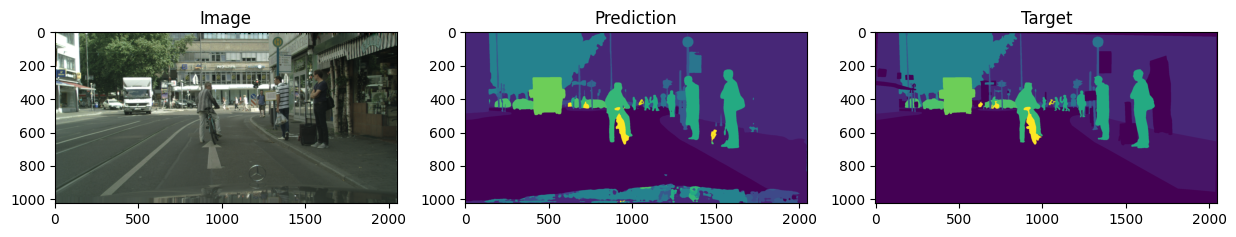

In [ ]:
val_plot(config,pidnet_l, dataset =cityscape_test, device = device,name = 'pidnet_l')

## 3.3. Computing miou

In [ ]:
pixAcc_miou(config,
            model = pidnet_l,
            dataloader = train_dataloader,
            device = device,
            name = 'pidnet_l')

1it [00:02,  2.32s/it]

6/2975: miou: 0.7812488079071045


3it [00:04,  1.36s/it]

12/2975: miou: 0.7824808955192566
18/2975: miou: 0.7767147421836853


5it [00:06,  1.19s/it]

24/2975: miou: 0.8319512605667114
30/2975: miou: 0.8858338594436646


7it [00:08,  1.08s/it]

36/2975: miou: 0.8772637248039246
42/2975: miou: 0.8718523979187012


9it [00:10,  1.12it/s]

48/2975: miou: 0.8809754252433777
54/2975: miou: 0.8870663046836853


11it [00:11,  1.20it/s]

60/2975: miou: 0.882983386516571
66/2975: miou: 0.8830769062042236


13it [00:13,  1.11it/s]

72/2975: miou: 0.8865990042686462
78/2975: miou: 0.8828873634338379


15it [00:15,  1.07it/s]

84/2975: miou: 0.8826317191123962
90/2975: miou: 0.8842772245407104


17it [00:17,  1.03it/s]

96/2975: miou: 0.8826676607131958
102/2975: miou: 0.8857612609863281


19it [00:19,  1.03it/s]

108/2975: miou: 0.8860891461372375
114/2975: miou: 0.8891785144805908


21it [00:21,  1.02it/s]

120/2975: miou: 0.889101505279541
126/2975: miou: 0.8894962668418884


23it [00:23,  1.01it/s]

132/2975: miou: 0.8903444409370422
138/2975: miou: 0.8901095986366272


24it [00:24,  1.14it/s]

144/2975: miou: 0.8907476663589478


26it [00:25,  1.20it/s]

150/2975: miou: 0.8900749683380127
156/2975: miou: 0.8906275033950806


28it [00:27,  1.14it/s]

162/2975: miou: 0.8899138569831848
168/2975: miou: 0.8886294364929199


30it [00:29,  1.08it/s]

174/2975: miou: 0.8908493518829346
180/2975: miou: 0.8898142576217651


32it [00:31,  1.05it/s]

186/2975: miou: 0.8900995850563049
192/2975: miou: 0.8899851441383362


34it [00:33,  1.03it/s]

198/2975: miou: 0.8916817903518677
204/2975: miou: 0.8922609090805054


36it [00:35,  1.03it/s]

210/2975: miou: 0.8926122784614563
216/2975: miou: 0.8931208252906799


38it [00:37,  1.02it/s]

222/2975: miou: 0.8933312296867371
228/2975: miou: 0.893199622631073


40it [00:39,  1.02it/s]

234/2975: miou: 0.8929368257522583
240/2975: miou: 0.8927252888679504


42it [00:41,  1.01s/it]

246/2975: miou: 0.8918712735176086
252/2975: miou: 0.8918066620826721


44it [00:43,  1.01it/s]

258/2975: miou: 0.8925663828849792
264/2975: miou: 0.8922893404960632


45it [00:44,  1.14it/s]

270/2975: miou: 0.8934404253959656


46it [00:44,  1.26it/s]

276/2975: miou: 0.8931781649589539


47it [00:45,  1.17it/s]

282/2975: miou: 0.8929541707038879


49it [00:47,  1.35it/s]

288/2975: miou: 0.8931613564491272
294/2975: miou: 0.8933752775192261


51it [00:48,  1.31it/s]

300/2975: miou: 0.8932726979255676
306/2975: miou: 0.8940759897232056


53it [00:50,  1.13it/s]

312/2975: miou: 0.8933406472206116
318/2975: miou: 0.8933975100517273


54it [00:51,  1.24it/s]

324/2975: miou: 0.8933060169219971


56it [00:52,  1.25it/s]

330/2975: miou: 0.8934146761894226
336/2975: miou: 0.8931159973144531


58it [00:54,  1.18it/s]

342/2975: miou: 0.8933035135269165
348/2975: miou: 0.8929723501205444


60it [00:56,  1.07it/s]

354/2975: miou: 0.8936854004859924
360/2975: miou: 0.892721951007843


62it [00:58,  1.00it/s]

366/2975: miou: 0.8924508094787598
372/2975: miou: 0.892216145992279


64it [01:00,  1.01s/it]

378/2975: miou: 0.8921676278114319
384/2975: miou: 0.8921036720275879


66it [01:02,  1.02s/it]

390/2975: miou: 0.8923279643058777
396/2975: miou: 0.8919469714164734


68it [01:04,  1.01s/it]

402/2975: miou: 0.8915496468544006
408/2975: miou: 0.891577959060669


70it [01:06,  1.02s/it]

414/2975: miou: 0.8931824564933777
420/2975: miou: 0.8933413624763489


72it [01:08,  1.01s/it]

426/2975: miou: 0.8932501077651978
432/2975: miou: 0.8928341865539551


74it [01:10,  1.02s/it]

438/2975: miou: 0.8927408456802368
444/2975: miou: 0.8925445079803467


76it [01:12,  1.02s/it]

450/2975: miou: 0.8924853801727295
456/2975: miou: 0.8926188945770264


78it [01:14,  1.03s/it]

462/2975: miou: 0.8925445079803467
468/2975: miou: 0.8924732208251953


80it [01:16,  1.03it/s]

474/2975: miou: 0.8920625448226929
480/2975: miou: 0.892471194267273


82it [01:18,  1.03it/s]

486/2975: miou: 0.8929668068885803
492/2975: miou: 0.8926560282707214


83it [01:19,  1.15it/s]

498/2975: miou: 0.8925837278366089


85it [01:20,  1.24it/s]

504/2975: miou: 0.8926199078559875
510/2975: miou: 0.8929095268249512


87it [01:22,  1.08it/s]

516/2975: miou: 0.8927346467971802
522/2975: miou: 0.8928964734077454


89it [01:24,  1.19it/s]

528/2975: miou: 0.8927181363105774
534/2975: miou: 0.8923618197441101


91it [01:25,  1.21it/s]

540/2975: miou: 0.8919305205345154
546/2975: miou: 0.891834557056427


92it [01:26,  1.21it/s]

552/2975: miou: 0.8920936584472656


93it [01:27,  1.31it/s]

558/2975: miou: 0.892203688621521


94it [01:27,  1.37it/s]

564/2975: miou: 0.8919843435287476


96it [01:29,  1.49it/s]

570/2975: miou: 0.8921540975570679
576/2975: miou: 0.892641544342041


98it [01:30,  1.40it/s]

582/2975: miou: 0.8922704458236694
588/2975: miou: 0.8921601176261902


100it [01:32,  1.20it/s]

594/2975: miou: 0.8919901847839355
600/2975: miou: 0.8918019533157349


102it [01:34,  1.09it/s]

606/2975: miou: 0.8916569948196411
612/2975: miou: 0.89178866147995


104it [01:36,  1.05it/s]

618/2975: miou: 0.8917151093482971
624/2975: miou: 0.8913216590881348


105it [01:37,  1.17it/s]

630/2975: miou: 0.8913101553916931


107it [01:38,  1.26it/s]

636/2975: miou: 0.891304612159729
642/2975: miou: 0.8911761045455933


109it [01:40,  1.30it/s]

648/2975: miou: 0.8909881114959717
654/2975: miou: 0.8907167315483093


111it [01:41,  1.30it/s]

660/2975: miou: 0.8903911113739014
666/2975: miou: 0.890414297580719


112it [01:42,  1.23it/s]

672/2975: miou: 0.8909476399421692


113it [01:43,  1.32it/s]

678/2975: miou: 0.8909395337104797


115it [01:44,  1.34it/s]

684/2975: miou: 0.8906251788139343
690/2975: miou: 0.8904788494110107


117it [01:46,  1.16it/s]

696/2975: miou: 0.8906978964805603
702/2975: miou: 0.8907554745674133


118it [01:47,  1.29it/s]

708/2975: miou: 0.8906173706054688


119it [01:47,  1.38it/s]

714/2975: miou: 0.8904176950454712


120it [01:48,  1.19it/s]

720/2975: miou: 0.8902900218963623


122it [01:50,  1.35it/s]

726/2975: miou: 0.8902927041053772
732/2975: miou: 0.8901679515838623


124it [01:51,  1.36it/s]

738/2975: miou: 0.8901565074920654
744/2975: miou: 0.890112042427063


126it [01:53,  1.12it/s]

750/2975: miou: 0.8901962637901306
756/2975: miou: 0.8902469277381897


128it [01:55,  1.22it/s]

762/2975: miou: 0.8904237151145935
768/2975: miou: 0.8908187747001648


130it [01:56,  1.25it/s]

774/2975: miou: 0.8907411694526672
780/2975: miou: 0.8912598490715027


132it [01:58,  1.11it/s]

786/2975: miou: 0.8913859128952026
792/2975: miou: 0.8909862637519836


134it [02:00,  1.02it/s]

798/2975: miou: 0.8907981514930725
804/2975: miou: 0.8909652829170227


136it [02:02,  1.00s/it]

810/2975: miou: 0.89105224609375
816/2975: miou: 0.8911055326461792


138it [02:04,  1.04it/s]

822/2975: miou: 0.8903207182884216
828/2975: miou: 0.8911116719245911


140it [02:06,  1.04it/s]

834/2975: miou: 0.8909828066825867
840/2975: miou: 0.8907473683357239


142it [02:08,  1.03it/s]

846/2975: miou: 0.8904592394828796
852/2975: miou: 0.890966534614563


144it [02:10,  1.04it/s]

858/2975: miou: 0.8909039497375488
864/2975: miou: 0.8908930420875549


145it [02:11,  1.17it/s]

870/2975: miou: 0.8909049034118652


147it [02:12,  1.22it/s]

876/2975: miou: 0.8908606171607971
882/2975: miou: 0.8905488848686218


149it [02:14,  1.06it/s]

888/2975: miou: 0.8905544281005859
894/2975: miou: 0.8907448649406433


151it [02:16,  1.21it/s]

900/2975: miou: 0.890680193901062
906/2975: miou: 0.8908808827400208


153it [02:17,  1.22it/s]

912/2975: miou: 0.8907140493392944
918/2975: miou: 0.8904374837875366


155it [02:19,  1.14it/s]

924/2975: miou: 0.890580952167511
930/2975: miou: 0.8905997276306152


157it [02:21,  1.03it/s]

936/2975: miou: 0.8905028104782104
942/2975: miou: 0.8905011415481567


159it [02:23,  1.19it/s]

948/2975: miou: 0.8904615640640259
954/2975: miou: 0.8903869986534119


161it [02:24,  1.23it/s]

960/2975: miou: 0.8904675841331482
966/2975: miou: 0.8904165029525757


163it [02:26,  1.07it/s]

972/2975: miou: 0.8904111981391907
978/2975: miou: 0.8909221291542053


165it [02:28,  1.04it/s]

984/2975: miou: 0.8912174701690674
990/2975: miou: 0.891098141670227


167it [02:30,  1.03it/s]

996/2975: miou: 0.8915451169013977
1002/2975: miou: 0.8914058208465576


168it [02:31,  1.16it/s]

1008/2975: miou: 0.8914319276809692


170it [02:32,  1.21it/s]

1014/2975: miou: 0.8918382525444031
1020/2975: miou: 0.8917528390884399


172it [02:34,  1.14it/s]

1026/2975: miou: 0.8917314410209656
1032/2975: miou: 0.8918537497520447


174it [02:36,  1.07it/s]

1038/2975: miou: 0.8919242024421692
1044/2975: miou: 0.8879464864730835


175it [02:37,  1.17it/s]

1050/2975: miou: 0.8880971670150757


177it [02:38,  1.21it/s]

1056/2975: miou: 0.8879668712615967
1062/2975: miou: 0.8880038261413574


179it [02:40,  1.14it/s]

1068/2975: miou: 0.8880470395088196
1074/2975: miou: 0.8878245949745178


181it [02:42,  1.07it/s]

1080/2975: miou: 0.8878536224365234
1086/2975: miou: 0.8878816366195679


183it [02:44,  1.06it/s]

1092/2975: miou: 0.8880426287651062
1098/2975: miou: 0.8870421051979065


184it [02:45,  1.19it/s]

1104/2975: miou: 0.8870453238487244


185it [02:45,  1.29it/s]

1110/2975: miou: 0.8867284655570984


186it [02:46,  1.16it/s]

1116/2975: miou: 0.8868188261985779


188it [02:48,  1.35it/s]

1122/2975: miou: 0.8868522644042969
1128/2975: miou: 0.886832058429718


190it [02:49,  1.25it/s]

1134/2975: miou: 0.8867316842079163
1140/2975: miou: 0.8862363696098328


192it [02:51,  1.15it/s]

1146/2975: miou: 0.8862987160682678
1152/2975: miou: 0.8865363597869873


194it [02:53,  1.03it/s]

1158/2975: miou: 0.8864894509315491
1164/2975: miou: 0.8864619731903076


196it [02:55,  1.16it/s]

1170/2975: miou: 0.886378824710846
1176/2975: miou: 0.8866452574729919


198it [02:56,  1.19it/s]

1182/2975: miou: 0.8866506814956665
1188/2975: miou: 0.8867658376693726


200it [02:58,  1.14it/s]

1194/2975: miou: 0.8869886994361877
1200/2975: miou: 0.8871428966522217


202it [03:00,  1.09it/s]

1206/2975: miou: 0.8858404755592346
1212/2975: miou: 0.8857318758964539


204it [03:02,  1.02it/s]

1218/2975: miou: 0.886111319065094
1224/2975: miou: 0.8859747648239136


205it [03:03,  1.04it/s]

1230/2975: miou: 0.886052668094635


206it [03:04,  1.16it/s]

1236/2975: miou: 0.8861971497535706


207it [03:04,  1.28it/s]

1242/2975: miou: 0.8862045407295227


209it [03:06,  1.19it/s]

1248/2975: miou: 0.8858415484428406
1254/2975: miou: 0.8858478665351868


211it [03:08,  1.05it/s]

1260/2975: miou: 0.886177659034729
1266/2975: miou: 0.8860201835632324


213it [03:10,  1.04it/s]

1272/2975: miou: 0.8860383033752441
1278/2975: miou: 0.8858050107955933


215it [03:12,  1.17it/s]

1284/2975: miou: 0.8857391476631165
1290/2975: miou: 0.8856809735298157


216it [03:12,  1.28it/s]

1296/2975: miou: 0.8855484127998352


217it [03:13,  1.14it/s]

1302/2975: miou: 0.8855342864990234


219it [03:15,  1.33it/s]

1308/2975: miou: 0.8855211138725281
1314/2975: miou: 0.8855411410331726


221it [03:16,  1.35it/s]

1320/2975: miou: 0.8855381011962891
1326/2975: miou: 0.885653018951416


223it [03:18,  1.17it/s]

1332/2975: miou: 0.8857700228691101
1338/2975: miou: 0.8855817914009094


225it [03:20,  1.09it/s]

1344/2975: miou: 0.885574221611023
1350/2975: miou: 0.8861268758773804


227it [03:22,  1.03it/s]

1356/2975: miou: 0.8859757781028748
1362/2975: miou: 0.8859770894050598


229it [03:24,  1.05it/s]

1368/2975: miou: 0.8860446810722351
1374/2975: miou: 0.8859572410583496


231it [03:26,  1.02it/s]

1380/2975: miou: 0.8861208558082581
1386/2975: miou: 0.886110782623291


232it [03:27,  1.14it/s]

1392/2975: miou: 0.8861377239227295


233it [03:27,  1.26it/s]

1398/2975: miou: 0.8861610889434814


234it [03:28,  1.14it/s]

1404/2975: miou: 0.8861425518989563


235it [03:29,  1.25it/s]

1410/2975: miou: 0.8864244222640991


236it [03:30,  1.36it/s]

1416/2975: miou: 0.8861842155456543


238it [03:31,  1.34it/s]

1422/2975: miou: 0.886091411113739
1428/2975: miou: 0.8861072659492493


240it [03:33,  1.17it/s]

1434/2975: miou: 0.885564923286438
1440/2975: miou: 0.8854888081550598


242it [03:35,  1.09it/s]

1446/2975: miou: 0.8852518200874329
1452/2975: miou: 0.8852772116661072


244it [03:37,  1.03it/s]

1458/2975: miou: 0.8853198885917664
1464/2975: miou: 0.8848806619644165


246it [03:39,  1.06it/s]

1470/2975: miou: 0.8849001526832581
1476/2975: miou: 0.8851394653320312


247it [03:40,  1.17it/s]

1482/2975: miou: 0.8847019076347351


248it [03:40,  1.28it/s]

1488/2975: miou: 0.8847860097885132


250it [03:42,  1.17it/s]

1494/2975: miou: 0.8847442269325256
1500/2975: miou: 0.8847771883010864


252it [03:44,  1.09it/s]

1506/2975: miou: 0.8847691416740417
1512/2975: miou: 0.8847618103027344


254it [03:46,  1.05it/s]

1518/2975: miou: 0.8849547505378723
1524/2975: miou: 0.8850338459014893


255it [03:47,  1.15it/s]

1530/2975: miou: 0.8850533366203308


257it [03:48,  1.24it/s]

1536/2975: miou: 0.8851001262664795
1542/2975: miou: 0.8853266835212708


259it [03:50,  1.32it/s]

1548/2975: miou: 0.8851755261421204
1554/2975: miou: 0.8851248025894165


261it [03:51,  1.28it/s]

1560/2975: miou: 0.8852699398994446
1566/2975: miou: 0.8853763937950134


263it [03:53,  1.16it/s]

1572/2975: miou: 0.8854788541793823
1578/2975: miou: 0.8854695558547974


265it [03:55,  1.08it/s]

1584/2975: miou: 0.8855136036872864
1590/2975: miou: 0.8855277895927429


267it [03:57,  1.05it/s]

1596/2975: miou: 0.885339617729187
1602/2975: miou: 0.8853353261947632


269it [03:59,  1.03it/s]

1608/2975: miou: 0.8854701519012451
1614/2975: miou: 0.8853839039802551


271it [04:01,  1.03it/s]

1620/2975: miou: 0.8854739665985107
1626/2975: miou: 0.8859733939170837


272it [04:02,  1.16it/s]

1632/2975: miou: 0.8859350085258484


274it [04:03,  1.18it/s]

1638/2975: miou: 0.8858437538146973
1644/2975: miou: 0.8860366344451904


276it [04:05,  1.13it/s]

1650/2975: miou: 0.8859121203422546
1656/2975: miou: 0.8859761953353882


278it [04:07,  1.03it/s]

1662/2975: miou: 0.886285662651062
1668/2975: miou: 0.8862560391426086


280it [04:09,  1.01s/it]

1674/2975: miou: 0.886380672454834
1680/2975: miou: 0.8862360119819641


282it [04:11,  1.01s/it]

1686/2975: miou: 0.8863672018051147
1692/2975: miou: 0.8863841891288757


284it [04:13,  1.02s/it]

1698/2975: miou: 0.8867752552032471
1704/2975: miou: 0.8866703510284424


286it [04:15,  1.01it/s]

1710/2975: miou: 0.8866393566131592
1716/2975: miou: 0.886702299118042


288it [04:17,  1.04it/s]

1722/2975: miou: 0.8867000937461853
1728/2975: miou: 0.8866527080535889


290it [04:19,  1.03it/s]

1734/2975: miou: 0.8865523934364319
1740/2975: miou: 0.8864537477493286


292it [04:21,  1.01it/s]

1746/2975: miou: 0.8874599933624268
1752/2975: miou: 0.8873832821846008


294it [04:23,  1.02it/s]

1758/2975: miou: 0.8868968486785889
1764/2975: miou: 0.886795163154602


296it [04:25,  1.02it/s]

1770/2975: miou: 0.8867605924606323
1776/2975: miou: 0.886671781539917


298it [04:27,  1.02it/s]

1782/2975: miou: 0.8866470456123352
1788/2975: miou: 0.8867914080619812


300it [04:29,  1.03it/s]

1794/2975: miou: 0.8867908120155334
1800/2975: miou: 0.8869650959968567


302it [04:31,  1.00s/it]

1806/2975: miou: 0.8871474266052246
1812/2975: miou: 0.8872594237327576


304it [04:33,  1.03s/it]

1818/2975: miou: 0.8872463703155518
1824/2975: miou: 0.8874554634094238


306it [04:35,  1.02s/it]

1830/2975: miou: 0.887536883354187
1836/2975: miou: 0.887657642364502


308it [04:37,  1.01s/it]

1842/2975: miou: 0.8877283334732056
1848/2975: miou: 0.8877466917037964


309it [04:38,  1.02it/s]

1854/2975: miou: 0.8877861499786377


310it [04:39,  1.14it/s]

1860/2975: miou: 0.8877453804016113


312it [04:40,  1.20it/s]

1866/2975: miou: 0.8876938819885254
1872/2975: miou: 0.8876963257789612


314it [04:42,  1.30it/s]

1878/2975: miou: 0.8877761363983154
1884/2975: miou: 0.8877299427986145


316it [04:43,  1.29it/s]

1890/2975: miou: 0.8877550363540649
1896/2975: miou: 0.8874382376670837


318it [04:45,  1.34it/s]

1902/2975: miou: 0.887343168258667
1908/2975: miou: 0.8873359560966492


320it [04:46,  1.29it/s]

1914/2975: miou: 0.8874204754829407
1920/2975: miou: 0.8873808979988098


322it [04:48,  1.12it/s]

1926/2975: miou: 0.8873600363731384
1932/2975: miou: 0.8872997760772705


324it [04:50,  1.23it/s]

1938/2975: miou: 0.8872403502464294
1944/2975: miou: 0.8871833682060242


325it [04:50,  1.35it/s]

1950/2975: miou: 0.8872219920158386


327it [04:52,  1.20it/s]

1956/2975: miou: 0.8872309327125549
1962/2975: miou: 0.8872644305229187


329it [04:54,  1.05it/s]

1968/2975: miou: 0.886957585811615
1974/2975: miou: 0.8868813514709473


331it [04:56,  1.02it/s]

1980/2975: miou: 0.8871865272521973
1986/2975: miou: 0.8871355652809143


333it [04:58,  1.01s/it]

1992/2975: miou: 0.887180507183075
1998/2975: miou: 0.8871442079544067


335it [05:00,  1.04it/s]

2004/2975: miou: 0.8871281147003174
2010/2975: miou: 0.8870894908905029


337it [05:02,  1.03it/s]

2016/2975: miou: 0.886991024017334
2022/2975: miou: 0.887050211429596


339it [05:04,  1.02it/s]

2028/2975: miou: 0.88712078332901
2034/2975: miou: 0.8870113492012024


341it [05:06,  1.02it/s]

2040/2975: miou: 0.8869745135307312
2046/2975: miou: 0.8869240283966064


343it [05:08,  1.03it/s]

2052/2975: miou: 0.886899471282959
2058/2975: miou: 0.886782169342041


345it [05:10,  1.03it/s]

2064/2975: miou: 0.8868492245674133
2070/2975: miou: 0.8872255086898804


347it [05:12,  1.02it/s]

2076/2975: miou: 0.8871991038322449
2082/2975: miou: 0.8872424960136414


349it [05:14,  1.02it/s]

2088/2975: miou: 0.8873696327209473
2094/2975: miou: 0.8872613310813904


350it [05:15,  1.15it/s]

2100/2975: miou: 0.8872509002685547


352it [05:16,  1.20it/s]

2106/2975: miou: 0.8873235583305359
2112/2975: miou: 0.8873135447502136


354it [05:18,  1.07it/s]

2118/2975: miou: 0.8875963091850281
2124/2975: miou: 0.8875764608383179


356it [05:20,  1.03it/s]

2130/2975: miou: 0.8877080678939819
2136/2975: miou: 0.8877590298652649


358it [05:22,  1.17it/s]

2142/2975: miou: 0.8877472877502441
2148/2975: miou: 0.8877818584442139


359it [05:22,  1.27it/s]

2154/2975: miou: 0.8878458142280579


360it [05:23,  1.16it/s]

2160/2975: miou: 0.8878342509269714


362it [05:25,  1.36it/s]

2166/2975: miou: 0.8877992033958435
2172/2975: miou: 0.8878658413887024


364it [05:26,  1.32it/s]

2178/2975: miou: 0.8878722786903381
2184/2975: miou: 0.8877304196357727


366it [05:28,  1.10it/s]

2190/2975: miou: 0.8876861929893494
2196/2975: miou: 0.8877400755882263


367it [05:29,  1.10it/s]

2202/2975: miou: 0.8879076242446899


368it [05:30,  1.22it/s]

2208/2975: miou: 0.8879858255386353


370it [05:31,  1.29it/s]

2214/2975: miou: 0.887917160987854
2220/2975: miou: 0.8879474997520447


372it [05:33,  1.33it/s]

2226/2975: miou: 0.8880476951599121
2232/2975: miou: 0.8881400227546692


373it [05:33,  1.43it/s]

2238/2975: miou: 0.8882423043251038


375it [05:35,  1.23it/s]

2244/2975: miou: 0.8885208964347839
2250/2975: miou: 0.8885595202445984


376it [05:36,  1.30it/s]

2256/2975: miou: 0.8885382413864136


378it [05:37,  1.36it/s]

2262/2975: miou: 0.8885919451713562
2268/2975: miou: 0.8885348439216614


380it [05:39,  1.12it/s]

2274/2975: miou: 0.8885102272033691
2280/2975: miou: 0.8886071443557739


382it [05:41,  1.06it/s]

2286/2975: miou: 0.888724684715271
2292/2975: miou: 0.8889226317405701


384it [05:43,  1.01it/s]

2298/2975: miou: 0.888835608959198
2304/2975: miou: 0.8888422250747681


386it [05:45,  1.16it/s]

2310/2975: miou: 0.8888528943061829
2316/2975: miou: 0.8888228535652161


388it [05:46,  1.19it/s]

2322/2975: miou: 0.8889902830123901
2328/2975: miou: 0.8889985084533691


390it [05:48,  1.14it/s]

2334/2975: miou: 0.889032781124115
2340/2975: miou: 0.8889968395233154


392it [05:50,  1.08it/s]

2346/2975: miou: 0.8889431953430176
2352/2975: miou: 0.8888900876045227


394it [05:52,  1.03it/s]

2358/2975: miou: 0.8890671730041504
2364/2975: miou: 0.888935387134552


395it [05:53,  1.02it/s]

2370/2975: miou: 0.8889638781547546


396it [05:54,  1.16it/s]

2376/2975: miou: 0.8892107605934143


398it [05:55,  1.22it/s]

2382/2975: miou: 0.8893023133277893
2388/2975: miou: 0.8892817497253418


400it [05:57,  1.13it/s]

2394/2975: miou: 0.8892596364021301
2400/2975: miou: 0.8892093300819397


402it [05:59,  1.03it/s]

2406/2975: miou: 0.8892719745635986
2412/2975: miou: 0.8893178701400757


404it [06:01,  1.00s/it]

2418/2975: miou: 0.8893275260925293
2424/2975: miou: 0.8893986940383911


406it [06:03,  1.01s/it]

2430/2975: miou: 0.8895106911659241
2436/2975: miou: 0.8895779848098755


408it [06:05,  1.01s/it]

2442/2975: miou: 0.8896337747573853
2448/2975: miou: 0.8896086812019348


410it [06:07,  1.02s/it]

2454/2975: miou: 0.8896113038063049
2460/2975: miou: 0.8896133899688721


412it [06:09,  1.02s/it]

2466/2975: miou: 0.889585018157959
2472/2975: miou: 0.8895938992500305


414it [06:11,  1.01s/it]

2478/2975: miou: 0.8897015452384949
2484/2975: miou: 0.8897892832756042


416it [06:13,  1.16it/s]

2490/2975: miou: 0.8896934390068054
2496/2975: miou: 0.8896076679229736


418it [06:14,  1.21it/s]

2502/2975: miou: 0.889570951461792
2508/2975: miou: 0.8895950317382812


420it [06:16,  1.28it/s]

2514/2975: miou: 0.8896193504333496
2520/2975: miou: 0.8895718455314636


422it [06:17,  1.30it/s]

2526/2975: miou: 0.8895643949508667
2532/2975: miou: 0.8896215558052063


424it [06:19,  1.33it/s]

2538/2975: miou: 0.8896324038505554
2544/2975: miou: 0.8895925283432007


426it [06:20,  1.30it/s]

2550/2975: miou: 0.8895868062973022
2556/2975: miou: 0.8895967602729797


428it [06:22,  1.32it/s]

2562/2975: miou: 0.8897185325622559
2568/2975: miou: 0.8897519111633301


430it [06:23,  1.33it/s]

2574/2975: miou: 0.8898488879203796
2580/2975: miou: 0.8898630738258362


432it [06:25,  1.34it/s]

2586/2975: miou: 0.8898245096206665
2592/2975: miou: 0.8898259401321411


434it [06:26,  1.31it/s]

2598/2975: miou: 0.8897979259490967
2604/2975: miou: 0.8898687958717346


435it [06:27,  1.23it/s]

2610/2975: miou: 0.8898262977600098


436it [06:28,  1.34it/s]

2616/2975: miou: 0.8897913694381714


438it [06:29,  1.31it/s]

2622/2975: miou: 0.8898485898971558
2628/2975: miou: 0.8899643421173096


440it [06:31,  1.34it/s]

2634/2975: miou: 0.8899641633033752
2640/2975: miou: 0.8899462819099426


442it [06:32,  1.34it/s]

2646/2975: miou: 0.8899691700935364
2652/2975: miou: 0.8900115489959717


444it [06:34,  1.36it/s]

2658/2975: miou: 0.8900189399719238
2664/2975: miou: 0.8900081515312195


446it [06:35,  1.31it/s]

2670/2975: miou: 0.8900011777877808
2676/2975: miou: 0.8900313377380371


448it [06:37,  1.33it/s]

2682/2975: miou: 0.8899982571601868
2688/2975: miou: 0.8899790048599243


450it [06:38,  1.32it/s]

2694/2975: miou: 0.8899785876274109
2700/2975: miou: 0.8899121284484863


451it [06:39,  1.27it/s]

2706/2975: miou: 0.8899897336959839


452it [06:40,  1.36it/s]

2712/2975: miou: 0.8897907733917236


454it [06:41,  1.31it/s]

2718/2975: miou: 0.8897894024848938
2724/2975: miou: 0.8899238109588623


456it [06:43,  1.18it/s]

2730/2975: miou: 0.8899452090263367
2736/2975: miou: 0.889967679977417


457it [06:44,  1.29it/s]

2742/2975: miou: 0.889874279499054


458it [06:44,  1.39it/s]

2748/2975: miou: 0.8889818787574768


459it [06:45,  1.16it/s]

2754/2975: miou: 0.8889584541320801


461it [06:47,  1.12it/s]

2760/2975: miou: 0.888911783695221
2766/2975: miou: 0.8888935446739197


463it [06:49,  1.06it/s]

2772/2975: miou: 0.888791024684906
2778/2975: miou: 0.888749897480011


465it [06:51,  1.19it/s]

2784/2975: miou: 0.8889670968055725
2790/2975: miou: 0.8890631794929504


466it [06:51,  1.29it/s]

2796/2975: miou: 0.8890014290809631


467it [06:52,  1.20it/s]

2802/2975: miou: 0.8890678286552429


468it [06:53,  1.29it/s]

2808/2975: miou: 0.8890578746795654


470it [06:55,  1.09it/s]

2814/2975: miou: 0.8890668153762817
2820/2975: miou: 0.8891345858573914


472it [06:57,  1.04it/s]

2826/2975: miou: 0.8891009092330933
2832/2975: miou: 0.889448344707489


474it [06:59,  1.17it/s]

2838/2975: miou: 0.8894274830818176
2844/2975: miou: 0.8895425200462341


476it [07:00,  1.24it/s]

2850/2975: miou: 0.8895298838615417
2856/2975: miou: 0.8895712494850159


478it [07:02,  1.09it/s]

2862/2975: miou: 0.8895406126976013
2868/2975: miou: 0.8894873261451721


480it [07:04,  1.03it/s]

2874/2975: miou: 0.8894079327583313
2880/2975: miou: 0.8893941640853882


481it [07:05,  1.05it/s]

2886/2975: miou: 0.8893765807151794


482it [07:06,  1.18it/s]

2892/2975: miou: 0.8894026875495911


483it [07:06,  1.29it/s]

2898/2975: miou: 0.8894139528274536


484it [07:07,  1.19it/s]

2904/2975: miou: 0.8894107937812805


486it [07:09,  1.36it/s]

2910/2975: miou: 0.8895508646965027
2916/2975: miou: 0.8895404934883118


488it [07:10,  1.32it/s]

2922/2975: miou: 0.8895369172096252
2928/2975: miou: 0.8895105123519897


489it [07:11,  1.40it/s]

2934/2975: miou: 0.8896227478981018


491it [07:12,  1.38it/s]

2940/2975: miou: 0.8896418213844299
2946/2975: miou: 0.8895451426506042


493it [07:14,  1.17it/s]

2952/2975: miou: 0.8894986510276794
2958/2975: miou: 0.8896017670631409


495it [07:16,  1.09it/s]

2964/2975: miou: 0.8895551562309265
2970/2975: miou: 0.8896472454071045


496it [07:17,  1.13it/s]

2976/2975: miou: 0.8897584676742554


tensor([0.9911, 0.9277, 0.9540, 0.8912, 0.8827, 0.7297, 0.7662, 0.8549, 0.9468,
        0.8717, 0.9599, 0.8961, 0.8036, 0.9649, 0.9225, 0.9515, 0.9427, 0.8155,
        0.8327])

In [ ]:
pixAcc_miou2(config,
            model = pidnet_l,
            dataloader = test_dataloader,
            device = device,
            name = 'pidnet_l')

84it [01:36,  1.15s/it]


Pixel Accuracy: 0.9807643748987153
miou: 0.9035220146179199


In [ ]:
pixAcc_miou3(config,
            model = pidnet_l,
            dataloader = test_dataloader,
            device = device,
            name = 'pidnet_l')

84it [01:39,  1.18s/it]


Pixel Accuracy: 0.9807643748987153
miou: 0.9035220146179199


# 4. ICNet

- Paper: https://arxiv.org/pdf/1704.08545
- Code: https://github.com/liminn/ICNet-pytorch

## 4.1. Getting the model

In [ ]:
## Getting the model
model = torch.load('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/pretrained_models/ICNet/Copy of resnet50_2024-12-22 08:52:50 EST-0500_176_0.661.pth.tar',map_location=device)
icnet = ICNet(nclass = 19).to(device)
icnet.load_state_dict(model['model_state_dict'])
icnet.eval()
print('ICNet loaded')

<ipython-input-14-c33a2a3e7b71>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/pret

ICNet loaded


## 4.2. Plotting random outputs

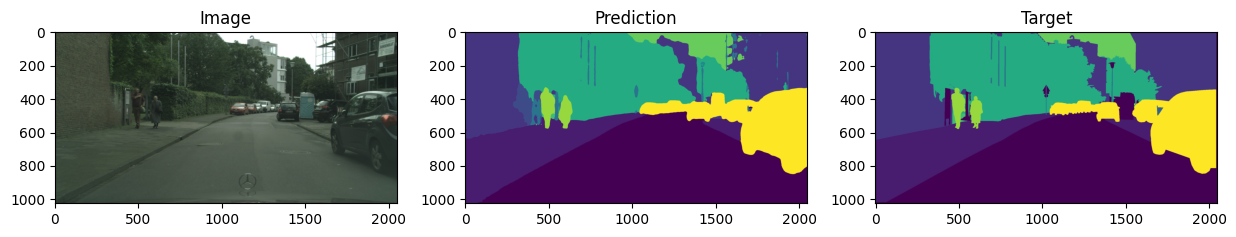

In [ ]:
val_plot(config,icnet, dataset =cityscape_test, device = device,name = 'icnet')

## 4.3. Computing miou

In [ ]:
pixAcc_miou(config,
            model = icnet,
            dataloader = train_dataloader,
            device = device,
            name = 'icnet')

1it [00:02,  2.05s/it]

6/2975: miou: 0.39060282707214355


2it [00:02,  1.10s/it]

12/2975: miou: 0.5393030047416687


3it [00:03,  1.18s/it]

18/2975: miou: 0.506142258644104


5it [00:05,  1.03it/s]

24/2975: miou: 0.5383147597312927
30/2975: miou: 0.5514042377471924


7it [00:07,  1.03it/s]

36/2975: miou: 0.5481381416320801
42/2975: miou: 0.6040925979614258


9it [00:09,  1.00s/it]

48/2975: miou: 0.6188492774963379
54/2975: miou: 0.6258600354194641


11it [00:11,  1.01it/s]

60/2975: miou: 0.6207804083824158
66/2975: miou: 0.6451303958892822


13it [00:13,  1.00it/s]

72/2975: miou: 0.6738685369491577
78/2975: miou: 0.6728998422622681


15it [00:14,  1.19it/s]

84/2975: miou: 0.6722198724746704
90/2975: miou: 0.6661912202835083


16it [00:15,  1.42it/s]

96/2975: miou: 0.6609118580818176


18it [00:17,  1.11it/s]

102/2975: miou: 0.6604955792427063
108/2975: miou: 0.6576004028320312


20it [00:19,  1.08it/s]

114/2975: miou: 0.6688515543937683
120/2975: miou: 0.6724977493286133


22it [00:21,  1.03it/s]

126/2975: miou: 0.6713593602180481
132/2975: miou: 0.6721380352973938


23it [00:21,  1.23it/s]

138/2975: miou: 0.675011396408081


24it [00:22,  1.46it/s]

144/2975: miou: 0.6754301190376282


26it [00:24,  1.16it/s]

150/2975: miou: 0.6768962144851685
156/2975: miou: 0.6756224632263184


27it [00:24,  1.35it/s]

162/2975: miou: 0.6762484312057495


28it [00:25,  1.56it/s]

168/2975: miou: 0.6759216785430908


30it [00:27,  1.16it/s]

174/2975: miou: 0.6747078895568848
180/2975: miou: 0.6754445433616638


32it [00:28,  1.30it/s]

186/2975: miou: 0.6766402721405029
192/2975: miou: 0.675463080406189


33it [00:29,  1.50it/s]

198/2975: miou: 0.6740579605102539


35it [00:30,  1.55it/s]

204/2975: miou: 0.6709668040275574
210/2975: miou: 0.6711111664772034


37it [00:32,  1.21it/s]

216/2975: miou: 0.6700612902641296
222/2975: miou: 0.6664150357246399


39it [00:34,  1.10it/s]

228/2975: miou: 0.6659358143806458
234/2975: miou: 0.6622240543365479


41it [00:36,  1.05it/s]

240/2975: miou: 0.6616060137748718
246/2975: miou: 0.6651057600975037


43it [00:37,  1.24it/s]

252/2975: miou: 0.7055192589759827
258/2975: miou: 0.7001888155937195


44it [00:38,  1.47it/s]

264/2975: miou: 0.6998898386955261


46it [00:39,  1.45it/s]

270/2975: miou: 0.6988505721092224
276/2975: miou: 0.7000574469566345


48it [00:40,  1.54it/s]

282/2975: miou: 0.6991060376167297
288/2975: miou: 0.6985721588134766


49it [00:41,  1.72it/s]

294/2975: miou: 0.6982529163360596


51it [00:42,  1.61it/s]

300/2975: miou: 0.6959676146507263
306/2975: miou: 0.6956670880317688


53it [00:43,  1.62it/s]

312/2975: miou: 0.6952499747276306
318/2975: miou: 0.6949023008346558


54it [00:44,  1.71it/s]

324/2975: miou: 0.6946516036987305


56it [00:45,  1.52it/s]

330/2975: miou: 0.6941983103752136
336/2975: miou: 0.6935194134712219


58it [00:46,  1.57it/s]

342/2975: miou: 0.6929558515548706
348/2975: miou: 0.6915180087089539


59it [00:47,  1.71it/s]

354/2975: miou: 0.6915873289108276


61it [00:49,  1.28it/s]

360/2975: miou: 0.6905386447906494
366/2975: miou: 0.6943740844726562


62it [00:49,  1.48it/s]

372/2975: miou: 0.6938690543174744


63it [00:50,  1.70it/s]

378/2975: miou: 0.6928833723068237


65it [00:51,  1.58it/s]

384/2975: miou: 0.6905291676521301
390/2975: miou: 0.6906822323799133


67it [00:53,  1.28it/s]

396/2975: miou: 0.6945961117744446
402/2975: miou: 0.693520188331604


69it [00:55,  1.11it/s]

408/2975: miou: 0.6934652924537659
414/2975: miou: 0.6938320398330688


71it [00:57,  1.06it/s]

420/2975: miou: 0.6919271349906921
426/2975: miou: 0.6915491223335266


73it [00:59,  1.04it/s]

432/2975: miou: 0.691225528717041
438/2975: miou: 0.691537082195282


75it [01:01,  1.01it/s]

444/2975: miou: 0.6946568489074707
450/2975: miou: 0.693705677986145


77it [01:03,  1.01it/s]

456/2975: miou: 0.694745659828186
462/2975: miou: 0.696586549282074


79it [01:04,  1.21it/s]

468/2975: miou: 0.696828305721283
474/2975: miou: 0.6963211297988892


80it [01:05,  1.42it/s]

480/2975: miou: 0.6961722373962402


82it [01:06,  1.45it/s]

486/2975: miou: 0.6961674690246582
492/2975: miou: 0.6964089274406433


84it [01:08,  1.20it/s]

498/2975: miou: 0.6958723068237305
504/2975: miou: 0.695469081401825


86it [01:10,  1.10it/s]

510/2975: miou: 0.6947538256645203
516/2975: miou: 0.6937791705131531


88it [01:12,  1.04it/s]

522/2975: miou: 0.6954635977745056
528/2975: miou: 0.697633683681488


90it [01:14,  1.02it/s]

534/2975: miou: 0.6970240473747253
540/2975: miou: 0.697860062122345


91it [01:14,  1.21it/s]

546/2975: miou: 0.6979576349258423


92it [01:15,  1.42it/s]

552/2975: miou: 0.698197066783905


94it [01:17,  1.13it/s]

558/2975: miou: 0.6983561515808105
564/2975: miou: 0.7017421126365662


96it [01:19,  1.07it/s]

570/2975: miou: 0.7022848725318909
576/2975: miou: 0.7008020281791687


98it [01:21,  1.03it/s]

582/2975: miou: 0.7008286118507385
588/2975: miou: 0.7007606625556946


99it [01:21,  1.25it/s]

594/2975: miou: 0.7003659605979919


100it [01:22,  1.48it/s]

600/2975: miou: 0.7024317383766174


102it [01:24,  1.13it/s]

606/2975: miou: 0.7020444869995117
612/2975: miou: 0.7015063762664795


104it [01:26,  1.07it/s]

618/2975: miou: 0.7017725706100464
624/2975: miou: 0.7015783786773682


106it [01:28,  1.03it/s]

630/2975: miou: 0.7017689943313599
636/2975: miou: 0.7019927501678467


107it [01:28,  1.23it/s]

642/2975: miou: 0.7007712125778198


108it [01:29,  1.46it/s]

648/2975: miou: 0.701484203338623


110it [01:30,  1.39it/s]

654/2975: miou: 0.7015742063522339
660/2975: miou: 0.7020311951637268


112it [01:32,  1.20it/s]

666/2975: miou: 0.7016749978065491
672/2975: miou: 0.7010119557380676


114it [01:34,  1.11it/s]

678/2975: miou: 0.7009040713310242
684/2975: miou: 0.7009692788124084


116it [01:36,  1.05it/s]

690/2975: miou: 0.7007986307144165
696/2975: miou: 0.7014419436454773


118it [01:37,  1.24it/s]

702/2975: miou: 0.7014954686164856
708/2975: miou: 0.7006574869155884


119it [01:38,  1.46it/s]

714/2975: miou: 0.7007951140403748


121it [01:39,  1.40it/s]

720/2975: miou: 0.700665295124054
726/2975: miou: 0.7007943987846375


123it [01:41,  1.22it/s]

732/2975: miou: 0.7014243602752686
738/2975: miou: 0.6998102068901062


125it [01:43,  1.10it/s]

744/2975: miou: 0.6999715566635132
750/2975: miou: 0.6997430920600891


127it [01:45,  1.07it/s]

756/2975: miou: 0.6998659372329712
762/2975: miou: 0.6999252438545227


129it [01:46,  1.24it/s]

768/2975: miou: 0.6999732851982117
774/2975: miou: 0.701636552810669


130it [01:47,  1.46it/s]

780/2975: miou: 0.70118647813797


132it [01:49,  1.13it/s]

786/2975: miou: 0.7018721103668213
792/2975: miou: 0.7016926407814026


134it [01:51,  1.06it/s]

798/2975: miou: 0.7015554308891296
804/2975: miou: 0.7030138969421387


136it [01:53,  1.02it/s]

810/2975: miou: 0.7022760510444641
816/2975: miou: 0.7021341323852539


138it [01:54,  1.23it/s]

822/2975: miou: 0.7019925117492676
828/2975: miou: 0.7020107507705688


139it [01:55,  1.45it/s]

834/2975: miou: 0.7018790245056152


141it [01:57,  1.13it/s]

840/2975: miou: 0.7008812427520752
846/2975: miou: 0.7008048892021179


143it [01:59,  1.07it/s]

852/2975: miou: 0.7008775472640991
858/2975: miou: 0.7010273933410645


145it [02:01,  1.04it/s]

864/2975: miou: 0.700832188129425
870/2975: miou: 0.701337993144989


147it [02:02,  1.25it/s]

876/2975: miou: 0.7021503448486328
882/2975: miou: 0.7022404670715332


148it [02:03,  1.47it/s]

888/2975: miou: 0.7023267149925232


149it [02:03,  1.44it/s]

894/2975: miou: 0.7025656700134277


150it [02:04,  1.63it/s]

900/2975: miou: 0.7027748227119446


152it [02:06,  1.18it/s]

906/2975: miou: 0.7026351094245911
912/2975: miou: 0.7024614214897156


154it [02:08,  1.10it/s]

918/2975: miou: 0.7039931416511536
924/2975: miou: 0.703880786895752


156it [02:10,  1.05it/s]

930/2975: miou: 0.7039770483970642
936/2975: miou: 0.7039275765419006


158it [02:12,  1.03it/s]

942/2975: miou: 0.7036305069923401
948/2975: miou: 0.7031804919242859


160it [02:14,  1.02it/s]

954/2975: miou: 0.7036369442939758
960/2975: miou: 0.7037381529808044


162it [02:15,  1.18it/s]

966/2975: miou: 0.7033625245094299
972/2975: miou: 0.7023690938949585


163it [02:16,  1.38it/s]

978/2975: miou: 0.7029486298561096


165it [02:18,  1.15it/s]

984/2975: miou: 0.7029779553413391
990/2975: miou: 0.7034817934036255


167it [02:20,  1.07it/s]

996/2975: miou: 0.7034221291542053
1002/2975: miou: 0.7033696174621582


169it [02:21,  1.26it/s]

1008/2975: miou: 0.7030227780342102
1014/2975: miou: 0.7028815746307373


170it [02:22,  1.48it/s]

1020/2975: miou: 0.7025761008262634


172it [02:23,  1.51it/s]

1026/2975: miou: 0.7023600935935974
1032/2975: miou: 0.7023880481719971


174it [02:25,  1.21it/s]

1038/2975: miou: 0.7018607258796692
1044/2975: miou: 0.7015628814697266


176it [02:27,  1.08it/s]

1050/2975: miou: 0.701240062713623
1056/2975: miou: 0.700988233089447


178it [02:29,  1.05it/s]

1062/2975: miou: 0.700707733631134
1068/2975: miou: 0.700798511505127


180it [02:31,  1.03it/s]

1074/2975: miou: 0.7001821398735046
1080/2975: miou: 0.7000689506530762


182it [02:33,  1.01it/s]

1086/2975: miou: 0.6999545693397522
1092/2975: miou: 0.7000308036804199


183it [02:33,  1.21it/s]

1098/2975: miou: 0.7002102136611938


184it [02:34,  1.43it/s]

1104/2975: miou: 0.6997784972190857


186it [02:35,  1.45it/s]

1110/2975: miou: 0.6997165679931641
1116/2975: miou: 0.6996825933456421


188it [02:37,  1.21it/s]

1122/2975: miou: 0.7002289891242981
1128/2975: miou: 0.7000476717948914


190it [02:39,  1.10it/s]

1134/2975: miou: 0.6998799443244934
1140/2975: miou: 0.7000868916511536


192it [02:40,  1.27it/s]

1146/2975: miou: 0.6997416019439697
1152/2975: miou: 0.7000251412391663


193it [02:41,  1.48it/s]

1158/2975: miou: 0.6998596787452698


195it [02:43,  1.15it/s]

1164/2975: miou: 0.699819803237915
1170/2975: miou: 0.6997350454330444


197it [02:45,  1.07it/s]

1176/2975: miou: 0.6996357440948486
1182/2975: miou: 0.6992902159690857


198it [02:45,  1.26it/s]

1188/2975: miou: 0.7000141143798828


199it [02:46,  1.49it/s]

1194/2975: miou: 0.7001069188117981


201it [02:47,  1.53it/s]

1200/2975: miou: 0.699806272983551
1206/2975: miou: 0.6997259259223938


203it [02:49,  1.19it/s]

1212/2975: miou: 0.6996047496795654
1218/2975: miou: 0.6992326378822327


205it [02:51,  1.10it/s]

1224/2975: miou: 0.6989919543266296
1230/2975: miou: 0.6993427276611328


207it [02:53,  1.03it/s]

1236/2975: miou: 0.6995604038238525
1242/2975: miou: 0.6989122629165649


209it [02:55,  1.03it/s]

1248/2975: miou: 0.6992082595825195
1254/2975: miou: 0.6992548704147339


211it [02:57,  1.02it/s]

1260/2975: miou: 0.6992787718772888
1266/2975: miou: 0.6995236873626709


212it [02:57,  1.22it/s]

1272/2975: miou: 0.6992287635803223


213it [02:58,  1.42it/s]

1278/2975: miou: 0.6990411281585693


215it [02:59,  1.46it/s]

1284/2975: miou: 0.6995294690132141
1290/2975: miou: 0.7018551826477051


217it [03:01,  1.23it/s]

1296/2975: miou: 0.7016955018043518
1302/2975: miou: 0.7017278075218201


218it [03:01,  1.46it/s]

1308/2975: miou: 0.701784610748291


219it [03:02,  1.67it/s]

1314/2975: miou: 0.7016698718070984


221it [03:03,  1.62it/s]

1320/2975: miou: 0.7013120651245117
1326/2975: miou: 0.7005364298820496


222it [03:03,  1.73it/s]

1332/2975: miou: 0.7003198266029358


223it [03:04,  1.72it/s]

1338/2975: miou: 0.7003300189971924


225it [03:06,  1.24it/s]

1344/2975: miou: 0.7004166841506958
1350/2975: miou: 0.700556755065918


227it [03:08,  1.12it/s]

1356/2975: miou: 0.7005589008331299
1362/2975: miou: 0.7006385922431946


229it [03:10,  1.05it/s]

1368/2975: miou: 0.7010189890861511
1374/2975: miou: 0.7008912563323975


231it [03:12,  1.03it/s]

1380/2975: miou: 0.7038578987121582
1386/2975: miou: 0.7038446664810181


233it [03:14,  1.02it/s]

1392/2975: miou: 0.7034100294113159
1398/2975: miou: 0.7034608125686646


235it [03:15,  1.22it/s]

1404/2975: miou: 0.7032208442687988
1410/2975: miou: 0.7031286358833313


236it [03:16,  1.44it/s]

1416/2975: miou: 0.7031760811805725


238it [03:17,  1.45it/s]

1422/2975: miou: 0.7031587958335876
1428/2975: miou: 0.7031934261322021


240it [03:18,  1.51it/s]

1434/2975: miou: 0.7034249305725098
1440/2975: miou: 0.7032700777053833


241it [03:19,  1.71it/s]

1446/2975: miou: 0.7030791640281677


243it [03:20,  1.66it/s]

1452/2975: miou: 0.7029937505722046
1458/2975: miou: 0.702826976776123


244it [03:21,  1.40it/s]

1464/2975: miou: 0.7026000022888184


245it [03:21,  1.61it/s]

1470/2975: miou: 0.702619194984436


246it [03:22,  1.69it/s]

1476/2975: miou: 0.7035671472549438


248it [03:24,  1.22it/s]

1482/2975: miou: 0.7034252882003784
1488/2975: miou: 0.7033408880233765


250it [03:26,  1.11it/s]

1494/2975: miou: 0.7037918567657471
1500/2975: miou: 0.7037438154220581


252it [03:28,  1.04it/s]

1506/2975: miou: 0.7040963172912598
1512/2975: miou: 0.7045320868492126


254it [03:30,  1.01it/s]

1518/2975: miou: 0.7047297358512878
1524/2975: miou: 0.7048903107643127


256it [03:32,  1.02it/s]

1530/2975: miou: 0.7047410011291504
1536/2975: miou: 0.7048853635787964


258it [03:33,  1.22it/s]

1542/2975: miou: 0.7048116326332092
1548/2975: miou: 0.7056239247322083


259it [03:34,  1.45it/s]

1554/2975: miou: 0.7059366106987


261it [03:35,  1.43it/s]

1560/2975: miou: 0.7060789465904236
1566/2975: miou: 0.7060763835906982


263it [03:36,  1.55it/s]

1572/2975: miou: 0.7065288424491882
1578/2975: miou: 0.7064054608345032


264it [03:37,  1.73it/s]

1584/2975: miou: 0.7066512107849121


266it [03:38,  1.58it/s]

1590/2975: miou: 0.706657886505127
1596/2975: miou: 0.7066450119018555


267it [03:39,  1.40it/s]

1602/2975: miou: 0.7064396739006042


268it [03:39,  1.58it/s]

1608/2975: miou: 0.7063513398170471


269it [03:40,  1.77it/s]

1614/2975: miou: 0.7062391042709351


271it [03:41,  1.50it/s]

1620/2975: miou: 0.7064111828804016
1626/2975: miou: 0.705428421497345


273it [03:43,  1.29it/s]

1632/2975: miou: 0.705477774143219
1638/2975: miou: 0.7055814862251282


275it [03:45,  1.12it/s]

1644/2975: miou: 0.7054666876792908
1650/2975: miou: 0.7054858207702637


276it [03:45,  1.34it/s]

1656/2975: miou: 0.7056657075881958


277it [03:46,  1.57it/s]

1662/2975: miou: 0.7055739760398865


279it [03:47,  1.52it/s]

1668/2975: miou: 0.7053894996643066
1674/2975: miou: 0.7054791450500488


281it [03:48,  1.54it/s]

1680/2975: miou: 0.705758273601532
1686/2975: miou: 0.7061736583709717


282it [03:49,  1.75it/s]

1692/2975: miou: 0.7062497735023499


284it [03:50,  1.53it/s]

1698/2975: miou: 0.7065721154212952
1704/2975: miou: 0.7065640091896057


286it [03:52,  1.26it/s]

1710/2975: miou: 0.7062886357307434
1716/2975: miou: 0.7064743638038635


288it [03:54,  1.12it/s]

1722/2975: miou: 0.7063765525817871
1728/2975: miou: 0.7062699794769287


290it [03:56,  1.06it/s]

1734/2975: miou: 0.7058900594711304
1740/2975: miou: 0.7059885859489441


292it [03:58,  1.02it/s]

1746/2975: miou: 0.7059834003448486
1752/2975: miou: 0.705567479133606


294it [04:00,  1.02it/s]

1758/2975: miou: 0.7057651877403259
1764/2975: miou: 0.7057288885116577


296it [04:01,  1.20it/s]

1770/2975: miou: 0.7060415148735046
1776/2975: miou: 0.7064853310585022


297it [04:02,  1.43it/s]

1782/2975: miou: 0.7063066363334656


299it [04:03,  1.51it/s]

1788/2975: miou: 0.7062291502952576
1794/2975: miou: 0.7063644528388977


301it [04:05,  1.20it/s]

1800/2975: miou: 0.7064682841300964
1806/2975: miou: 0.7063387036323547


303it [04:07,  1.09it/s]

1812/2975: miou: 0.7053471803665161
1818/2975: miou: 0.7053208947181702


305it [04:09,  1.05it/s]

1824/2975: miou: 0.70545893907547
1830/2975: miou: 0.7055128216743469


307it [04:11,  1.02it/s]

1836/2975: miou: 0.7054514288902283
1842/2975: miou: 0.7054027318954468


309it [04:13,  1.01it/s]

1848/2975: miou: 0.7052933573722839
1854/2975: miou: 0.7049063444137573


311it [04:14,  1.23it/s]

1860/2975: miou: 0.7049456238746643
1866/2975: miou: 0.7048993110656738


312it [04:15,  1.46it/s]

1872/2975: miou: 0.7049374580383301


314it [04:17,  1.12it/s]

1878/2975: miou: 0.7050907015800476
1884/2975: miou: 0.7051298022270203


316it [04:19,  1.06it/s]

1890/2975: miou: 0.7047155499458313
1896/2975: miou: 0.7045629024505615


318it [04:20,  1.23it/s]

1902/2975: miou: 0.7043859362602234
1908/2975: miou: 0.7052321434020996


319it [04:21,  1.46it/s]

1914/2975: miou: 0.7054585814476013


321it [04:23,  1.13it/s]

1920/2975: miou: 0.7053399085998535
1926/2975: miou: 0.7046547532081604


323it [04:25,  1.08it/s]

1932/2975: miou: 0.7047011256217957
1938/2975: miou: 0.7046718597412109


325it [04:26,  1.24it/s]

1944/2975: miou: 0.7045372724533081
1950/2975: miou: 0.7044739723205566


326it [04:27,  1.46it/s]

1956/2975: miou: 0.7050300240516663


328it [04:29,  1.14it/s]

1962/2975: miou: 0.7043935656547546
1968/2975: miou: 0.7044451236724854


330it [04:31,  1.08it/s]

1974/2975: miou: 0.7043744921684265
1980/2975: miou: 0.7044236063957214


332it [04:33,  1.04it/s]

1986/2975: miou: 0.7043795585632324
1992/2975: miou: 0.7042053937911987


334it [04:35,  1.01it/s]

1998/2975: miou: 0.7042069435119629
2004/2975: miou: 0.703716516494751


335it [04:35,  1.21it/s]

2010/2975: miou: 0.7038775086402893


336it [04:36,  1.43it/s]

2016/2975: miou: 0.7042441964149475


338it [04:38,  1.16it/s]

2022/2975: miou: 0.7048019766807556
2028/2975: miou: 0.7048766016960144


340it [04:39,  1.29it/s]

2034/2975: miou: 0.7049612998962402
2040/2975: miou: 0.7049291729927063


341it [04:40,  1.51it/s]

2046/2975: miou: 0.7049205899238586


343it [04:42,  1.14it/s]

2052/2975: miou: 0.7074939608573914
2058/2975: miou: 0.7073575258255005


345it [04:44,  1.07it/s]

2064/2975: miou: 0.7070494294166565
2070/2975: miou: 0.7070367932319641


346it [04:44,  1.25it/s]

2076/2975: miou: 0.7071655988693237


347it [04:45,  1.47it/s]

2082/2975: miou: 0.7073519825935364


349it [04:47,  1.13it/s]

2088/2975: miou: 0.7079386711120605
2094/2975: miou: 0.7079036235809326


351it [04:49,  1.07it/s]

2100/2975: miou: 0.7079227566719055
2106/2975: miou: 0.7082127332687378


353it [04:51,  1.04it/s]

2112/2975: miou: 0.7082428932189941
2118/2975: miou: 0.7082189917564392


354it [04:51,  1.23it/s]

2124/2975: miou: 0.7080204486846924


355it [04:52,  1.45it/s]

2130/2975: miou: 0.7085816264152527


357it [04:54,  1.11it/s]

2136/2975: miou: 0.7086379528045654
2142/2975: miou: 0.7083761096000671


359it [04:56,  1.06it/s]

2148/2975: miou: 0.7083030343055725
2154/2975: miou: 0.7082675695419312


361it [04:58,  1.04it/s]

2160/2975: miou: 0.708083987236023
2166/2975: miou: 0.7083911299705505


363it [04:59,  1.22it/s]

2172/2975: miou: 0.7083482146263123
2178/2975: miou: 0.7083274126052856


364it [05:00,  1.43it/s]

2184/2975: miou: 0.7080273628234863


366it [05:02,  1.14it/s]

2190/2975: miou: 0.7081777453422546
2196/2975: miou: 0.7080793380737305


368it [05:04,  1.08it/s]

2202/2975: miou: 0.7080104351043701
2208/2975: miou: 0.7082653641700745


370it [05:05,  1.23it/s]

2214/2975: miou: 0.7083603143692017
2220/2975: miou: 0.7081544399261475


371it [05:06,  1.44it/s]

2226/2975: miou: 0.7081599235534668


373it [05:08,  1.14it/s]

2232/2975: miou: 0.7083269357681274
2238/2975: miou: 0.708444356918335


375it [05:10,  1.06it/s]

2244/2975: miou: 0.7081440091133118
2250/2975: miou: 0.7081714272499084


377it [05:11,  1.25it/s]

2256/2975: miou: 0.7081187963485718
2262/2975: miou: 0.7079465985298157


379it [05:12,  1.70it/s]

2268/2975: miou: 0.7081173062324524
2274/2975: miou: 0.7079538106918335


380it [05:13,  1.51it/s]

2280/2975: miou: 0.7077953219413757


382it [05:15,  1.20it/s]

2286/2975: miou: 0.7080723643302917
2292/2975: miou: 0.7077835202217102


384it [05:17,  1.10it/s]

2298/2975: miou: 0.7077559232711792
2304/2975: miou: 0.7071921229362488


386it [05:19,  1.04it/s]

2310/2975: miou: 0.7070515751838684
2316/2975: miou: 0.7072564959526062


388it [05:20,  1.25it/s]

2322/2975: miou: 0.7078695297241211
2328/2975: miou: 0.7078117728233337


389it [05:21,  1.47it/s]

2334/2975: miou: 0.7078765630722046


391it [05:22,  1.50it/s]

2340/2975: miou: 0.7083364129066467
2346/2975: miou: 0.7083025574684143


393it [05:24,  1.19it/s]

2352/2975: miou: 0.7085172533988953
2358/2975: miou: 0.7082127928733826


395it [05:26,  1.10it/s]

2364/2975: miou: 0.7082010507583618
2370/2975: miou: 0.708553671836853


397it [05:28,  1.05it/s]

2376/2975: miou: 0.7085627913475037
2382/2975: miou: 0.7085201144218445


398it [05:28,  1.25it/s]

2388/2975: miou: 0.7085779905319214


399it [05:29,  1.48it/s]

2394/2975: miou: 0.7087509036064148


401it [05:30,  1.41it/s]

2400/2975: miou: 0.7086787223815918
2406/2975: miou: 0.7088224291801453


403it [05:32,  1.21it/s]

2412/2975: miou: 0.708650529384613
2418/2975: miou: 0.7085964679718018


405it [05:34,  1.10it/s]

2424/2975: miou: 0.7086358070373535
2430/2975: miou: 0.7091122269630432


407it [05:36,  1.04it/s]

2436/2975: miou: 0.7090729475021362
2442/2975: miou: 0.7092691659927368


409it [05:38,  1.03it/s]

2448/2975: miou: 0.709022045135498
2454/2975: miou: 0.7089775800704956


411it [05:39,  1.23it/s]

2460/2975: miou: 0.7092303037643433
2466/2975: miou: 0.7096981406211853


412it [05:40,  1.46it/s]

2472/2975: miou: 0.7092429995536804


414it [05:42,  1.13it/s]

2478/2975: miou: 0.7092617154121399
2484/2975: miou: 0.709585964679718


416it [05:44,  1.05it/s]

2490/2975: miou: 0.7096713185310364
2496/2975: miou: 0.7096720933914185


418it [05:46,  1.03it/s]

2502/2975: miou: 0.7093621492385864
2508/2975: miou: 0.7094108462333679


420it [05:48,  1.02it/s]

2514/2975: miou: 0.7093235850334167
2520/2975: miou: 0.7090667486190796


422it [05:50,  1.01it/s]

2526/2975: miou: 0.7082756757736206
2532/2975: miou: 0.7081937193870544


424it [05:52,  1.02it/s]

2538/2975: miou: 0.7082780599594116
2544/2975: miou: 0.7082257270812988


425it [05:52,  1.20it/s]

2550/2975: miou: 0.7082223296165466


426it [05:53,  1.42it/s]

2556/2975: miou: 0.7080677151679993


428it [05:55,  1.11it/s]

2562/2975: miou: 0.707989513874054
2568/2975: miou: 0.7078034281730652


430it [05:57,  1.05it/s]

2574/2975: miou: 0.7077696919441223
2580/2975: miou: 0.7082189321517944


432it [05:59,  1.03it/s]

2586/2975: miou: 0.7081281542778015
2592/2975: miou: 0.7079046964645386


434it [06:01,  1.02it/s]

2598/2975: miou: 0.7078405618667603
2604/2975: miou: 0.7078288197517395


436it [06:03,  1.00it/s]

2610/2975: miou: 0.7076595425605774
2616/2975: miou: 0.7075358629226685


438it [06:05,  1.00it/s]

2622/2975: miou: 0.7073553204536438
2628/2975: miou: 0.707561731338501


440it [06:06,  1.21it/s]

2634/2975: miou: 0.7076737880706787
2640/2975: miou: 0.7077174186706543


441it [06:07,  1.44it/s]

2646/2975: miou: 0.7075914740562439


443it [06:09,  1.12it/s]

2652/2975: miou: 0.707516074180603
2658/2975: miou: 0.7076097726821899


445it [06:11,  1.06it/s]

2664/2975: miou: 0.707656741142273
2670/2975: miou: 0.7075212001800537


447it [06:13,  1.03it/s]

2676/2975: miou: 0.7079193592071533
2682/2975: miou: 0.7080475687980652


449it [06:15,  1.01it/s]

2688/2975: miou: 0.7080975770950317
2694/2975: miou: 0.7082260847091675


451it [06:17,  1.01it/s]

2700/2975: miou: 0.7078321576118469
2706/2975: miou: 0.7077727913856506


453it [06:18,  1.18it/s]

2712/2975: miou: 0.7073076367378235
2718/2975: miou: 0.706903874874115


454it [06:19,  1.40it/s]

2724/2975: miou: 0.7067984938621521


456it [06:21,  1.14it/s]

2730/2975: miou: 0.7067821025848389
2736/2975: miou: 0.7066845893859863


458it [06:23,  1.06it/s]

2742/2975: miou: 0.7066482901573181
2748/2975: miou: 0.7065939903259277


460it [06:25,  1.04it/s]

2754/2975: miou: 0.7063894271850586
2760/2975: miou: 0.7062714695930481


461it [06:25,  1.25it/s]

2766/2975: miou: 0.7061760425567627


462it [06:26,  1.48it/s]

2772/2975: miou: 0.7055809497833252


464it [06:28,  1.14it/s]

2778/2975: miou: 0.7054041028022766
2784/2975: miou: 0.7053182125091553


465it [06:28,  1.35it/s]

2790/2975: miou: 0.7051936984062195


466it [06:29,  1.56it/s]

2796/2975: miou: 0.7052353024482727


468it [06:31,  1.15it/s]

2802/2975: miou: 0.7052642703056335
2808/2975: miou: 0.7052484154701233


470it [06:33,  1.08it/s]

2814/2975: miou: 0.7051395773887634
2820/2975: miou: 0.7052049040794373


472it [06:35,  1.03it/s]

2826/2975: miou: 0.7055391669273376
2832/2975: miou: 0.7055414915084839


474it [06:37,  1.02it/s]

2838/2975: miou: 0.705430805683136
2844/2975: miou: 0.7056174278259277


476it [06:39,  1.02it/s]

2850/2975: miou: 0.7060793042182922
2856/2975: miou: 0.7061139345169067


478it [06:41,  1.01s/it]

2862/2975: miou: 0.7061057686805725
2868/2975: miou: 0.7060351371765137


479it [06:41,  1.18it/s]

2874/2975: miou: 0.7060046195983887


480it [06:42,  1.39it/s]

2880/2975: miou: 0.705747127532959


482it [06:43,  1.47it/s]

2886/2975: miou: 0.7056606411933899
2892/2975: miou: 0.7056248188018799


483it [06:44,  1.33it/s]

2898/2975: miou: 0.7055084109306335


484it [06:44,  1.57it/s]

2904/2975: miou: 0.7052165269851685


485it [06:45,  1.77it/s]

2910/2975: miou: 0.705244779586792


487it [06:46,  1.62it/s]

2916/2975: miou: 0.7053661346435547
2922/2975: miou: 0.7053723931312561


489it [06:48,  1.29it/s]

2928/2975: miou: 0.7056193351745605
2934/2975: miou: 0.7055005431175232


491it [06:49,  1.35it/s]

2940/2975: miou: 0.7057907581329346
2946/2975: miou: 0.7059223055839539


492it [06:50,  1.57it/s]

2952/2975: miou: 0.7058766484260559


494it [06:51,  1.49it/s]

2958/2975: miou: 0.7058138847351074
2964/2975: miou: 0.705807089805603


495it [06:52,  1.71it/s]

2970/2975: miou: 0.7059647440910339


496it [06:53,  1.20it/s]

2976/2975: miou: 0.705950140953064


tensor([0.9658, 0.7690, 0.8800, 0.6064, 0.5199, 0.4260, 0.3857, 0.5880, 0.8953,
        0.6902, 0.9317, 0.7407, 0.5015, 0.9111, 0.7391, 0.8071, 0.8313, 0.6138,
        0.6104])

In [ ]:
pixAcc_miou2(config,
            model = icnet,
            dataloader = test_dataloader,
            device = device,
            name = 'icnet')

84it [01:15,  1.11it/s]


Pixel Accuracy: 0.9406604248034709
miou: 0.6614605188369751


In [ ]:
pixAcc_miou3(config,
            model = icnet,
            dataloader = test_dataloader,
            device = device,
            name = 'icnet')

84it [01:15,  1.11it/s]


Pixel Accuracy: 0.9406604248034709
miou: 0.6614605188369751


# 5. BisNet *V1*

- Code: https://github.com/CoinCheung/BiSeNet
- Paper: https://arxiv.org/pdf/1808.00897

## 5.1. Getting the model

In [ ]:
## Getting the model
model = torch.load('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/pretrained_models/BisNetV1/bisnetv1.pth',map_location=device)
bisenetv1 = BiSeNetV1(19,aux_mode = 'eval').to(device)
bisenetv1.load_state_dict(model, strict=False)
bisenetv1.eval()
print('BisNetV1 loaded')

<ipython-input-16-5e104050bfff>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/pret

BisNetV1 loaded


## 5.2. Plotting random outputs

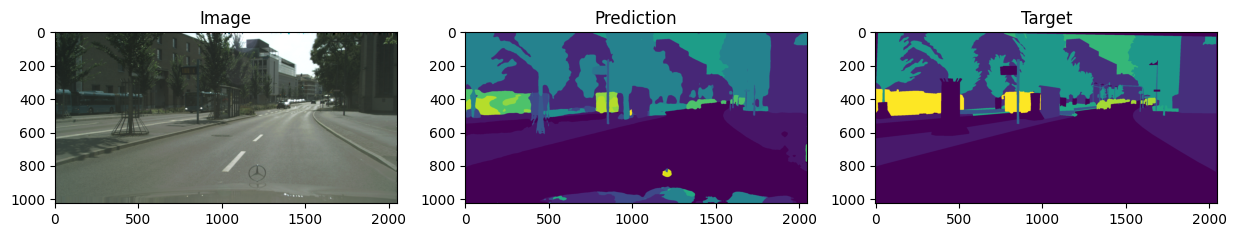

In [ ]:
val_plot(config,bisenetv1, dataset =cityscape_test, device = device,name = 'bisenet')

## 5.3. Computing miou

In [ ]:
pixAcc_miou(config,
            model = bisenetv1,
            dataloader = train_dataloader,
            device = device,
            name = 'bisenet')

1it [00:02,  2.06s/it]

6/2975: miou: 0.6587598919868469


3it [00:04,  1.32s/it]

12/2975: miou: 0.7018072009086609
18/2975: miou: 0.7335047721862793


5it [00:06,  1.13s/it]

24/2975: miou: 0.7169986963272095
30/2975: miou: 0.740643322467804


7it [00:08,  1.06s/it]

36/2975: miou: 0.7412590980529785
42/2975: miou: 0.7415590882301331


9it [00:09,  1.20it/s]

48/2975: miou: 0.8017839193344116
54/2975: miou: 0.8078175783157349


10it [00:10,  1.44it/s]

60/2975: miou: 0.8063815236091614


12it [00:12,  1.09it/s]

66/2975: miou: 0.8085262179374695
72/2975: miou: 0.8014873266220093


14it [00:14,  1.04it/s]

78/2975: miou: 0.8041324019432068
84/2975: miou: 0.802092432975769


16it [00:16,  1.02it/s]

90/2975: miou: 0.8046509623527527
96/2975: miou: 0.8048145174980164


18it [00:18,  1.01s/it]

102/2975: miou: 0.8079817295074463
108/2975: miou: 0.8083996772766113


20it [00:19,  1.24it/s]

114/2975: miou: 0.8101687431335449
120/2975: miou: 0.8116065859794617


21it [00:20,  1.46it/s]

126/2975: miou: 0.8101282119750977


23it [00:22,  1.12it/s]

132/2975: miou: 0.8190136551856995
138/2975: miou: 0.8150986433029175


25it [00:24,  1.04it/s]

144/2975: miou: 0.8172655701637268
150/2975: miou: 0.8191424012184143


27it [00:25,  1.27it/s]

156/2975: miou: 0.8238663673400879
162/2975: miou: 0.8244208097457886


28it [00:26,  1.51it/s]

168/2975: miou: 0.8229945302009583


30it [00:28,  1.13it/s]

174/2975: miou: 0.8232731223106384
180/2975: miou: 0.8209176659584045


32it [00:30,  1.05it/s]

186/2975: miou: 0.8184227347373962
192/2975: miou: 0.8192194104194641


34it [00:32,  1.01it/s]

198/2975: miou: 0.8203624486923218
204/2975: miou: 0.8190433382987976


36it [00:33,  1.24it/s]

210/2975: miou: 0.8202010989189148
216/2975: miou: 0.8193344473838806


37it [00:34,  1.46it/s]

222/2975: miou: 0.8173947334289551


39it [00:36,  1.16it/s]

228/2975: miou: 0.8159812092781067
234/2975: miou: 0.8267698884010315


40it [00:36,  1.35it/s]

240/2975: miou: 0.8241400718688965


41it [00:37,  1.58it/s]

246/2975: miou: 0.8241680264472961


43it [00:38,  1.50it/s]

252/2975: miou: 0.8250270485877991
258/2975: miou: 0.8247401714324951


45it [00:39,  1.53it/s]

264/2975: miou: 0.8248960375785828
270/2975: miou: 0.8244839310646057


46it [00:40,  1.76it/s]

276/2975: miou: 0.8245126605033875


48it [00:42,  1.22it/s]

282/2975: miou: 0.8235116004943848
288/2975: miou: 0.82436203956604


49it [00:42,  1.44it/s]

294/2975: miou: 0.8239139914512634


50it [00:43,  1.65it/s]

300/2975: miou: 0.8236514329910278


52it [00:44,  1.56it/s]

306/2975: miou: 0.8239226341247559
312/2975: miou: 0.8248553276062012


54it [00:45,  1.57it/s]

318/2975: miou: 0.8241243958473206
324/2975: miou: 0.8227835893630981


55it [00:46,  1.76it/s]

330/2975: miou: 0.8227686882019043


57it [00:48,  1.24it/s]

336/2975: miou: 0.8226572871208191
342/2975: miou: 0.821415364742279


58it [00:48,  1.41it/s]

348/2975: miou: 0.8219367861747742


59it [00:49,  1.61it/s]

354/2975: miou: 0.8216825127601624


61it [00:51,  1.20it/s]

360/2975: miou: 0.8203184008598328
366/2975: miou: 0.8221790194511414


62it [00:51,  1.39it/s]

372/2975: miou: 0.8211079835891724


63it [00:52,  1.59it/s]

378/2975: miou: 0.8203721046447754


65it [00:54,  1.18it/s]

384/2975: miou: 0.8191822171211243
390/2975: miou: 0.8198883533477783


66it [00:54,  1.39it/s]

396/2975: miou: 0.8190532326698303


67it [00:55,  1.59it/s]

402/2975: miou: 0.8188369870185852


69it [00:57,  1.19it/s]

408/2975: miou: 0.8202674984931946
414/2975: miou: 0.8207864165306091


70it [00:57,  1.39it/s]

420/2975: miou: 0.8203264474868774


71it [00:58,  1.61it/s]

426/2975: miou: 0.8201742768287659


73it [01:00,  1.20it/s]

432/2975: miou: 0.8193332552909851
438/2975: miou: 0.8188194632530212


74it [01:00,  1.37it/s]

444/2975: miou: 0.819196879863739


75it [01:01,  1.61it/s]

450/2975: miou: 0.8187745809555054


77it [01:02,  1.54it/s]

456/2975: miou: 0.819041907787323
462/2975: miou: 0.8188048601150513


79it [01:03,  1.54it/s]

468/2975: miou: 0.8184933662414551
474/2975: miou: 0.8168801665306091


80it [01:04,  1.77it/s]

480/2975: miou: 0.8168867230415344


82it [01:05,  1.58it/s]

486/2975: miou: 0.8162086606025696
492/2975: miou: 0.8181707262992859


84it [01:07,  1.22it/s]

498/2975: miou: 0.8178154230117798
504/2975: miou: 0.818169891834259


86it [01:08,  1.41it/s]

510/2975: miou: 0.8162478804588318
516/2975: miou: 0.8159712553024292


87it [01:09,  1.65it/s]

522/2975: miou: 0.8160225749015808


88it [01:09,  1.88it/s]

528/2975: miou: 0.8163846731185913


90it [01:11,  1.34it/s]

534/2975: miou: 0.816335916519165
540/2975: miou: 0.8158206939697266


92it [01:13,  1.16it/s]

546/2975: miou: 0.8158900141716003
552/2975: miou: 0.8176815509796143


93it [01:13,  1.35it/s]

558/2975: miou: 0.8177515268325806


94it [01:14,  1.56it/s]

564/2975: miou: 0.8172906041145325


96it [01:16,  1.16it/s]

570/2975: miou: 0.8167752027511597
576/2975: miou: 0.8170530796051025


98it [01:18,  1.07it/s]

582/2975: miou: 0.8174496293067932
588/2975: miou: 0.8178462386131287


100it [01:20,  1.04it/s]

594/2975: miou: 0.8164560198783875
600/2975: miou: 0.8160747289657593


102it [01:22,  1.02it/s]

606/2975: miou: 0.8158990740776062
612/2975: miou: 0.8158213496208191


104it [01:24,  1.02it/s]

618/2975: miou: 0.81586754322052
624/2975: miou: 0.8163142800331116


105it [01:24,  1.22it/s]

630/2975: miou: 0.815926730632782


106it [01:25,  1.46it/s]

636/2975: miou: 0.8159725666046143


108it [01:26,  1.44it/s]

642/2975: miou: 0.8157075643539429
648/2975: miou: 0.8161321878433228


110it [01:27,  1.52it/s]

654/2975: miou: 0.8164547085762024
660/2975: miou: 0.8170579075813293


111it [01:28,  1.69it/s]

666/2975: miou: 0.8168094754219055


113it [01:29,  1.56it/s]

672/2975: miou: 0.8167483806610107
678/2975: miou: 0.8160942196846008


115it [01:31,  1.28it/s]

684/2975: miou: 0.8157804608345032
690/2975: miou: 0.8151662945747375


116it [01:31,  1.49it/s]

696/2975: miou: 0.8152964115142822


117it [01:32,  1.70it/s]

702/2975: miou: 0.8158053755760193


119it [01:34,  1.20it/s]

708/2975: miou: 0.8159070014953613
714/2975: miou: 0.8153839111328125


121it [01:36,  1.08it/s]

720/2975: miou: 0.8158161044120789
726/2975: miou: 0.8158354163169861


123it [01:38,  1.05it/s]

732/2975: miou: 0.8159319758415222
738/2975: miou: 0.8161710500717163


125it [01:40,  1.02it/s]

744/2975: miou: 0.8169466257095337
750/2975: miou: 0.8167564868927002


127it [01:42,  1.01it/s]

756/2975: miou: 0.816546618938446
762/2975: miou: 0.8164010643959045


129it [01:44,  1.02it/s]

768/2975: miou: 0.8162710070610046
774/2975: miou: 0.8153459429740906


130it [01:44,  1.22it/s]

780/2975: miou: 0.815170168876648


131it [01:45,  1.45it/s]

786/2975: miou: 0.8158238530158997


133it [01:47,  1.13it/s]

792/2975: miou: 0.8158789873123169
798/2975: miou: 0.8158658742904663


135it [01:49,  1.08it/s]

804/2975: miou: 0.8160860538482666
810/2975: miou: 0.8161830306053162


136it [01:49,  1.27it/s]

816/2975: miou: 0.8158465623855591


137it [01:50,  1.53it/s]

822/2975: miou: 0.8165035247802734


139it [01:51,  1.46it/s]

828/2975: miou: 0.8151736259460449
834/2975: miou: 0.8151319026947021


141it [01:52,  1.50it/s]

840/2975: miou: 0.8151983022689819
846/2975: miou: 0.8149546980857849


142it [01:53,  1.71it/s]

852/2975: miou: 0.8147687315940857


144it [01:55,  1.23it/s]

858/2975: miou: 0.8146175146102905
864/2975: miou: 0.8150664567947388


145it [01:55,  1.40it/s]

870/2975: miou: 0.8151304721832275


146it [01:56,  1.61it/s]

876/2975: miou: 0.8150728344917297


148it [01:58,  1.21it/s]

882/2975: miou: 0.8148379325866699
888/2975: miou: 0.814829409122467


150it [02:00,  1.09it/s]

894/2975: miou: 0.8150269985198975
900/2975: miou: 0.8152798414230347


152it [02:02,  1.03it/s]

906/2975: miou: 0.8148401975631714
912/2975: miou: 0.8144919872283936


154it [02:04,  1.02it/s]

918/2975: miou: 0.8138809204101562
924/2975: miou: 0.8139855265617371


156it [02:06,  1.00s/it]

930/2975: miou: 0.8139793276786804
936/2975: miou: 0.8144513368606567


158it [02:08,  1.02it/s]

942/2975: miou: 0.8144733905792236
948/2975: miou: 0.8147551417350769


159it [02:08,  1.21it/s]

954/2975: miou: 0.8145588636398315


160it [02:09,  1.44it/s]

960/2975: miou: 0.8150334358215332


162it [02:11,  1.12it/s]

966/2975: miou: 0.8164618015289307
972/2975: miou: 0.8164932727813721


164it [02:12,  1.28it/s]

978/2975: miou: 0.8168297410011292
984/2975: miou: 0.816824734210968


165it [02:13,  1.52it/s]

990/2975: miou: 0.8170989751815796


167it [02:14,  1.46it/s]

996/2975: miou: 0.8170437812805176
1002/2975: miou: 0.8164602518081665


169it [02:16,  1.22it/s]

1008/2975: miou: 0.8165669441223145
1014/2975: miou: 0.816260814666748


171it [02:18,  1.11it/s]

1020/2975: miou: 0.8160891532897949
1026/2975: miou: 0.8164244294166565


172it [02:18,  1.32it/s]

1032/2975: miou: 0.8166025876998901


173it [02:19,  1.55it/s]

1038/2975: miou: 0.8164501786231995


175it [02:20,  1.46it/s]

1044/2975: miou: 0.8164515495300293
1050/2975: miou: 0.8165265917778015


177it [02:22,  1.20it/s]

1056/2975: miou: 0.8172457814216614
1062/2975: miou: 0.8172141909599304


179it [02:23,  1.36it/s]

1068/2975: miou: 0.8173381090164185
1074/2975: miou: 0.818042516708374


180it [02:24,  1.57it/s]

1080/2975: miou: 0.8178794384002686


182it [02:26,  1.16it/s]

1086/2975: miou: 0.8176724910736084
1092/2975: miou: 0.8176555633544922


184it [02:28,  1.11it/s]

1098/2975: miou: 0.8173286318778992
1104/2975: miou: 0.8174655437469482


185it [02:28,  1.29it/s]

1110/2975: miou: 0.8173116445541382


186it [02:29,  1.53it/s]

1116/2975: miou: 0.8173298835754395


188it [02:30,  1.46it/s]

1122/2975: miou: 0.8170843720436096
1128/2975: miou: 0.8174479603767395


190it [02:32,  1.22it/s]

1134/2975: miou: 0.8175347447395325
1140/2975: miou: 0.8179090619087219


192it [02:34,  1.10it/s]

1146/2975: miou: 0.8176653385162354
1152/2975: miou: 0.8174681663513184


194it [02:36,  1.07it/s]

1158/2975: miou: 0.8175718784332275
1164/2975: miou: 0.8189755082130432


196it [02:38,  1.03it/s]

1170/2975: miou: 0.8192520141601562
1176/2975: miou: 0.8183742761611938


198it [02:40,  1.01it/s]

1182/2975: miou: 0.8182836771011353
1188/2975: miou: 0.818107545375824


200it [02:42,  1.02s/it]

1194/2975: miou: 0.8182504177093506
1200/2975: miou: 0.8180792331695557


202it [02:44,  1.00it/s]

1206/2975: miou: 0.8182886242866516
1212/2975: miou: 0.8183260560035706


204it [02:46,  1.01it/s]

1218/2975: miou: 0.8178139925003052
1224/2975: miou: 0.8177104592323303


206it [02:48,  1.02it/s]

1230/2975: miou: 0.8179816603660583
1236/2975: miou: 0.8179338574409485


208it [02:50,  1.00it/s]

1242/2975: miou: 0.8179683685302734
1248/2975: miou: 0.8181977272033691


210it [02:52,  1.00it/s]

1254/2975: miou: 0.8182483911514282
1260/2975: miou: 0.8177955746650696


212it [02:54,  1.00s/it]

1266/2975: miou: 0.8173537254333496
1272/2975: miou: 0.8168637156486511


214it [02:56,  1.00it/s]

1278/2975: miou: 0.8169711232185364
1284/2975: miou: 0.8172892332077026


216it [02:58,  1.01s/it]

1290/2975: miou: 0.8173373937606812
1296/2975: miou: 0.8172592520713806


218it [03:00,  1.00it/s]

1302/2975: miou: 0.8169530034065247
1308/2975: miou: 0.8169468641281128


220it [03:02,  1.01it/s]

1314/2975: miou: 0.8175197243690491
1320/2975: miou: 0.8173260688781738


222it [03:04,  1.01it/s]

1326/2975: miou: 0.8172008991241455
1332/2975: miou: 0.8178438544273376


224it [03:06,  1.00s/it]

1338/2975: miou: 0.8176568746566772
1344/2975: miou: 0.8176881074905396


226it [03:08,  1.00it/s]

1350/2975: miou: 0.8177425861358643
1356/2975: miou: 0.8176274299621582


228it [03:10,  1.01it/s]

1362/2975: miou: 0.8177052736282349
1368/2975: miou: 0.8175830841064453


230it [03:12,  1.01it/s]

1374/2975: miou: 0.817940890789032
1380/2975: miou: 0.8178437948226929


231it [03:12,  1.20it/s]

1386/2975: miou: 0.8178791999816895


232it [03:13,  1.42it/s]

1392/2975: miou: 0.8178440928459167


234it [03:15,  1.13it/s]

1398/2975: miou: 0.8175918459892273
1404/2975: miou: 0.8181396126747131


236it [03:17,  1.06it/s]

1410/2975: miou: 0.8180368542671204
1416/2975: miou: 0.8180913925170898


238it [03:18,  1.26it/s]

1422/2975: miou: 0.8182433247566223
1428/2975: miou: 0.8182662129402161


239it [03:19,  1.49it/s]

1434/2975: miou: 0.8182798624038696


241it [03:21,  1.14it/s]

1440/2975: miou: 0.8183557987213135
1446/2975: miou: 0.8181470632553101


242it [03:21,  1.32it/s]

1452/2975: miou: 0.8179405331611633


243it [03:22,  1.54it/s]

1458/2975: miou: 0.8177639842033386


245it [03:24,  1.18it/s]

1464/2975: miou: 0.817725658416748
1470/2975: miou: 0.817572832107544


247it [03:26,  1.06it/s]

1476/2975: miou: 0.8176751732826233
1482/2975: miou: 0.8176401257514954


249it [03:28,  1.04it/s]

1488/2975: miou: 0.8178410530090332
1494/2975: miou: 0.8177091479301453


251it [03:30,  1.02it/s]

1500/2975: miou: 0.8181607127189636
1506/2975: miou: 0.818253219127655


253it [03:32,  1.01s/it]

1512/2975: miou: 0.8181917071342468
1518/2975: miou: 0.8179123401641846


255it [03:34,  1.02it/s]

1524/2975: miou: 0.8179219961166382
1530/2975: miou: 0.8177258372306824


256it [03:34,  1.21it/s]

1536/2975: miou: 0.8176510334014893


257it [03:35,  1.45it/s]

1542/2975: miou: 0.817499577999115


259it [03:36,  1.44it/s]

1548/2975: miou: 0.8173673152923584
1554/2975: miou: 0.8172709345817566


261it [03:38,  1.17it/s]

1560/2975: miou: 0.8172985911369324
1566/2975: miou: 0.8175090551376343


263it [03:40,  1.10it/s]

1572/2975: miou: 0.817560613155365
1578/2975: miou: 0.8178375959396362


265it [03:42,  1.05it/s]

1584/2975: miou: 0.8179695010185242
1590/2975: miou: 0.8178998231887817


267it [03:44,  1.01it/s]

1596/2975: miou: 0.8178300857543945
1602/2975: miou: 0.8178156614303589


269it [03:46,  1.01it/s]

1608/2975: miou: 0.8175591230392456
1614/2975: miou: 0.817626416683197


271it [03:48,  1.01it/s]

1620/2975: miou: 0.8175625801086426
1626/2975: miou: 0.8176725506782532


273it [03:50,  1.01it/s]

1632/2975: miou: 0.8176782727241516
1638/2975: miou: 0.8175807595252991


275it [03:51,  1.21it/s]

1644/2975: miou: 0.8178395628929138
1650/2975: miou: 0.8178558349609375


276it [03:52,  1.43it/s]

1656/2975: miou: 0.8179298043251038


278it [03:54,  1.12it/s]

1662/2975: miou: 0.8181388974189758
1668/2975: miou: 0.8181602358818054


280it [03:56,  1.03it/s]

1674/2975: miou: 0.8181752562522888
1680/2975: miou: 0.8180939555168152


282it [03:58,  1.03it/s]

1686/2975: miou: 0.8180994391441345
1692/2975: miou: 0.8181391358375549


284it [04:00,  1.02it/s]

1698/2975: miou: 0.8179707527160645
1704/2975: miou: 0.8180589079856873


286it [04:02,  1.02it/s]

1710/2975: miou: 0.8177707195281982
1716/2975: miou: 0.8175783157348633


288it [04:04,  1.00it/s]

1722/2975: miou: 0.8178913593292236
1728/2975: miou: 0.8176582455635071


290it [04:06,  1.00it/s]

1734/2975: miou: 0.8177378177642822
1740/2975: miou: 0.8179831504821777


292it [04:08,  1.02it/s]

1746/2975: miou: 0.8179481625556946
1752/2975: miou: 0.8180908560752869


293it [04:08,  1.23it/s]

1758/2975: miou: 0.8182734847068787


294it [04:09,  1.45it/s]

1764/2975: miou: 0.8184001445770264


296it [04:10,  1.46it/s]

1770/2975: miou: 0.8187161684036255
1776/2975: miou: 0.8188111782073975


298it [04:12,  1.19it/s]

1782/2975: miou: 0.8188139796257019
1788/2975: miou: 0.8188043236732483


300it [04:14,  1.08it/s]

1794/2975: miou: 0.8187403082847595
1800/2975: miou: 0.8186838626861572


302it [04:16,  1.04it/s]

1806/2975: miou: 0.8186771273612976
1812/2975: miou: 0.8184909820556641


304it [04:18,  1.02it/s]

1818/2975: miou: 0.8184529542922974
1824/2975: miou: 0.8184471726417542


306it [04:20,  1.01it/s]

1830/2975: miou: 0.8183640241622925
1836/2975: miou: 0.8182859420776367


308it [04:22,  1.00s/it]

1842/2975: miou: 0.8184909820556641
1848/2975: miou: 0.8187559247016907


310it [04:24,  1.01it/s]

1854/2975: miou: 0.8188140988349915
1860/2975: miou: 0.8187234401702881


312it [04:26,  1.00s/it]

1866/2975: miou: 0.8187281489372253
1872/2975: miou: 0.8198356032371521


314it [04:28,  1.00s/it]

1878/2975: miou: 0.8197243809700012
1884/2975: miou: 0.8195554614067078


316it [04:30,  1.00s/it]

1890/2975: miou: 0.8194721341133118
1896/2975: miou: 0.8195043802261353


318it [04:32,  1.01it/s]

1902/2975: miou: 0.8193597197532654
1908/2975: miou: 0.819421648979187


320it [04:34,  1.00s/it]

1914/2975: miou: 0.8193914294242859
1920/2975: miou: 0.8194456696510315


322it [04:36,  1.00s/it]

1926/2975: miou: 0.8194674849510193
1932/2975: miou: 0.8193590641021729


324it [04:38,  1.01it/s]

1938/2975: miou: 0.8191519379615784
1944/2975: miou: 0.8196120262145996


326it [04:40,  1.00it/s]

1950/2975: miou: 0.819486141204834
1956/2975: miou: 0.8196026682853699


328it [04:42,  1.01s/it]

1962/2975: miou: 0.8195203542709351
1968/2975: miou: 0.8194505572319031


330it [04:44,  1.00it/s]

1974/2975: miou: 0.8196185827255249
1980/2975: miou: 0.8195033669471741


332it [04:45,  1.20it/s]

1986/2975: miou: 0.8198562860488892
1992/2975: miou: 0.8199336528778076


333it [04:46,  1.44it/s]

1998/2975: miou: 0.819756805896759


335it [04:48,  1.14it/s]

2004/2975: miou: 0.819648265838623
2010/2975: miou: 0.8195220232009888


336it [04:48,  1.33it/s]

2016/2975: miou: 0.8197984099388123


337it [04:49,  1.55it/s]

2022/2975: miou: 0.8201648592948914


339it [04:51,  1.19it/s]

2028/2975: miou: 0.8201411366462708
2034/2975: miou: 0.8201054930686951


340it [04:51,  1.37it/s]

2040/2975: miou: 0.820050060749054


342it [04:52,  1.82it/s]

2046/2975: miou: 0.8200643658638
2052/2975: miou: 0.8201056122779846


343it [04:53,  1.53it/s]

2058/2975: miou: 0.8201380372047424


345it [04:55,  1.20it/s]

2064/2975: miou: 0.8201808333396912
2070/2975: miou: 0.820138156414032


347it [04:56,  1.36it/s]

2076/2975: miou: 0.8200098276138306
2082/2975: miou: 0.8199964761734009


348it [04:57,  1.59it/s]

2088/2975: miou: 0.8196999430656433


350it [04:58,  1.50it/s]

2094/2975: miou: 0.8198996782302856
2100/2975: miou: 0.8199607729911804


352it [04:59,  1.52it/s]

2106/2975: miou: 0.8202187418937683
2112/2975: miou: 0.8201879262924194


353it [05:00,  1.73it/s]

2118/2975: miou: 0.8201965689659119


355it [05:01,  1.61it/s]

2124/2975: miou: 0.8201816082000732
2130/2975: miou: 0.8200523853302002


357it [05:03,  1.25it/s]

2136/2975: miou: 0.8199161887168884
2142/2975: miou: 0.8199052810668945


359it [05:05,  1.13it/s]

2148/2975: miou: 0.8198919296264648
2154/2975: miou: 0.8199067115783691


361it [05:07,  1.03it/s]

2160/2975: miou: 0.8198691010475159
2166/2975: miou: 0.819962203502655


363it [05:09,  1.03it/s]

2172/2975: miou: 0.8198946714401245
2178/2975: miou: 0.8196254372596741


365it [05:11,  1.01it/s]

2184/2975: miou: 0.8196145296096802
2190/2975: miou: 0.8196151852607727


367it [05:13,  1.01it/s]

2196/2975: miou: 0.8195865750312805
2202/2975: miou: 0.8196336627006531


369it [05:15,  1.00s/it]

2208/2975: miou: 0.8197122812271118
2214/2975: miou: 0.820364773273468


371it [05:17,  1.01it/s]

2220/2975: miou: 0.8204399943351746
2226/2975: miou: 0.8204017281532288


373it [05:19,  1.00s/it]

2232/2975: miou: 0.8208271861076355
2238/2975: miou: 0.8209452629089355


375it [05:21,  1.00s/it]

2244/2975: miou: 0.8209021091461182
2250/2975: miou: 0.8208789825439453


377it [05:23,  1.00s/it]

2256/2975: miou: 0.8207656145095825
2262/2975: miou: 0.8209001421928406


379it [05:25,  1.02it/s]

2268/2975: miou: 0.8210526704788208
2274/2975: miou: 0.8208816051483154


380it [05:25,  1.23it/s]

2280/2975: miou: 0.8209599852561951


381it [05:26,  1.46it/s]

2286/2975: miou: 0.8207862973213196


383it [05:28,  1.11it/s]

2292/2975: miou: 0.8204482197761536
2298/2975: miou: 0.8192421793937683


385it [05:30,  1.05it/s]

2304/2975: miou: 0.8193894028663635
2310/2975: miou: 0.8193681836128235


387it [05:32,  1.01it/s]

2316/2975: miou: 0.819705605506897
2322/2975: miou: 0.8194990158081055


389it [05:33,  1.24it/s]

2328/2975: miou: 0.8195276856422424
2334/2975: miou: 0.8197008967399597


390it [05:34,  1.45it/s]

2340/2975: miou: 0.8196136355400085


392it [05:36,  1.15it/s]

2346/2975: miou: 0.8193557858467102
2352/2975: miou: 0.8193731307983398


393it [05:36,  1.35it/s]

2358/2975: miou: 0.8193022012710571


394it [05:37,  1.59it/s]

2364/2975: miou: 0.8191595673561096


396it [05:38,  1.56it/s]

2370/2975: miou: 0.8190812468528748
2376/2975: miou: 0.8192216753959656


398it [05:40,  1.19it/s]

2382/2975: miou: 0.819159984588623
2388/2975: miou: 0.8190521001815796


400it [05:41,  1.36it/s]

2394/2975: miou: 0.8189955353736877
2400/2975: miou: 0.818878173828125


401it [05:42,  1.58it/s]

2406/2975: miou: 0.8189069628715515


403it [05:43,  1.46it/s]

2412/2975: miou: 0.8189319968223572
2418/2975: miou: 0.8189090490341187


405it [05:45,  1.26it/s]

2424/2975: miou: 0.8189153075218201
2430/2975: miou: 0.8187788128852844


407it [05:47,  1.10it/s]

2436/2975: miou: 0.8191182613372803
2442/2975: miou: 0.8191803097724915


409it [05:49,  1.04it/s]

2448/2975: miou: 0.8191023468971252
2454/2975: miou: 0.8190916776657104


411it [05:51,  1.00it/s]

2460/2975: miou: 0.8190414309501648
2466/2975: miou: 0.8190754055976868


413it [05:53,  1.02it/s]

2472/2975: miou: 0.8190967440605164
2478/2975: miou: 0.8191105723381042


415it [05:55,  1.00it/s]

2484/2975: miou: 0.8190887570381165
2490/2975: miou: 0.8190413117408752


417it [05:57,  1.01it/s]

2496/2975: miou: 0.8190404772758484
2502/2975: miou: 0.8191105723381042


418it [05:57,  1.20it/s]

2508/2975: miou: 0.8191421031951904


419it [05:58,  1.42it/s]

2514/2975: miou: 0.8187763690948486


421it [06:00,  1.17it/s]

2520/2975: miou: 0.8186857104301453
2526/2975: miou: 0.8184335827827454


422it [06:00,  1.36it/s]

2532/2975: miou: 0.8184230923652649


423it [06:01,  1.59it/s]

2538/2975: miou: 0.8183836936950684


425it [06:02,  1.53it/s]

2544/2975: miou: 0.8185458183288574
2550/2975: miou: 0.8184306621551514


427it [06:03,  1.53it/s]

2556/2975: miou: 0.8181843757629395
2562/2975: miou: 0.8181751370429993


428it [06:04,  1.76it/s]

2568/2975: miou: 0.818156898021698


430it [06:05,  1.58it/s]

2574/2975: miou: 0.8181402683258057
2580/2975: miou: 0.8184106945991516


432it [06:06,  1.58it/s]

2586/2975: miou: 0.8184292316436768
2592/2975: miou: 0.8183354735374451


433it [06:07,  1.77it/s]

2598/2975: miou: 0.8183487057685852


435it [06:08,  1.67it/s]

2604/2975: miou: 0.8184444308280945
2610/2975: miou: 0.8183871507644653


437it [06:09,  1.55it/s]

2616/2975: miou: 0.818338930606842
2622/2975: miou: 0.8187118172645569


438it [06:10,  1.64it/s]

2628/2975: miou: 0.818703293800354


440it [06:12,  1.27it/s]

2634/2975: miou: 0.8187671899795532
2640/2975: miou: 0.818988025188446


441it [06:12,  1.47it/s]

2646/2975: miou: 0.8189606666564941


442it [06:13,  1.70it/s]

2652/2975: miou: 0.818933367729187


444it [06:14,  1.64it/s]

2658/2975: miou: 0.8188585042953491
2664/2975: miou: 0.8188241124153137


446it [06:16,  1.27it/s]

2670/2975: miou: 0.818844199180603
2676/2975: miou: 0.8188270926475525


447it [06:16,  1.43it/s]

2682/2975: miou: 0.8187640309333801


448it [06:17,  1.64it/s]

2688/2975: miou: 0.8187384605407715


450it [06:19,  1.19it/s]

2694/2975: miou: 0.8186675310134888
2700/2975: miou: 0.8185814619064331


451it [06:19,  1.42it/s]

2706/2975: miou: 0.8186801671981812


452it [06:20,  1.62it/s]

2712/2975: miou: 0.8186107277870178


454it [06:22,  1.17it/s]

2718/2975: miou: 0.8185133337974548
2724/2975: miou: 0.8183520436286926


456it [06:24,  1.09it/s]

2730/2975: miou: 0.8183226585388184
2736/2975: miou: 0.8183204531669617


458it [06:26,  1.04it/s]

2742/2975: miou: 0.8183493614196777
2748/2975: miou: 0.8184136748313904


460it [06:28,  1.01it/s]

2754/2975: miou: 0.818341851234436
2760/2975: miou: 0.8182704448699951


462it [06:30,  1.01it/s]

2766/2975: miou: 0.8181207180023193
2772/2975: miou: 0.8180052042007446


464it [06:32,  1.00it/s]

2778/2975: miou: 0.8179922699928284
2784/2975: miou: 0.8180150389671326


466it [06:34,  1.00it/s]

2790/2975: miou: 0.8179189562797546
2796/2975: miou: 0.8179014325141907


468it [06:35,  1.22it/s]

2802/2975: miou: 0.8180933594703674
2808/2975: miou: 0.8181113004684448


469it [06:36,  1.44it/s]

2814/2975: miou: 0.8181158304214478


471it [06:38,  1.15it/s]

2820/2975: miou: 0.8180534839630127
2826/2975: miou: 0.8179690837860107


472it [06:38,  1.33it/s]

2832/2975: miou: 0.8177769780158997


473it [06:39,  1.56it/s]

2838/2975: miou: 0.8177342414855957


475it [06:41,  1.15it/s]

2844/2975: miou: 0.8176782727241516
2850/2975: miou: 0.8175852298736572


477it [06:43,  1.06it/s]

2856/2975: miou: 0.8175663948059082
2862/2975: miou: 0.8178038001060486


479it [06:45,  1.05it/s]

2868/2975: miou: 0.818111002445221
2874/2975: miou: 0.8182984590530396


481it [06:47,  1.00it/s]

2880/2975: miou: 0.8183361887931824
2886/2975: miou: 0.8183273673057556


483it [06:49,  1.02it/s]

2892/2975: miou: 0.818254292011261
2898/2975: miou: 0.8181068301200867


485it [06:51,  1.00it/s]

2904/2975: miou: 0.8181137442588806
2910/2975: miou: 0.8182819485664368


487it [06:53,  1.03it/s]

2916/2975: miou: 0.8181890249252319
2922/2975: miou: 0.8179984092712402


488it [06:53,  1.21it/s]

2928/2975: miou: 0.8181588053703308


489it [06:54,  1.44it/s]

2934/2975: miou: 0.8181368112564087


491it [06:56,  1.11it/s]

2940/2975: miou: 0.8181007504463196
2946/2975: miou: 0.8180139660835266


493it [06:58,  1.07it/s]

2952/2975: miou: 0.8182374835014343
2958/2975: miou: 0.8181698322296143


495it [07:00,  1.04it/s]

2964/2975: miou: 0.8182144165039062
2970/2975: miou: 0.8181700706481934


496it [07:01,  1.18it/s]

2976/2975: miou: 0.8182741403579712


tensor([0.9817, 0.8725, 0.9207, 0.7464, 0.7725, 0.5931, 0.6681, 0.7772, 0.9166,
        0.7969, 0.9486, 0.8300, 0.6954, 0.9471, 0.8209, 0.8901, 0.8930, 0.7284,
        0.7480])

In [ ]:
pixAcc_miou2(config,
            model = bisenetv1,
            dataloader = test_dataloader,
            device = device,
            name = 'bisenet')

84it [01:13,  1.14it/s]



Pixel Accuracy: 0.9500982453466238
miou: 0.714959442615509


In [ ]:
pixAcc_miou3(config,
            model = bisenetv1,
            dataloader = test_dataloader,
            device = device,
            name = 'bisenet')

84it [01:15,  1.12it/s]


Pixel Accuracy: 0.9500982453466238
miou: 0.714959442615509


# 6. BisNet *V2*

- Code: https://github.com/CoinCheung/BiSeNet
- Paper: https://arxiv.org/pdf/2004.02147

## 6.1. Getting the model




In [ ]:
## Getting the model
model = torch.load('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/pretrained_models/BisNetV2/bisnetv2.pth',map_location=device)
bisenetv2 = BiSeNetV2(19,aux_mode = 'eval').to(device)
bisenetv2.load_state_dict(model, strict=False)
bisenetv2.eval()
print('BisNetV2 loaded')

<ipython-input-18-c428ecd14faa>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/pret

BisNetV2 loaded


## 6.2. Plotting random outputs

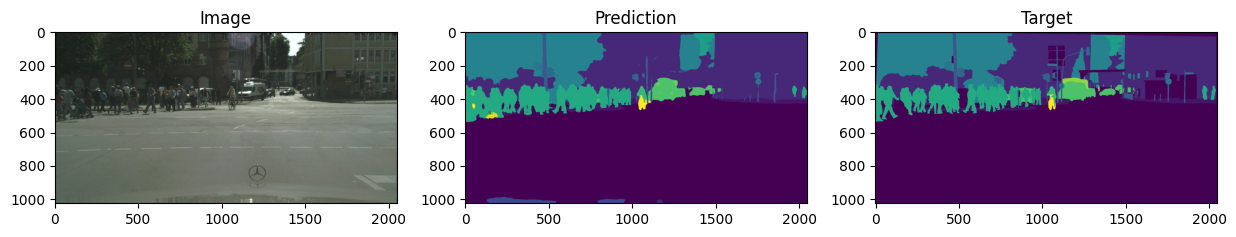

In [ ]:
val_plot(config,bisenetv2, dataset =cityscape_test, device = device,name = 'bisenet')

## 6.3. Computing miou

In [ ]:
pixAcc_miou(config,
            model = bisenetv2,
            dataloader = train_dataloader,
            device = device,
            name = 'bisenet')

1it [00:02,  2.13s/it]

6/2975: miou: 0.6529173851013184


2it [00:02,  1.32s/it]

12/2975: miou: 0.7072867155075073


3it [00:03,  1.01it/s]

18/2975: miou: 0.665621280670166


4it [00:04,  1.05s/it]

24/2975: miou: 0.7072703242301941


5it [00:05,  1.21it/s]

30/2975: miou: 0.6961188316345215


6it [00:05,  1.31it/s]

36/2975: miou: 0.7105875015258789


7it [00:06,  1.31it/s]

42/2975: miou: 0.7132858037948608


9it [00:08,  1.16it/s]

48/2975: miou: 0.7106924653053284
54/2975: miou: 0.6837887763977051


11it [00:10,  1.08it/s]

60/2975: miou: 0.6818655133247375
66/2975: miou: 0.678804337978363


13it [00:12,  1.04it/s]

72/2975: miou: 0.6798767447471619
78/2975: miou: 0.677044689655304


15it [00:13,  1.20it/s]

84/2975: miou: 0.6864047050476074
90/2975: miou: 0.6811601519584656


16it [00:14,  1.44it/s]

96/2975: miou: 0.6815375685691833


18it [00:15,  1.47it/s]

102/2975: miou: 0.6820619702339172
108/2975: miou: 0.6825480461120605


20it [00:16,  1.50it/s]

114/2975: miou: 0.679955005645752
120/2975: miou: 0.673703670501709


21it [00:17,  1.72it/s]

126/2975: miou: 0.6729431748390198


23it [00:18,  1.62it/s]

132/2975: miou: 0.6738273501396179
138/2975: miou: 0.6745012402534485


25it [00:20,  1.24it/s]

144/2975: miou: 0.6798495650291443
150/2975: miou: 0.7296358346939087


27it [00:21,  1.40it/s]

156/2975: miou: 0.7316223382949829
162/2975: miou: 0.7344424724578857


28it [00:22,  1.64it/s]

168/2975: miou: 0.7351915240287781


30it [00:24,  1.16it/s]

174/2975: miou: 0.7298690676689148
180/2975: miou: 0.7296127080917358


32it [00:26,  1.08it/s]

186/2975: miou: 0.7272819876670837
192/2975: miou: 0.7272977828979492


34it [00:28,  1.04it/s]

198/2975: miou: 0.7280895709991455
204/2975: miou: 0.7299763560295105


36it [00:30,  1.01it/s]

210/2975: miou: 0.7282291054725647
216/2975: miou: 0.7283501029014587


38it [00:32,  1.02it/s]

222/2975: miou: 0.7281967997550964
228/2975: miou: 0.7406028509140015


40it [00:34,  1.01it/s]

234/2975: miou: 0.7427253127098083
240/2975: miou: 0.741432785987854


42it [00:36,  1.01it/s]

246/2975: miou: 0.7424050569534302
252/2975: miou: 0.7381599545478821


44it [00:38,  1.01it/s]

258/2975: miou: 0.737910270690918
264/2975: miou: 0.7437784075737


45it [00:38,  1.21it/s]

270/2975: miou: 0.7425079345703125


46it [00:39,  1.47it/s]

276/2975: miou: 0.7388747930526733


48it [00:40,  1.44it/s]

282/2975: miou: 0.739301323890686
288/2975: miou: 0.7385936379432678


50it [00:42,  1.18it/s]

294/2975: miou: 0.7400663495063782
300/2975: miou: 0.7394184470176697


52it [00:44,  1.09it/s]

306/2975: miou: 0.7387508749961853
312/2975: miou: 0.7368453145027161


54it [00:46,  1.03it/s]

318/2975: miou: 0.7377933859825134
324/2975: miou: 0.7379817962646484


56it [00:48,  1.03it/s]

330/2975: miou: 0.7393658757209778
336/2975: miou: 0.7385010719299316


58it [00:50,  1.02it/s]

342/2975: miou: 0.7293271422386169
348/2975: miou: 0.7294568419456482


60it [00:51,  1.22it/s]

354/2975: miou: 0.7295365333557129
360/2975: miou: 0.7295583486557007


61it [00:52,  1.45it/s]

366/2975: miou: 0.7248565554618835


63it [00:54,  1.12it/s]

372/2975: miou: 0.7261231541633606
378/2975: miou: 0.7277725338935852


65it [00:56,  1.06it/s]

384/2975: miou: 0.7269383668899536
390/2975: miou: 0.7283403277397156


67it [00:58,  1.02it/s]

396/2975: miou: 0.7295106053352356
402/2975: miou: 0.7345223426818848


69it [01:00,  1.01it/s]

408/2975: miou: 0.7346466183662415
414/2975: miou: 0.7344457507133484


71it [01:02,  1.00it/s]

420/2975: miou: 0.7335178256034851
426/2975: miou: 0.7315198183059692


73it [01:04,  1.01it/s]

432/2975: miou: 0.7304723858833313
438/2975: miou: 0.7309320569038391


75it [01:05,  1.24it/s]

444/2975: miou: 0.7295413017272949
450/2975: miou: 0.7287114858627319


76it [01:06,  1.48it/s]

456/2975: miou: 0.7298137545585632


78it [01:07,  1.42it/s]

462/2975: miou: 0.7292662262916565
468/2975: miou: 0.7284923195838928


80it [01:09,  1.20it/s]

474/2975: miou: 0.7305204272270203
480/2975: miou: 0.7310236096382141


81it [01:09,  1.39it/s]

486/2975: miou: 0.7295398712158203


82it [01:10,  1.64it/s]

492/2975: miou: 0.7289876341819763


84it [01:12,  1.17it/s]

498/2975: miou: 0.7292863726615906
504/2975: miou: 0.7291691899299622


86it [01:14,  1.08it/s]

510/2975: miou: 0.7291048765182495
516/2975: miou: 0.7305026054382324


88it [01:16,  1.04it/s]

522/2975: miou: 0.7304449081420898
528/2975: miou: 0.7317346334457397


89it [01:16,  1.25it/s]

534/2975: miou: 0.7311941385269165


90it [01:17,  1.47it/s]

540/2975: miou: 0.730918824672699


92it [01:19,  1.12it/s]

546/2975: miou: 0.7323718070983887
552/2975: miou: 0.7321844696998596


94it [01:21,  1.08it/s]

558/2975: miou: 0.7318617105484009
564/2975: miou: 0.7319032549858093


96it [01:23,  1.03it/s]

570/2975: miou: 0.7326925992965698
576/2975: miou: 0.7322869300842285


98it [01:24,  1.23it/s]

582/2975: miou: 0.7320720553398132
588/2975: miou: 0.7326014637947083


99it [01:25,  1.46it/s]

594/2975: miou: 0.7328435182571411


101it [01:26,  1.47it/s]

600/2975: miou: 0.732591986656189
606/2975: miou: 0.7331793904304504


103it [01:28,  1.19it/s]

612/2975: miou: 0.7350159287452698
618/2975: miou: 0.7353008389472961


105it [01:30,  1.07it/s]

624/2975: miou: 0.735457718372345
630/2975: miou: 0.7361778616905212


107it [01:32,  1.04it/s]

636/2975: miou: 0.735744059085846
642/2975: miou: 0.7389762997627258


109it [01:34,  1.03it/s]

648/2975: miou: 0.7391302585601807
654/2975: miou: 0.738430917263031


111it [01:36,  1.02it/s]

660/2975: miou: 0.7385153770446777
666/2975: miou: 0.7387641072273254


112it [01:36,  1.21it/s]

672/2975: miou: 0.738554060459137


113it [01:37,  1.45it/s]

678/2975: miou: 0.7378877401351929


115it [01:39,  1.12it/s]

684/2975: miou: 0.7378048300743103
690/2975: miou: 0.7372958660125732


117it [01:41,  1.06it/s]

696/2975: miou: 0.7364519834518433
702/2975: miou: 0.7360554933547974


119it [01:43,  1.03it/s]

708/2975: miou: 0.7362133860588074
714/2975: miou: 0.735496997833252


121it [01:45,  1.02it/s]

720/2975: miou: 0.7350422739982605
726/2975: miou: 0.7349963784217834


123it [01:47,  1.00s/it]

732/2975: miou: 0.7356258630752563
738/2975: miou: 0.7358323335647583


125it [01:49,  1.01it/s]

744/2975: miou: 0.7363312244415283
750/2975: miou: 0.7361209392547607


127it [01:51,  1.01it/s]

756/2975: miou: 0.7355829477310181
762/2975: miou: 0.7352558374404907


129it [01:52,  1.22it/s]

768/2975: miou: 0.7351230978965759
774/2975: miou: 0.7348840832710266


130it [01:53,  1.47it/s]

780/2975: miou: 0.7348400354385376


131it [01:53,  1.48it/s]

786/2975: miou: 0.7358928322792053


132it [01:54,  1.71it/s]

792/2975: miou: 0.7364359498023987


134it [01:55,  1.49it/s]

798/2975: miou: 0.736232578754425
804/2975: miou: 0.7367421388626099


136it [01:57,  1.27it/s]

810/2975: miou: 0.7392277121543884
816/2975: miou: 0.7394744753837585


137it [01:57,  1.44it/s]

822/2975: miou: 0.7394821643829346


138it [01:58,  1.68it/s]

828/2975: miou: 0.7392616271972656


140it [01:59,  1.56it/s]

834/2975: miou: 0.7387315630912781
840/2975: miou: 0.7362354397773743


142it [02:01,  1.21it/s]

846/2975: miou: 0.73624587059021
852/2975: miou: 0.7361200451850891


144it [02:02,  1.37it/s]

858/2975: miou: 0.7361079454421997
864/2975: miou: 0.7361090779304504


145it [02:03,  1.63it/s]

870/2975: miou: 0.7357559204101562


146it [02:03,  1.87it/s]

876/2975: miou: 0.7353512048721313


148it [02:05,  1.32it/s]

882/2975: miou: 0.7355390787124634
888/2975: miou: 0.7354083061218262


150it [02:07,  1.15it/s]

894/2975: miou: 0.7351738214492798
900/2975: miou: 0.7350935935974121


152it [02:09,  1.07it/s]

906/2975: miou: 0.7346087694168091
912/2975: miou: 0.7340676784515381


154it [02:11,  1.03it/s]

918/2975: miou: 0.7329111099243164
924/2975: miou: 0.7317829728126526


156it [02:13,  1.04it/s]

930/2975: miou: 0.7313583493232727
936/2975: miou: 0.7311546206474304


158it [02:15,  1.01it/s]

942/2975: miou: 0.7310261726379395
948/2975: miou: 0.7325596809387207


160it [02:16,  1.20it/s]

954/2975: miou: 0.7326124906539917
960/2975: miou: 0.7325387597084045


161it [02:17,  1.45it/s]

966/2975: miou: 0.7328535318374634


163it [02:19,  1.11it/s]

972/2975: miou: 0.7331106066703796
978/2975: miou: 0.7330232262611389


165it [02:21,  1.06it/s]

984/2975: miou: 0.732956051826477
990/2975: miou: 0.7331240773200989


167it [02:23,  1.03it/s]

996/2975: miou: 0.73298579454422
1002/2975: miou: 0.7334138751029968


169it [02:24,  1.21it/s]

1008/2975: miou: 0.733417809009552
1014/2975: miou: 0.7333996891975403


170it [02:25,  1.45it/s]

1020/2975: miou: 0.7340757250785828


172it [02:26,  1.49it/s]

1026/2975: miou: 0.7340420484542847
1032/2975: miou: 0.7340478301048279


174it [02:28,  1.19it/s]

1038/2975: miou: 0.7342079877853394
1044/2975: miou: 0.7344043850898743


176it [02:30,  1.08it/s]

1050/2975: miou: 0.7343905568122864
1056/2975: miou: 0.7346377968788147


178it [02:32,  1.04it/s]

1062/2975: miou: 0.7346656322479248
1068/2975: miou: 0.7333717346191406


180it [02:34,  1.04it/s]

1074/2975: miou: 0.7332355976104736
1080/2975: miou: 0.7333841323852539


182it [02:35,  1.24it/s]

1086/2975: miou: 0.7333085536956787
1092/2975: miou: 0.7333541512489319


183it [02:36,  1.49it/s]

1098/2975: miou: 0.7330440878868103


185it [02:38,  1.13it/s]

1104/2975: miou: 0.7332565188407898
1110/2975: miou: 0.7338122129440308


187it [02:40,  1.06it/s]

1116/2975: miou: 0.7328117489814758
1122/2975: miou: 0.7324889302253723


189it [02:42,  1.02it/s]

1128/2975: miou: 0.7324503064155579
1134/2975: miou: 0.7326801419258118


191it [02:44,  1.01it/s]

1140/2975: miou: 0.7335813641548157
1146/2975: miou: 0.7336481213569641


193it [02:46,  1.00it/s]

1152/2975: miou: 0.7329290509223938
1158/2975: miou: 0.7330664396286011


195it [02:48,  1.01it/s]

1164/2975: miou: 0.7328817248344421
1170/2975: miou: 0.7329869270324707


197it [02:49,  1.22it/s]

1176/2975: miou: 0.7326482534408569
1182/2975: miou: 0.7324097156524658


198it [02:50,  1.46it/s]

1188/2975: miou: 0.7323933243751526


200it [02:51,  1.46it/s]

1194/2975: miou: 0.7325076460838318
1200/2975: miou: 0.7327569723129272


202it [02:53,  1.19it/s]

1206/2975: miou: 0.7326570749282837
1212/2975: miou: 0.7325695753097534


204it [02:55,  1.08it/s]

1218/2975: miou: 0.7322987914085388
1224/2975: miou: 0.7322325706481934


206it [02:57,  1.03it/s]

1230/2975: miou: 0.7323501110076904
1236/2975: miou: 0.7320597767829895


208it [02:59,  1.02it/s]

1242/2975: miou: 0.7319467663764954
1248/2975: miou: 0.7337204217910767


210it [03:01,  1.01it/s]

1254/2975: miou: 0.7342597842216492
1260/2975: miou: 0.7331317067146301


212it [03:03,  1.01it/s]

1266/2975: miou: 0.7334187030792236
1272/2975: miou: 0.7328376770019531


214it [03:05,  1.01it/s]

1278/2975: miou: 0.7329538464546204
1284/2975: miou: 0.7335911393165588


216it [03:07,  1.00it/s]

1290/2975: miou: 0.7334555983543396
1296/2975: miou: 0.7332764267921448


218it [03:09,  1.01it/s]

1302/2975: miou: 0.7332161068916321
1308/2975: miou: 0.7327280640602112


220it [03:11,  1.01it/s]

1314/2975: miou: 0.7327530980110168
1320/2975: miou: 0.7327970266342163


222it [03:12,  1.21it/s]

1326/2975: miou: 0.7329663038253784
1332/2975: miou: 0.7331743836402893


223it [03:13,  1.48it/s]

1338/2975: miou: 0.7328608632087708


224it [03:13,  1.71it/s]

1344/2975: miou: 0.7270652651786804


226it [03:15,  1.32it/s]

1350/2975: miou: 0.7271372079849243
1356/2975: miou: 0.7269697189331055


227it [03:15,  1.51it/s]

1362/2975: miou: 0.7267923355102539


228it [03:16,  1.75it/s]

1368/2975: miou: 0.7283954620361328


230it [03:17,  1.53it/s]

1374/2975: miou: 0.7284958958625793
1380/2975: miou: 0.7281188368797302


232it [03:18,  1.57it/s]

1386/2975: miou: 0.7280948162078857
1392/2975: miou: 0.7280742526054382


233it [03:19,  1.75it/s]

1398/2975: miou: 0.7280794978141785


235it [03:20,  1.63it/s]

1404/2975: miou: 0.7281399965286255
1410/2975: miou: 0.72819983959198


237it [03:21,  1.64it/s]

1416/2975: miou: 0.7286171913146973
1422/2975: miou: 0.7284284830093384


238it [03:22,  1.79it/s]

1428/2975: miou: 0.7280173897743225


240it [03:23,  1.66it/s]

1434/2975: miou: 0.7272986173629761
1440/2975: miou: 0.7278753519058228


242it [03:25,  1.31it/s]

1446/2975: miou: 0.7266390919685364
1452/2975: miou: 0.7254741191864014


243it [03:25,  1.47it/s]

1458/2975: miou: 0.7261404395103455


244it [03:26,  1.71it/s]

1464/2975: miou: 0.7260534167289734


246it [03:28,  1.22it/s]

1470/2975: miou: 0.7259392142295837
1476/2975: miou: 0.7262551188468933


247it [03:28,  1.41it/s]

1482/2975: miou: 0.726123571395874


248it [03:29,  1.63it/s]

1488/2975: miou: 0.7259530425071716


250it [03:30,  1.55it/s]

1494/2975: miou: 0.7263931035995483
1500/2975: miou: 0.7262329459190369


252it [03:31,  1.58it/s]

1506/2975: miou: 0.7258244156837463
1512/2975: miou: 0.7252819538116455


253it [03:32,  1.60it/s]

1518/2975: miou: 0.7251258492469788


255it [03:34,  1.21it/s]

1524/2975: miou: 0.7245239615440369
1530/2975: miou: 0.7247480750083923


257it [03:35,  1.38it/s]

1536/2975: miou: 0.7249622941017151
1542/2975: miou: 0.7245680689811707


258it [03:36,  1.61it/s]

1548/2975: miou: 0.7244773507118225


260it [03:38,  1.19it/s]

1554/2975: miou: 0.7251205444335938
1560/2975: miou: 0.7251549959182739


261it [03:38,  1.39it/s]

1566/2975: miou: 0.7251855731010437


262it [03:39,  1.63it/s]

1572/2975: miou: 0.7254495620727539


263it [03:39,  1.59it/s]

1578/2975: miou: 0.7254474759101868


264it [03:40,  1.82it/s]

1584/2975: miou: 0.725299060344696


266it [03:41,  1.56it/s]

1590/2975: miou: 0.7252764701843262
1596/2975: miou: 0.7251262068748474


268it [03:43,  1.23it/s]

1602/2975: miou: 0.7248998880386353
1608/2975: miou: 0.7248101234436035


270it [03:45,  1.11it/s]

1614/2975: miou: 0.7248162627220154
1620/2975: miou: 0.7248116731643677


272it [03:47,  1.06it/s]

1626/2975: miou: 0.7248024940490723
1632/2975: miou: 0.7254191637039185


274it [03:49,  1.02it/s]

1638/2975: miou: 0.7256414294242859
1644/2975: miou: 0.7260682582855225


276it [03:51,  1.01it/s]

1650/2975: miou: 0.7266377806663513
1656/2975: miou: 0.726759135723114


278it [03:53,  1.01it/s]

1662/2975: miou: 0.726520836353302
1668/2975: miou: 0.7267040014266968


280it [03:55,  1.00it/s]

1674/2975: miou: 0.7267681956291199
1680/2975: miou: 0.7267754077911377


282it [03:57,  1.01it/s]

1686/2975: miou: 0.7269899249076843
1692/2975: miou: 0.7268726229667664


284it [03:59,  1.01it/s]

1698/2975: miou: 0.7271420955657959
1704/2975: miou: 0.7272705435752869


286it [04:01,  1.01it/s]

1710/2975: miou: 0.727347195148468
1716/2975: miou: 0.7276104092597961


287it [04:01,  1.22it/s]

1722/2975: miou: 0.7277016043663025


288it [04:02,  1.45it/s]

1728/2975: miou: 0.7278005480766296


290it [04:03,  1.49it/s]

1734/2975: miou: 0.727805495262146
1740/2975: miou: 0.7277642488479614


292it [04:05,  1.18it/s]

1746/2975: miou: 0.7278628349304199
1752/2975: miou: 0.7280477285385132


294it [04:07,  1.08it/s]

1758/2975: miou: 0.7279303669929504
1764/2975: miou: 0.7279760241508484


296it [04:09,  1.05it/s]

1770/2975: miou: 0.7277817726135254
1776/2975: miou: 0.7278857827186584


298it [04:11,  1.03it/s]

1782/2975: miou: 0.728154718875885
1788/2975: miou: 0.7283015847206116


300it [04:12,  1.21it/s]

1794/2975: miou: 0.7283672094345093
1800/2975: miou: 0.7282456755638123


301it [04:13,  1.46it/s]

1806/2975: miou: 0.7281956076622009


302it [04:13,  1.70it/s]

1812/2975: miou: 0.7284809947013855


304it [04:15,  1.32it/s]

1818/2975: miou: 0.7283910512924194
1824/2975: miou: 0.7282277345657349


306it [04:17,  1.14it/s]

1830/2975: miou: 0.7281368374824524
1836/2975: miou: 0.7288704514503479


307it [04:17,  1.35it/s]

1842/2975: miou: 0.7289779186248779


308it [04:18,  1.59it/s]

1848/2975: miou: 0.7300382852554321


310it [04:20,  1.14it/s]

1854/2975: miou: 0.7299100756645203
1860/2975: miou: 0.7299189567565918


312it [04:22,  1.08it/s]

1866/2975: miou: 0.729762613773346
1872/2975: miou: 0.7297256588935852


314it [04:24,  1.05it/s]

1878/2975: miou: 0.7295573949813843
1884/2975: miou: 0.7294806241989136


316it [04:25,  1.23it/s]

1890/2975: miou: 0.7291423678398132
1896/2975: miou: 0.7297781705856323


317it [04:26,  1.47it/s]

1902/2975: miou: 0.7297543883323669


319it [04:27,  1.48it/s]

1908/2975: miou: 0.7308228015899658
1914/2975: miou: 0.7308986783027649


321it [04:29,  1.21it/s]

1920/2975: miou: 0.7307012677192688
1926/2975: miou: 0.7306596040725708


323it [04:31,  1.08it/s]

1932/2975: miou: 0.7300519943237305
1938/2975: miou: 0.728430449962616


325it [04:33,  1.04it/s]

1944/2975: miou: 0.7275922894477844
1950/2975: miou: 0.7272753119468689


327it [04:35,  1.02it/s]

1956/2975: miou: 0.7272362112998962
1962/2975: miou: 0.7271682620048523


329it [04:37,  1.01it/s]

1968/2975: miou: 0.7274308800697327
1974/2975: miou: 0.7278280258178711


331it [04:39,  1.01it/s]

1980/2975: miou: 0.7270444631576538
1986/2975: miou: 0.7279849648475647


333it [04:41,  1.02it/s]

1992/2975: miou: 0.7277927398681641
1998/2975: miou: 0.7278875112533569


334it [04:41,  1.21it/s]

2004/2975: miou: 0.7266543507575989


335it [04:42,  1.45it/s]

2010/2975: miou: 0.7267416715621948


337it [04:43,  1.45it/s]

2016/2975: miou: 0.7259088158607483
2022/2975: miou: 0.7257676720619202


339it [04:44,  1.52it/s]

2028/2975: miou: 0.7253959774971008
2034/2975: miou: 0.72540682554245


340it [04:45,  1.75it/s]

2040/2975: miou: 0.7253894805908203


342it [04:47,  1.19it/s]

2046/2975: miou: 0.7253963351249695
2052/2975: miou: 0.7253261208534241


344it [04:49,  1.09it/s]

2058/2975: miou: 0.7240638732910156
2064/2975: miou: 0.7242727279663086


346it [04:51,  1.05it/s]

2070/2975: miou: 0.7243000864982605
2076/2975: miou: 0.7243921160697937


348it [04:53,  1.02it/s]

2082/2975: miou: 0.7244333624839783
2088/2975: miou: 0.724402904510498


349it [04:53,  1.22it/s]

2094/2975: miou: 0.7238933444023132


350it [04:54,  1.45it/s]

2100/2975: miou: 0.7240350842475891


352it [04:55,  1.48it/s]

2106/2975: miou: 0.724086582660675
2112/2975: miou: 0.7243295311927795


354it [04:57,  1.19it/s]

2118/2975: miou: 0.7245469093322754
2124/2975: miou: 0.7243194580078125


356it [04:59,  1.09it/s]

2130/2975: miou: 0.7243064045906067
2136/2975: miou: 0.7243053317070007


358it [05:01,  1.04it/s]

2142/2975: miou: 0.7242827415466309
2148/2975: miou: 0.7245875000953674


360it [05:03,  1.03it/s]

2154/2975: miou: 0.7236453294754028
2160/2975: miou: 0.7238355875015259


362it [05:04,  1.24it/s]

2166/2975: miou: 0.7239522933959961
2172/2975: miou: 0.7240220308303833


363it [05:05,  1.48it/s]

2178/2975: miou: 0.7241140007972717


365it [05:06,  1.42it/s]

2184/2975: miou: 0.7241527438163757
2190/2975: miou: 0.7241584062576294


367it [05:07,  1.50it/s]

2196/2975: miou: 0.7241039872169495
2202/2975: miou: 0.7238269448280334


368it [05:08,  1.74it/s]

2208/2975: miou: 0.7239811420440674


370it [05:09,  1.59it/s]

2214/2975: miou: 0.7238608002662659
2220/2975: miou: 0.7234073281288147


372it [05:10,  1.58it/s]

2226/2975: miou: 0.7232003211975098
2232/2975: miou: 0.7233433127403259


373it [05:11,  1.81it/s]

2238/2975: miou: 0.7233659625053406


375it [05:12,  1.59it/s]

2244/2975: miou: 0.7232947945594788
2250/2975: miou: 0.7233432531356812


377it [05:14,  1.28it/s]

2256/2975: miou: 0.723050057888031
2262/2975: miou: 0.7231602072715759


379it [05:16,  1.11it/s]

2268/2975: miou: 0.7231621742248535
2274/2975: miou: 0.7231202125549316


381it [05:18,  1.05it/s]

2280/2975: miou: 0.723189651966095
2286/2975: miou: 0.7231501936912537


383it [05:20,  1.03it/s]

2292/2975: miou: 0.7230232357978821
2298/2975: miou: 0.7230731844902039


385it [05:22,  1.01it/s]

2304/2975: miou: 0.7233076095581055
2310/2975: miou: 0.7233036160469055


387it [05:24,  1.01it/s]

2316/2975: miou: 0.723377525806427
2322/2975: miou: 0.7236303091049194


389it [05:26,  1.00s/it]

2328/2975: miou: 0.7234840393066406
2334/2975: miou: 0.7237419486045837


390it [05:26,  1.20it/s]

2340/2975: miou: 0.7235865592956543


391it [05:27,  1.43it/s]

2346/2975: miou: 0.7235270142555237


393it [05:28,  1.46it/s]

2352/2975: miou: 0.7235152125358582
2358/2975: miou: 0.7236078977584839


395it [05:30,  1.19it/s]

2364/2975: miou: 0.7236878275871277
2370/2975: miou: 0.7235408425331116


397it [05:32,  1.09it/s]

2376/2975: miou: 0.7236222624778748
2382/2975: miou: 0.7235332131385803


399it [05:34,  1.05it/s]

2388/2975: miou: 0.7234991192817688
2394/2975: miou: 0.7235891222953796


401it [05:36,  1.03it/s]

2400/2975: miou: 0.723395824432373
2406/2975: miou: 0.7234991788864136


403it [05:38,  1.01it/s]

2412/2975: miou: 0.7232890725135803
2418/2975: miou: 0.7233029007911682


404it [05:38,  1.22it/s]

2424/2975: miou: 0.7233915328979492


405it [05:39,  1.47it/s]

2430/2975: miou: 0.7232547402381897


407it [05:40,  1.49it/s]

2436/2975: miou: 0.723293125629425
2442/2975: miou: 0.7235026359558105


409it [05:42,  1.19it/s]

2448/2975: miou: 0.7235614061355591
2454/2975: miou: 0.7237548828125


411it [05:44,  1.09it/s]

2460/2975: miou: 0.7240587472915649
2466/2975: miou: 0.7236334085464478


413it [05:46,  1.06it/s]

2472/2975: miou: 0.7235111594200134
2478/2975: miou: 0.7234759330749512


414it [05:46,  1.25it/s]

2484/2975: miou: 0.7234926819801331


415it [05:47,  1.50it/s]

2490/2975: miou: 0.7234645485877991


417it [05:49,  1.12it/s]

2496/2975: miou: 0.7234867215156555
2502/2975: miou: 0.7235398292541504


419it [05:51,  1.06it/s]

2508/2975: miou: 0.7234245538711548
2514/2975: miou: 0.7234395742416382


421it [05:53,  1.04it/s]

2520/2975: miou: 0.7236781120300293
2526/2975: miou: 0.7238331437110901


423it [05:55,  1.03it/s]

2532/2975: miou: 0.7238253951072693
2538/2975: miou: 0.7237889170646667


424it [05:55,  1.19it/s]

2544/2975: miou: 0.7238469123840332


425it [05:56,  1.41it/s]

2550/2975: miou: 0.7236977219581604


427it [05:57,  1.42it/s]

2556/2975: miou: 0.7240188121795654
2562/2975: miou: 0.7240729331970215


429it [05:59,  1.21it/s]

2568/2975: miou: 0.7240351438522339
2574/2975: miou: 0.7240752577781677


431it [06:00,  1.39it/s]

2580/2975: miou: 0.7239686846733093
2586/2975: miou: 0.7240791320800781


432it [06:01,  1.62it/s]

2592/2975: miou: 0.7238472104072571


434it [06:02,  1.51it/s]

2598/2975: miou: 0.7238027453422546
2604/2975: miou: 0.7240110039710999


436it [06:04,  1.20it/s]

2610/2975: miou: 0.7235517501831055
2616/2975: miou: 0.7239492535591125


438it [06:06,  1.12it/s]

2622/2975: miou: 0.7241036295890808
2628/2975: miou: 0.7241917252540588


440it [06:08,  1.05it/s]

2634/2975: miou: 0.7241891622543335
2640/2975: miou: 0.7240869402885437


442it [06:10,  1.02it/s]

2646/2975: miou: 0.7238907814025879
2652/2975: miou: 0.7238742709159851


444it [06:11,  1.23it/s]

2658/2975: miou: 0.7238811254501343
2664/2975: miou: 0.7239515781402588


445it [06:12,  1.48it/s]

2670/2975: miou: 0.7240422964096069


447it [06:13,  1.42it/s]

2676/2975: miou: 0.7239855527877808
2682/2975: miou: 0.7239588499069214


449it [06:15,  1.20it/s]

2688/2975: miou: 0.7242347598075867
2694/2975: miou: 0.7244980335235596


451it [06:17,  1.09it/s]

2700/2975: miou: 0.7244857549667358
2706/2975: miou: 0.7245038151741028


452it [06:17,  1.30it/s]

2712/2975: miou: 0.7243884801864624


453it [06:18,  1.55it/s]

2718/2975: miou: 0.7253594994544983


455it [06:19,  1.45it/s]

2724/2975: miou: 0.7244576811790466
2730/2975: miou: 0.7244609594345093


456it [06:20,  1.29it/s]

2736/2975: miou: 0.7241504192352295


457it [06:20,  1.54it/s]

2742/2975: miou: 0.7240554094314575


458it [06:21,  1.74it/s]

2748/2975: miou: 0.7240495681762695


460it [06:22,  1.64it/s]

2754/2975: miou: 0.7241206169128418
2760/2975: miou: 0.7241365313529968


462it [06:23,  1.63it/s]

2766/2975: miou: 0.7242410778999329
2772/2975: miou: 0.7242681384086609


463it [06:24,  1.86it/s]

2778/2975: miou: 0.7241554260253906


465it [06:25,  1.55it/s]

2784/2975: miou: 0.7243067026138306
2790/2975: miou: 0.7242057919502258


467it [06:27,  1.26it/s]

2796/2975: miou: 0.7242118716239929
2802/2975: miou: 0.7243831157684326


469it [06:29,  1.10it/s]

2808/2975: miou: 0.7241674065589905
2814/2975: miou: 0.7240815758705139


471it [06:31,  1.06it/s]

2820/2975: miou: 0.724119246006012
2826/2975: miou: 0.72430419921875


473it [06:33,  1.02it/s]

2832/2975: miou: 0.7242556214332581
2838/2975: miou: 0.724226713180542


475it [06:35,  1.02it/s]

2844/2975: miou: 0.7240983843803406
2850/2975: miou: 0.7239457964897156


477it [06:37,  1.02it/s]

2856/2975: miou: 0.723980724811554
2862/2975: miou: 0.724197506904602


479it [06:39,  1.00it/s]

2868/2975: miou: 0.7242547869682312
2874/2975: miou: 0.7243372201919556


480it [06:39,  1.21it/s]

2880/2975: miou: 0.7243679165840149


481it [06:40,  1.46it/s]

2886/2975: miou: 0.7242898941040039


483it [06:41,  1.46it/s]

2892/2975: miou: 0.7242935299873352
2898/2975: miou: 0.723953366279602


485it [06:42,  1.53it/s]

2904/2975: miou: 0.7239397168159485
2910/2975: miou: 0.7239419221878052


486it [06:43,  1.78it/s]

2916/2975: miou: 0.7240020632743835


488it [06:44,  1.57it/s]

2922/2975: miou: 0.7241225242614746
2928/2975: miou: 0.7241577506065369


490it [06:46,  1.23it/s]

2934/2975: miou: 0.7244398593902588
2940/2975: miou: 0.7245732545852661


492it [06:48,  1.11it/s]

2946/2975: miou: 0.7247181534767151
2952/2975: miou: 0.7246723771095276


494it [06:50,  1.06it/s]

2958/2975: miou: 0.7245377898216248
2964/2975: miou: 0.7239657044410706


496it [06:51,  1.20it/s]

2970/2975: miou: 0.7237476706504822
2976/2975: miou: 0.7238309383392334


tensor([0.9722, 0.7979, 0.8842, 0.5069, 0.6038, 0.5210, 0.6010, 0.7062, 0.8964,
        0.6695, 0.9241, 0.7958, 0.5530, 0.9293, 0.6801, 0.7142, 0.7282, 0.5724,
        0.6963])

In [ ]:
pixAcc_miou2(config,
            model = bisenetv2,
            dataloader = test_dataloader,
            device = device,
            name = 'bisenet')

84it [01:15,  1.11it/s]


Pixel Accuracy: 0.9473427414925336
miou: 0.6907961368560791


In [ ]:
pixAcc_miou3(config,
            model = bisenetv2,
            dataloader = test_dataloader,
            device = device,
            name = 'bisenet')

84it [01:14,  1.13it/s]


Pixel Accuracy: 0.9473427414925336
miou: 0.6907961368560791


# 7. Segformer

- Code: https://huggingface.co/nvidia/segformer-b5-finetuned-cityscapes-1024-1024
- Paper: https://arxiv.org/pdf/2105.15203

## 7.1. Getting the model

In [ ]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import requests

feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")
segformer = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024").to(device)
segformer.eval()
print('Segformer loaded')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/339M [00:00<?, ?B/s]

Segformer loaded


## 7.2. Plotting random outputs

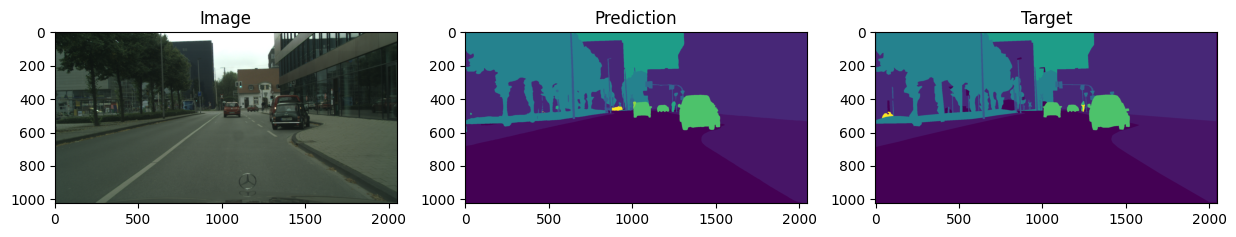

In [ ]:
val_plot(config,segformer, dataset =cityscape_test, device = device,name = 'segformer')

## 7.3. Computing miou

In [ ]:
test_dataloader = torch.utils.data.DataLoader(dataset=cityscape_test,
                                            batch_size=2,
                                            shuffle=False,
                                            num_workers=config.test.num_workers,
                                            pin_memory=config.test.pin_memory,
                                            drop_last=config.test.drop_last)

pixAcc_miou(config,
            model = segformer,
            dataloader = test_dataloader,
            device = device,
            name = 'segformer')

250it [12:44,  3.06s/it]


Pixel Accuracy: 0.9658367782375215
miou: 0.8129091858863831
